# Faixa de Risco e Política de Decisão de Risco

# Resumo

Neste notebook foi conduzida a avaliação final do modelo de risco de crédito, com foco em confiabilidade, estabilidade e impacto econômico. Após a etapa de seleção e estabilização dos modelos — incluindo controle exploratório de overfitting, calibração de probabilidades e validação fora da amostra — as análises avançaram da performance técnica para a tradução direta do risco em métricas econômicas. Nesse processo, verificou-se que, uma vez mitigados problemas de overfitting e calibradas as probabilidades, as diferenças entre os modelos se tornaram menos relevantes do ponto de vista operacional e mais evidentes sob a ótica econômica.

O principal achado do notebook foi a centralidade da escolha do threshold de decisão. A análise de trade-offs mostrou que pequenas variações no threshold geram impactos significativos sobre taxa de aprovação, custo esperado, ganho econômico e retorno sobre o capital alocado. Mais do que a escolha do modelo em si, foi a definição do limiar de decisão que determinou a viabilidade econômica e operacional da política de crédito, evidenciando que o threshold é o principal mecanismo de controle do risco e do retorno no contexto analisado.

# Objetivos

* Consolidar a avaliação final do modelo selecionado;

* Demonstrar confiabilidade, generalização e estabilidade;

* Traduzir performance técnica em impacto econômico;
  
* Suportar a definição de uma Política de Crédito baseada em risco (PD).

# Importando as Bibliotecas

In [175]:
# Manipulação de Dados
import numpy as np
import pandas as pd
import json
import joblib

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

import shap

# Modelagem, Validação e Pipelines
from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    learning_curve,
    cross_val_predict,
    train_test_split
)

# Pipelines
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb


# Pré-processamento
from sklearn.preprocessing import (
    StandardScaler,
    PowerTransformer
)


# Métricas e Avaliação
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
    brier_score_loss,
    log_loss,
    ConfusionMatrixDisplay,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    auc
)

# calibração
from sklearn.calibration import calibration_curve

# Funções Auxiliares
import utils.aux_func as af
from utils.paths import (
    DATA_RAW, 
    DATA_PROCESSED,
    MODELS_ARTIFACTS_DIR,
    SPLITS_DIR,
    METRIC_ARTIFACTS_DIR
)
from evaluation.credit_gain import (
    credit_gain_score,
    make_credit_gain_scorer
)

# Configurações Gerais
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.dpi"] = 400
pd.set_option("display.max_columns", None)


pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(suppress=True, precision=3)

# Contextos e Setups

## Estratégias de Validação

In [176]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Importando os Splits

In [177]:
df = pd.read_parquet(DATA_PROCESSED / "Base_Inadimplencia_Tratada.parquet")
target = 'Inadimplencia'
X = df.drop(columns=[target])
y = df[target]

In [178]:
train_idx = np.load(SPLITS_DIR / "train_idx.npy")
test_idx  = np.load(SPLITS_DIR / "test_idx.npy")

X_train = X.loc[train_idx]
X_test  = X.loc[test_idx]

y_train = y.loc[train_idx]
y_test  = y.loc[test_idx]

In [179]:
with open(SPLITS_DIR / "cv_folds.json", "r") as f:
    cv_folds = json.load(f)

len(cv_folds)

for fold in cv_folds:
    tr_idx = fold["train_idx"]
    val_idx = fold["val_idx"]

    X_tr = X_train.iloc[tr_idx]
    y_tr = y_train.iloc[tr_idx]

    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    break

## Importando a Métrica Econômica

In [180]:
with open(METRIC_ARTIFACTS_DIR / "payoff_config.json", "r") as f:
    payoff_config = json.load(f)

payoff_matrix = np.array(
    payoff_config["payoff_matrix_definition"]["payoff_matrix"]
)

payoff_matrix

array([[  327.13,  -327.13],
       [-2717.01,     0.  ]])

In [181]:
# Criar o scorer personalizado para Credit Gain
credit_gain_scorer = make_credit_gain_scorer(
    payoff_matrix=payoff_matrix,
    threshold=0.5
)

## Definindo a Métrica para Retorno Econômico (ROE)

A métrica ROE Gain foi definida com o objetivo de avaliar o retorno econômico esperado de uma política de crédito, considerando simultaneamente:

- O risco individual estimado pelos modelos (PD);

- A estrutura de ganhos e perdas representada por uma matriz de payoff;

- E, a alocação de capital econômico necessária para sustentar a exposição ao risco.

Diferentemente de métricas puramente classificatórias, o ROE Gain é uma métrica ex-ante, baseada em valor esperado. Para cada cliente aprovado, o lucro esperado é calculado como a esperança matemática do payoff condicional à probabilidade de inadimplência estimada pelo modelo.

O retorno agregado da política é obtido pela soma dos lucros esperados dos clientes aprovados, dividido pela soma do capital econômico alocado, definido como uma fração fixa do valor médio do empréstimo. Essa abordagem permite comparar modelos, thresholds e políticas de corte sob uma ótica econômica consistente, mantendo premissas fixas de negócio.

In [182]:
def roe_gain(
    y_prob,
    payoff_matrix,
    valor_medio_emprestimo,
    capital_factor,
    threshold=0.5
):
    """
    ROE Gain (ex-ante): retorno econômico esperado agregado
    sobre o capital econômico alocado.

    Convenções:
    - y_prob: PD estimada (predict_proba[:, 1])
    - threshold: limiar de decisão
        * y_prob < threshold  → aprova
        * y_prob >= threshold → rejeita
    - payoff_matrix[y_true, decision]
        decision = 0 → aprova
        decision = 1 → rejeita
    """

    # Regra de decisão (interna à função)
    approve_mask = y_prob < threshold

    # PD apenas dos clientes aprovados
    pd_aprovados = y_prob[approve_mask]

    # Payoffs relevantes ao APROVAR
    payoff_aprova_bom = payoff_matrix[0, 0]  # y_true = 0, aprova
    payoff_aprova_mau = payoff_matrix[1, 0]  # y_true = 1, aprova

    # Valor esperado do payoff (ex-ante)
    expected_profit = (
        (1 - pd_aprovados) * payoff_aprova_bom
        + pd_aprovados * payoff_aprova_mau
    )

    # Lucro esperado total
    total_expected_profit = expected_profit.sum()

    # Capital econômico total
    total_capital = (
        approve_mask.sum()
        * valor_medio_emprestimo
        * capital_factor
    )

    # ROE agregado (não médio)
    roe = (
        total_expected_profit / total_capital
        if total_capital > 0 else 0.0
    )

    return roe


## Definindo o Dicionário de Scores

In [183]:
# definindo o score KS
ks_scorer = make_scorer(
    af.ks_stat,
    response_method="predict_proba"
)

# definindo o score Brier
brier_scorer = make_scorer(
    brier_score_loss,
    greater_is_better=False,
    response_method="predict_proba"
)


precision_scorer = make_scorer(precision_score, zero_division=0)
recall_scorer = make_scorer(recall_score, zero_division=0)
f1_scorer = make_scorer(f1_score, zero_division=0)

scoring_model_selection = {
    'AUC': 'roc_auc',
    'KS': ks_scorer,
    'LogLoss': make_scorer(
        log_loss,
        greater_is_better=False,
        response_method='predict_proba'
    )
}


scoring_calibration = {
    'Brier': brier_scorer
}


scoring_diagnostics = {
    'Precision': precision_scorer,
    'Recall': recall_scorer,
    'F1': f1_scorer
}


scoring_business = {
    'Gain_mean': credit_gain_scorer
}


# definindo o dicionario de scores final
scoring = {
    **scoring_model_selection,
    **scoring_calibration,
    **scoring_diagnostics,
    **scoring_business
}

## Revisando o problema de negócio e Variável alvo

O problema de negócio abordado neste projeto consiste na construção de um modelo de risco de crédito capaz de apoiar decisões de concessão, equilibrando retorno econômico e controle de inadimplência. A variável alvo representa o evento de default, definido de forma binária, refletindo o comportamento de pagamento dos clientes após a concessão do crédito. A base analisada apresenta uma distribuição naturalmente desbalanceada, com aproximadamente 70% de clientes adimplentes e 30% de inadimplentes, configuração típica de problemas reais de crédito e que impõe desafios adicionais tanto para o treinamento dos modelos quanto para a definição de políticas de decisão eficazes.

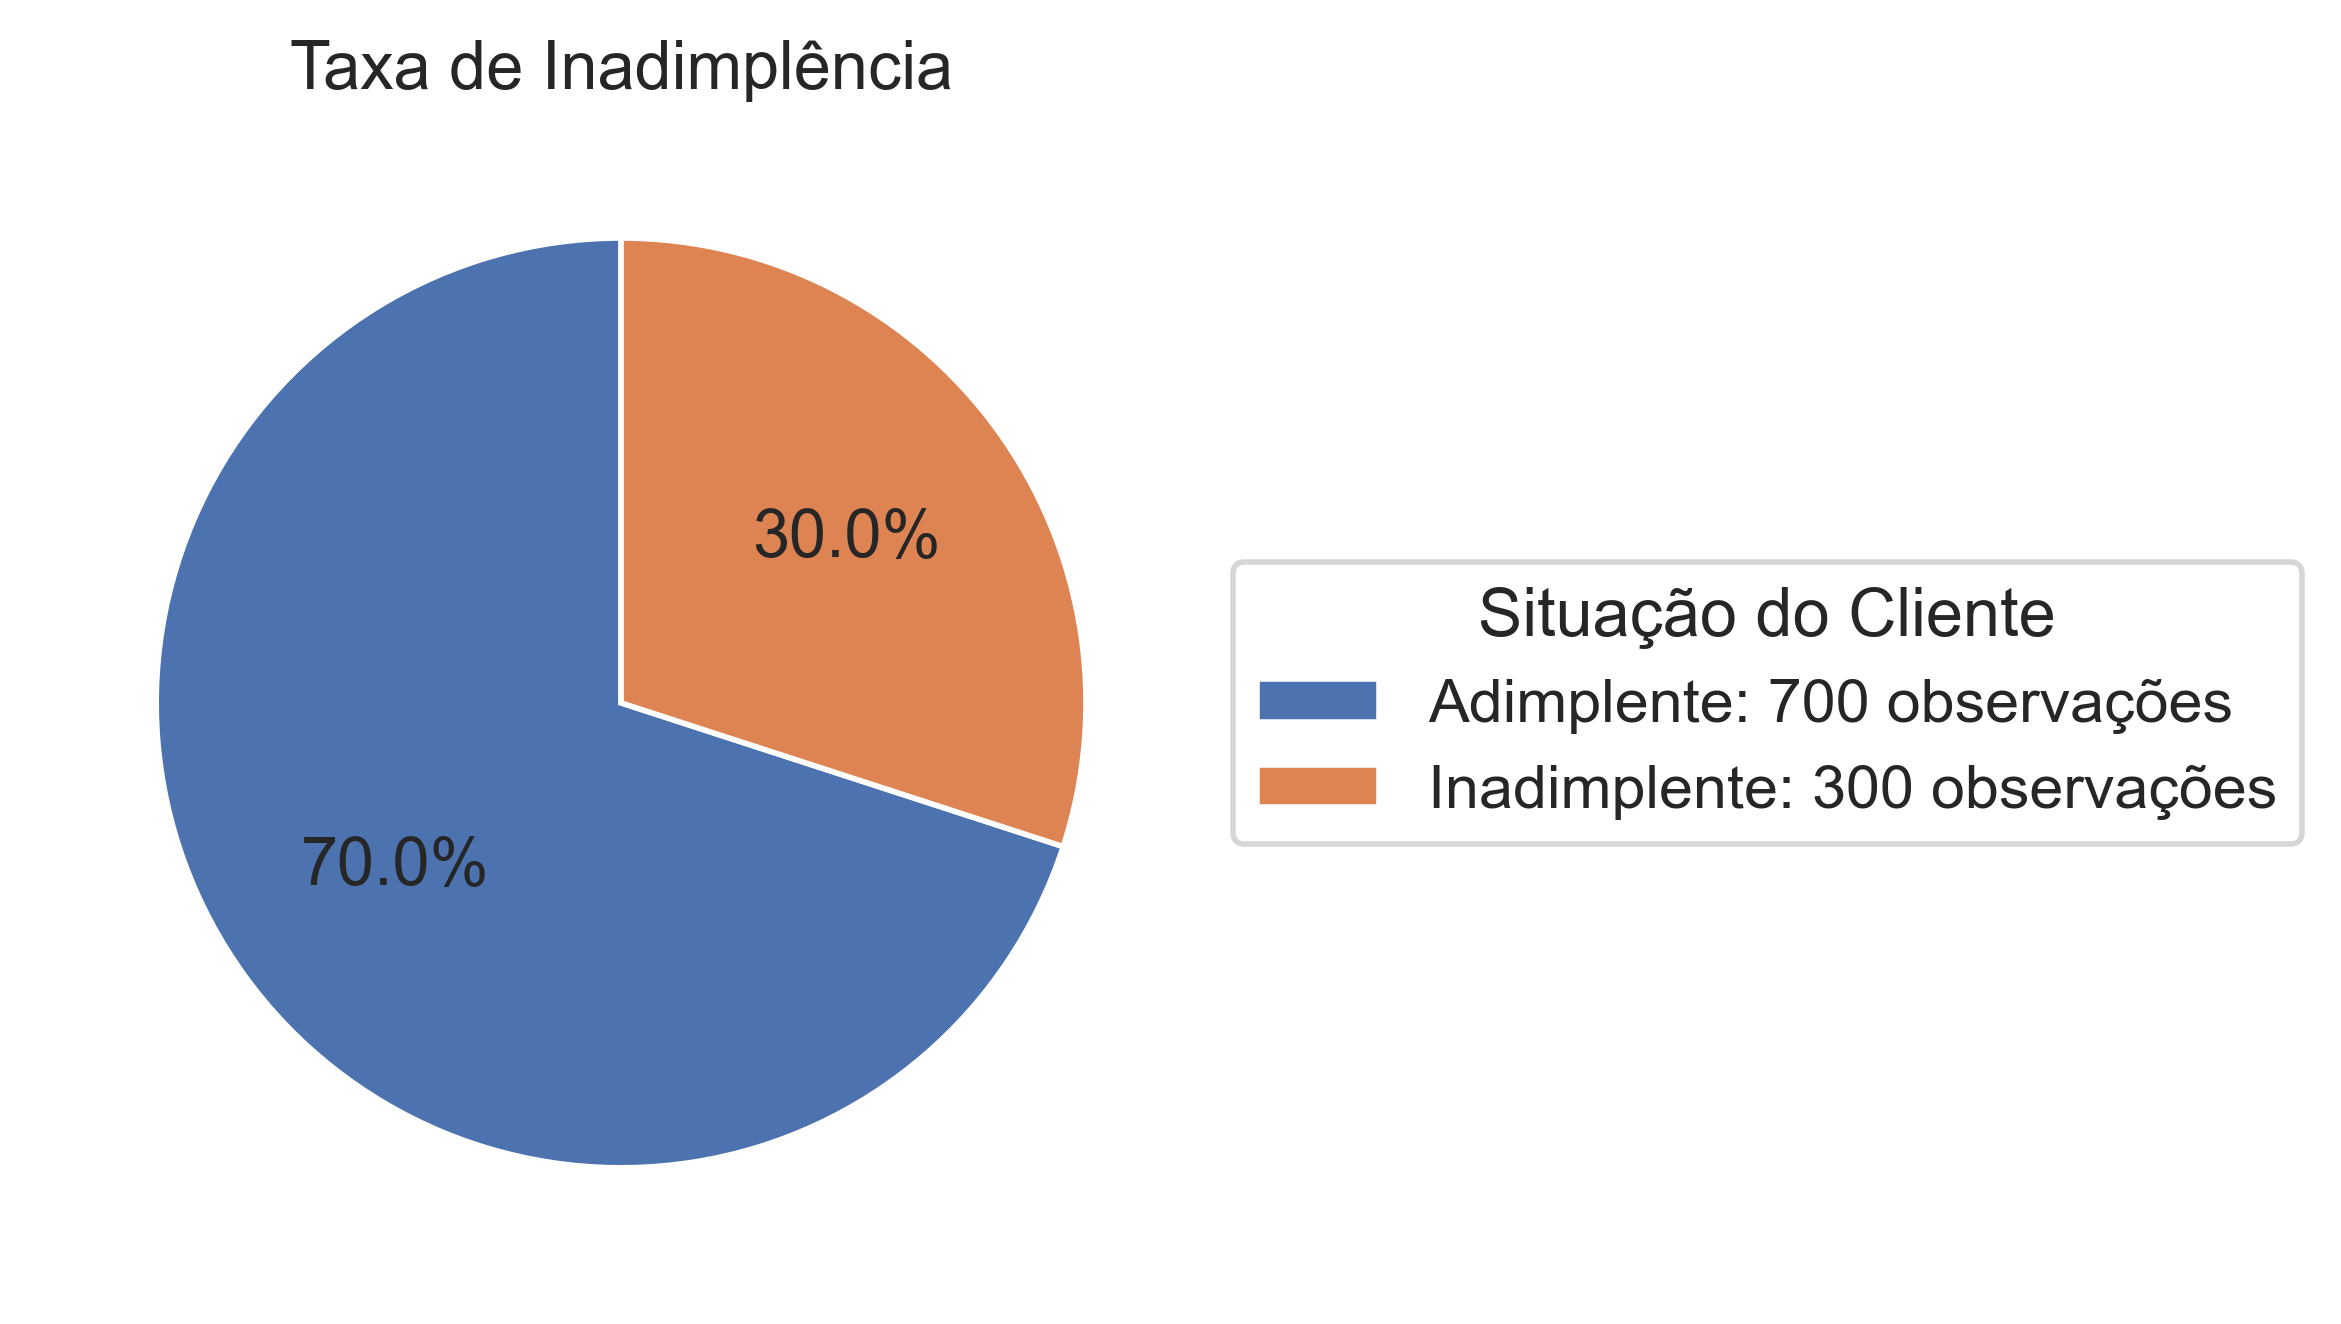

In [184]:
# Estilo seaborn
sns.set_theme(style="whitegrid")

# Contagem da variável target
target_counts = y.value_counts().sort_index()
sizes = target_counts.values

# Mapeamento semântico da target
label_map = {
    0: 'Adimplente',
    1: 'Inadimplente'
}

# Plot
plt.figure(figsize=(6, 6))
wedges, _, autotexts = plt.pie(
    sizes,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)

# Legenda informativa
legend_labels = [
    f'{label_map[label]}: {count} observações'
    for label, count in zip(target_counts.index, sizes)
]

plt.legend(
    wedges,
    legend_labels,
    title='Situação do Cliente',
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

plt.title('Taxa de Inadimplência')
plt.tight_layout()
plt.show()

# Modelos Candidatos (Visão Geral)

- Baseline - DummyClassifier
- Logit ElasticNet - âncora
- GBMs - Benchmarks de Performance (Não Lineares)

## Importando os Pipelines

In [185]:
# logit
logit_pipe = joblib.load(
    MODELS_ARTIFACTS_DIR / "logit_pipe.joblib"
)

# LGBM
lgb_pipe = joblib.load(
    MODELS_ARTIFACTS_DIR / "lgb_pipe.joblib"
)

# XGBM
xgb_pipe = joblib.load(
    MODELS_ARTIFACTS_DIR / "xgb_pipe.joblib"
)


logit_pipe, lgb_pipe, xgb_pipe

(Pipeline(steps=[('yeojohnson', PowerTransformer()),
                 ('scaler', StandardScaler()),
                 ('clf',
                  LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.5,
                                     max_iter=2000, penalty='elasticnet',
                                     random_state=42, solver='saga'))]),
 Pipeline(steps=[('model',
                  LGBMClassifier(class_weight='balanced', colsample_bytree=0.5,
                                 n_estimators=300, n_jobs=-1, objective='binary',
                                 random_state=42, subsample=0.5, verbose=-1))]),
 Pipeline(steps=[('model',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=0.5, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_me

In [186]:
# Baseline - Dummy Classifier
dummy_approve_all = DummyClassifier(strategy="constant", constant=0)
dummy_approve_all.fit(X_train, y_train)

gain_base = credit_gain_scorer(dummy_approve_all, X_test, y_test)
print(f"Ganho Médio aprovando tudo: R$ {gain_base:,.2f}")

Ganho Médio aprovando tudo: R$ -586.11


## Modelos Avaliados

In [187]:
def summarize_cv(
    cv_results,
    metrics_direction=None,
    relative_gap=True
):
    """
    Resume resultados de cross_validate com cálculo de gap treino-validação.

    Parameters
    ----------
    cv_results : dict
        Output do sklearn.model_selection.cross_validate
    metrics_direction : dict
        Direção esperada das métricas.
        Ex: {'AUC': 'max', 'LogLoss': 'min'}
    relative_gap : bool
        Se True, calcula gap relativo (%)

    Returns
    -------
    pd.DataFrame
    """

    rows = {}

    for key in cv_results:
        if not key.startswith("test_"):
            continue

        metric = key.replace("test_", "")
        test_scores = cv_results[key]
        train_scores = cv_results.get(f"train_{metric}")

        rows[metric] = {
            "train_mean": np.mean(train_scores) if train_scores is not None else np.nan,
            "train_std": np.std(train_scores) if train_scores is not None else np.nan,
            "val_mean": np.mean(test_scores),
            "val_std": np.std(test_scores),
        }

        if train_scores is not None:
            gap = rows[metric]["train_mean"] - rows[metric]["val_mean"]
            rows[metric]["gap_abs"] = gap

            if relative_gap:
                denom = abs(rows[metric]["train_mean"])
                rows[metric]["gap_rel_%"] = (gap / denom * 100) if denom != 0 else np.nan
        else:
            rows[metric]["gap_abs"] = np.nan
            rows[metric]["gap_rel_%"] = np.nan

    df = pd.DataFrame(rows).T

    # Ajuste semântico para métricas que devem ser minimizadas
    if metrics_direction:
        for metric, direction in metrics_direction.items():
            if metric in df.index and direction == "min":
                df.loc[metric, ["train_mean", "val_mean"]] *= -1
                df.loc[metric, ["gap_abs", "gap_rel_%"]] *= -1

    return df


metrics_direction = {
    "AUC": "max",
    "KS": "max",
    "LogLoss": "min",
    "F1": "max",
    "Precision": "max",
    "Recall": "max",
    "Brier": "min",
    "Gain_mean": "max"
}

In [188]:
# Logit
logit_results = cross_validate(
    logit_pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True
)

df_logit_results = pd.DataFrame(logit_results)

summary_logit = summarize_cv(
    logit_results,
    metrics_direction=metrics_direction
)

# Gerando previsões OOF para o modelo de Regressão Logística
oof_preds_logit = np.zeros(len(X_train))
for fold in cv_folds:
    tr_idx = fold["train_idx"]
    val_idx = fold["val_idx"]

    X_tr = X_train.iloc[tr_idx]
    y_tr = y_train.iloc[tr_idx]

    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    logit_pipe.fit(X_tr, y_tr)

    oof_preds_logit[val_idx] = logit_pipe.predict_proba(X_val)[:, 1]

# Calculando o Credit Gain no conjunto de teste
y_test_proba_logit = logit_pipe.predict_proba(X_test)[:, 1]

gain_logit = credit_gain_score(
    y_true=y_test,
    y_score=y_test_proba_logit,
    threshold=0.5,
    payoff_matrix=payoff_matrix
)

In [189]:
# lgbm
lgb_results = cross_validate(
    lgb_pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True
)

df_lgb_results = pd.DataFrame(lgb_results)

summary_lgb = summarize_cv(
    lgb_results,
    metrics_direction=metrics_direction
)

# Gerando previsões OOF para o modelo LightGBM
oof_preds_lgb = np.zeros(len(X_train))
for fold in cv_folds:
    tr_idx = fold["train_idx"]
    val_idx = fold["val_idx"]

    X_tr = X_train.iloc[tr_idx]
    y_tr = y_train.iloc[tr_idx]

    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    lgb_pipe.fit(X_tr, y_tr)

    oof_preds_lgb[val_idx] = lgb_pipe.predict_proba(X_val)[:, 1]

# Calculando o Credit Gain no conjunto de teste
y_test_proba_lgb = lgb_pipe.predict_proba(X_test)[:, 1]
gain_lgb = credit_gain_score(
    y_true=y_test,
    y_score=y_test_proba_lgb,
    threshold=0.5,
    payoff_matrix=payoff_matrix
)

In [190]:
# xgbm
xgb_results = cross_validate(
    xgb_pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True
)

df_xgb_results = pd.DataFrame(xgb_results)

summary_xgb = summarize_cv(
    xgb_results,
    metrics_direction=metrics_direction
)

# Gerando previsões OOF para o modelo XGBoost
oof_preds_xgb = np.zeros(len(X_train))
for fold in cv_folds:
    tr_idx = fold["train_idx"]
    val_idx = fold["val_idx"]

    X_tr = X_train.iloc[tr_idx]
    y_tr = y_train.iloc[tr_idx]

    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    xgb_pipe.fit(X_tr, y_tr)

    oof_preds_xgb[val_idx] = xgb_pipe.predict_proba(X_val)[:, 1]

# Calculando o Credit Gain no conjunto de teste
y_test_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]
gain_xgb = credit_gain_score(
    y_true=y_test,
    y_score=y_test_proba_xgb,
    threshold=0.5,
    payoff_matrix=payoff_matrix
)

In [191]:
def extract_cv_metrics(cv_results):
    return {
        "AUC (val)": np.mean(cv_results["test_AUC"]),
        "KS (val)": np.mean(cv_results["test_KS"]),
        "LogLoss (val)": -np.mean(cv_results["test_LogLoss"]),
        "Brier (val)": -np.mean(cv_results["test_Brier"]),
        "Gain_mean (val)": np.mean(cv_results["test_Gain_mean"]),
    }


In [192]:
def calc_cv_gap(cv_results, metric_name):
    """
    Calcula o gap absoluto entre treino e validação (CV),
    em pontos percentuais.
    """
    train_mean = np.mean(cv_results[f"train_{metric_name}"])
    val_mean   = np.mean(cv_results[f"test_{metric_name}"])

    return (abs(train_mean - val_mean) / train_mean)* 100



In [193]:
def ks_statistic(y_true, y_score):
    data = pd.DataFrame({
        "y_true": y_true,
        "y_score": y_score
    }).sort_values("y_score", ascending=False)

    data["cum_pos"] = (data["y_true"] == 1).cumsum() / (data["y_true"] == 1).sum()
    data["cum_neg"] = (data["y_true"] == 0).cumsum() / (data["y_true"] == 0).sum()

    return np.max(np.abs(data["cum_pos"] - data["cum_neg"]))


In [194]:
# Calculando métricas OOF e Holdout para cada modelo
# Logística
auc_oof_logit = roc_auc_score(y_train, oof_preds_logit)
auc_test_logit = roc_auc_score(y_test, y_test_proba_logit)
ks_oof_logit  = ks_statistic(y_train, oof_preds_logit)
ks_test_logit  = ks_statistic(y_test, y_test_proba_logit)

# LightGBM
auc_oof_lgb = roc_auc_score(y_train, oof_preds_lgb)
auc_test_lgb = roc_auc_score(y_test, y_test_proba_lgb)
ks_oof_lgb  = ks_statistic(y_train, oof_preds_lgb)
ks_test_lgb  = ks_statistic(y_test, y_test_proba_lgb)

# XGBoost
auc_oof_xgb = roc_auc_score(y_train, oof_preds_xgb)
auc_test_xgb = roc_auc_score(y_test, y_test_proba_xgb)
ks_oof_xgb  = ks_statistic(y_train, oof_preds_xgb)
ks_test_xgb  = ks_statistic(y_test, y_test_proba_xgb)

In [195]:
rows = []

# Logística
row_logit = {
    "Modelo": "Logit ElasticNet"
}
row_logit.update(extract_cv_metrics(logit_results))
row_logit["Gap AUC (%)"] = calc_cv_gap(logit_results, "AUC")
row_logit["Gap KS (%)"]  = calc_cv_gap(logit_results, "KS")

rows.append(row_logit)


# LightGBM
row_lgb = {
    "Modelo": "LightGBM"
}
row_lgb.update(extract_cv_metrics(lgb_results))
row_lgb["Gap AUC (%)"] = calc_cv_gap(lgb_results, "AUC")
row_lgb["Gap KS (%)"]  = calc_cv_gap(lgb_results, "KS")

rows.append(row_lgb)

# XGBoost
row_xgb = {
    "Modelo": "XGBoost"
}
row_xgb.update(extract_cv_metrics(xgb_results))
row_xgb["Gap AUC (%)"] = calc_cv_gap(xgb_results, "AUC")
row_xgb["Gap KS (%)"]  = calc_cv_gap(xgb_results, "KS")

rows.append(row_xgb)

df_model_comparison = pd.DataFrame(rows)


In [196]:
df_model_comparison = (
    df_model_comparison
        .set_index("Modelo")
        .round(3)
        .sort_values("AUC (val)", ascending=False)
)

df_model_comparison


AUC (val)  KS (val)  LogLoss (val)  Brier (val)  \
Modelo                                                              
Logit ElasticNet      0.752     0.465          0.593        0.203   
XGBoost               0.737     0.431          0.602        0.194   
LightGBM              0.724     0.390          0.785        0.215   

                  Gain_mean (val)  Gap AUC (%)  Gap KS (%)  
Modelo                                                      
Logit ElasticNet         -132.670        3.425       0.515  
XGBoost                  -214.454       25.906      54.298  
LightGBM                 -247.803       27.570      61.020

## Expectativas iniciais e Riscos conhecidos

A avaliação inicial dos modelos, sintetizada na tabela de métricas de validação, permitiu estabelecer expectativas claras quanto ao desempenho técnico, estabilidade e viabilidade econômica de cada abordagem. A Regressão Logística com Elastic Net apresentou o melhor equilíbrio entre discriminação e robustez, destacando-se pelo maior AUC e KS em validação, menor LogLoss entre os modelos e, sobretudo, pelo menor gap entre treino e validação, indicando maior capacidade de generalização. Esses resultados sustentaram a expectativa de que a regressão logística seria um benchmark sólido não apenas do ponto de vista técnico, mas também como referência de estabilidade para análises econômicas subsequentes.

Por outro lado, os modelos baseados em árvores de decisão — XGBoost e LightGBM —, embora competitivos em métricas puramente discriminatórias, apresentaram gaps elevados de AUC e KS, sinalizando risco relevante de overfitting. Esse comportamento levantou desde o início preocupações quanto à confiabilidade das probabilidades estimadas e à estabilidade do desempenho fora da amostra, especialmente em um contexto onde decisões econômicas e políticas de crédito dependem fortemente da calibração e da robustez do modelo. Adicionalmente, ambos os GBMs exibiram desempenho econômico preliminar inferior, com ganhos médios mais negativos, reforçando a expectativa de maior risco operacional e financeiro caso fossem utilizados sem controles rigorosos de regularização e calibração.

Assim, antes mesmo das análises de threshold e impacto econômico, os resultados iniciais já indicavam um trade-off claro entre complexidade do modelo e governança do risco. Enquanto os GBMs demandariam maior esforço de controle para mitigar instabilidade e overfitting, a regressão logística despontava como uma alternativa mais previsível e transparente, reduzindo riscos conhecidos associados à variabilidade do desempenho e à interpretação das decisões de crédito.

# Controle Exploratório de Overfitting

Modelos baseados em árvores de decisão, como Gradient Boosting Machines (GBMs), possuem alta capacidade de ajuste não linear. Essa flexibilidade, embora poderosa, torna esses modelos particularmente suscetíveis ao overfitting, especialmente em cenários com desbalanceamento de classes e sinais fracos. Dado que este notebook tem como objetivo seleção de modelo para decisão econômica, o controle de overfitting é uma etapa fundamental. Modelos que não apresentam estabilidade fora da amostra não avançam para análises de calibração, threshold ou impacto econômico.

**Estratégia 1 — Early Stopping**

O *Early Stopping* é uma técnica de regularização que interrompe o treinamento do modelo quando a performance em um conjunto de validação deixa de melhorar. Ele evita que o modelo continue aprendendo padrões específicos do treino mesmo quando isso não traduz em ganho. Em outras palavras, o modelo é treinado até o ponto de máxima generalização observada, e nao até o máximo de ajuste possível. Como o treinamento ocorre de forma iterativa (árvore por árvore). O early stopping monitora uma métrica (ex.: AUC, logloss) avaliada em dados fora do treino e encerra o processo quando não há melhora após um número pré-definido de iterações. 

É importante destacar que ele não substitui a validação cruzada, ele atua dentro de cada treinamento. Desse modo, precisamos aplicar um conjunto de validação separado do treino para realizar o critério de parada e fixar o número máximo de iterações sem melhora antes da parada (valores típicos entre 30 a 100 - modelos mais agressivos ao overfitting podem chegar a 10).


**Estratégia 2 — Poda estrutural via grid regulatório (GBMs)**

Além do early stopping, o crescimento excessivo das árvores é uma das principais fontes de overfitting em GBMs. Por isso, a segunda estratégia adotada é restringir explicitamente a complexidade estrutural do modelo. O objetivo aqui não é otimizar performance, mas limitar a capacidade do modelo de memorizar o treino.

Parâmetros regulatórios (conceito de poda):
- `max_depth`
- `gamma`
- `num_leaves`
- `min_data_in_leaf`
- `min_child_weight`


A metodologia abordada nessa seção será a seguinte:
- definir um conjunto de validação interno a partir de X_train;
- criar um dicionário de diferentes variações de parametros regulatórios para o controle de poda;
- treinar os modelos em um loop e consolidar os resultados em um dataframe;
- identificar quais parametros obtiveram o melhor desempenho combinando desempenho e estabilidade;
- congelar os modelos e realizar as previsoes na OOF e na Holdout;
- avaliar o comportamento da curva de aprendizado

Com base na metodologia descrita acima, somente os modelos que apresentarem controle satisfatório de overfitting seguem para calibração, análise de threshold  e métricas econômicas (ROE / ganho). Nesta etapa, optou-se pela redução de overfitting por meio de mecanismos estruturais e de regularização simples, evitando tuning agressivo. O objetivo é garantir estabilidade e confiabilidade do modelo antes de qualquer avaliação econômica.

In [197]:
X_train_es, X_valid_es, y_train_es, y_valid_es = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)


In [198]:
lgbm_param_grid = [
    {
        "max_depth": 3,
        "num_leaves": 15,
        "min_data_in_leaf": 100
    },
    {
        "max_depth": 5,
        "num_leaves": 31,
        "min_data_in_leaf": 100
    },
    {
        "max_depth": 7,
        "num_leaves": 63,
        "min_data_in_leaf": 200
    }
]


xgb_param_grid = [
    {
        "max_depth": 3,
        "min_child_weight": 10,
        "gamma": 0
    },
    {
        "max_depth": 5,
        "min_child_weight": 10,
        "gamma": 1
    },
    {
        "max_depth": 7,
        "min_child_weight": 20,
        "gamma": 5
    }
]

In [199]:
def ks_statistic(y_true, y_score):
    data = pd.DataFrame({
        "y_true": y_true,
        "y_score": y_score
    }).sort_values("y_score", ascending=False)

    data["cum_pos"] = (data["y_true"] == 1).cumsum() / (data["y_true"] == 1).sum()
    data["cum_neg"] = (data["y_true"] == 0).cumsum() / (data["y_true"] == 0).sum()

    return np.max(np.abs(data["cum_pos"] - data["cum_neg"]))

In [200]:
# LGBM
lgbm_results_over = []

for params in lgbm_param_grid:

    model = lgb.LGBMClassifier(
        objective="binary",
        n_estimators=2000,          
        learning_rate=0.05,
        class_weight="balanced",
        random_state=42,
        verbose=-1,
        **params
    )

    model.fit(
        X_train_es,
        y_train_es,
        eval_set=[(X_valid_es, y_valid_es)],
        eval_metric="auc",
        callbacks=[
            lgb.early_stopping(stopping_rounds=20, verbose=False)
        ]
    )

    best_iter = model.best_iteration_

    # Probabilidades (PD)
    y_train_prob = model.predict_proba(X_train_es)[:, 1]
    y_valid_prob = model.predict_proba(X_valid_es)[:, 1]

    # AUC
    auc_train = roc_auc_score(y_train_es, y_train_prob)
    auc_valid = roc_auc_score(y_valid_es, y_valid_prob)

    # KS
    ks_train = ks_statistic(y_train_es, y_train_prob)
    ks_valid = ks_statistic(y_valid_es, y_valid_prob)

    lgbm_results_over.append({
        **params,
        "best_iteration": best_iter,
        "auc_train": auc_train,
        "auc_valid": auc_valid,
        "auc_gap_pct": (abs(auc_train - auc_valid) / auc_train) * 100,
        "ks_train": ks_train,
        "ks_valid": ks_valid,
        "ks_gap": (abs(ks_train - ks_valid) / ks_train) * 100
    })


In [201]:
# Resultados
xgb_results_over = []

# Balanceamento via scale_pos_weight
scale_pos_weight = (y_train_es == 0).sum() / (y_train_es == 1).sum()

# DMatrix (obrigatório na API nativa)
dtrain = xgb.DMatrix(X_train_es, label=y_train_es)
dvalid = xgb.DMatrix(X_valid_es, label=y_valid_es)

for params in xgb_param_grid:

    xgb_params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "learning_rate": 0.05,
        "scale_pos_weight": scale_pos_weight,
        "seed": 42,
        **params
    }

    model = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=2000,  # alto de propósito
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # Predições (PD)
    y_train_prob = model.predict(dtrain)
    y_valid_prob = model.predict(dvalid)

    # AUC
    auc_train = roc_auc_score(y_train_es, y_train_prob)
    auc_valid = roc_auc_score(y_valid_es, y_valid_prob)

    # KS
    ks_train = ks_statistic(y_train_es, y_train_prob)
    ks_valid = ks_statistic(y_valid_es, y_valid_prob)

    xgb_results_over.append({
        **params,
        "best_iteration": model.best_iteration,
        "auc_train": auc_train,
        "auc_valid": auc_valid,
        "auc_gap": (abs(auc_train - auc_valid) / auc_train) * 100,
        "ks_train": ks_train,
        "ks_valid": ks_valid,
        "ks_gap": (abs(ks_train - ks_valid) / ks_train) * 100
    })


## Diagnóstico de Overfitting

In [202]:
df_lgb_overfit = pd.DataFrame(lgbm_results_over)
df_xgb_overfit = pd.DataFrame(xgb_results_over)

In [203]:
df_lgb_overfit

max_depth  num_leaves  min_data_in_leaf  best_iteration  auc_train  \
0          3          15               100              72      0.793   
1          5          31               100              30      0.774   
2          7          63               200              18      0.649   

   auc_valid  auc_gap_pct  ks_train  ks_valid  ks_gap  
0      0.781        1.547     0.462     0.459   0.552  
1      0.768        0.802     0.427     0.425   0.398  
2      0.734       13.112     0.264     0.493  87.097

In [204]:
df_xgb_overfit

max_depth  min_child_weight  gamma  best_iteration  auc_train  auc_valid  \
0          3                10      0              91      0.857      0.766   
1          5                10      1              80      0.879      0.780   
2          7                20      5              44      0.798      0.771   

   auc_gap  ks_train  ks_valid  ks_gap  
0   10.621     0.559     0.490  12.329  
1   11.265     0.613     0.531  13.454  
2    3.395     0.491     0.510   3.806

Os resultados obtidos foram muito promissores. O overfitting foi controlado e obtivemos métricas excelentes de performance. A próxima etapa agora é reescrever os pipelines dos modelos GBMs para realizar as previsões e comparar com o modelo logit ElasticNet.

## Reescrevendo os pipelines GBMs

In [205]:
# definindo o classificador LightGBM
lgb_clf = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=30,
    max_depth=5,
    num_leaves=31,
    min_data_in_leaf=100,
    class_weight='balanced',
    subsample=0.5,
    colsample_bytree=0.5,
    random_state=42,
    n_jobs=-1
)

# criando o pipeline LightGBM
lgb_pipe = Pipeline(
    steps=[
        ("model", lgb_clf)
    ]
)

# definindo o classificador XGBoost
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()

scale_pos_weight = n_neg / n_pos


xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=44,
    max_depth=7,
    min_child_weight=20,
    gamma=5,
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.05,
    subsample=0.5,
    colsample_bytree=0.5,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_pipe = Pipeline(
    steps=[
        ("model", xgb_clf)
    ]
)

## Previsões LGBM

In [206]:
# avaliando o LightGBM com cross-validation
cv_results_lgb = cross_validate(
    estimator=lgb_pipe,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=True
)

# criando DataFrame com os resultados do LightGBM
df_lgb_results = pd.DataFrame(cv_results_lgb)

# resumindo os resultados do LightGBM
summary_lgb = summarize_cv(
    cv_results_lgb,
    metrics_direction=metrics_direction
)

summary_lgb

train_mean  train_std  val_mean  val_std  gap_abs  gap_rel_%
AUC             0.797      0.009     0.743    0.048    0.054      6.785
KS              0.476      0.011     0.420    0.068    0.056     11.826
LogLoss         0.564      0.009     0.598    0.028   -0.034     -5.940
Brier           0.191      0.004     0.206    0.013   -0.015     -7.824
Precision       0.512      0.013     0.483    0.039    0.029      5.704
Recall          0.767      0.012     0.729    0.044    0.038      4.969
F1              0.614      0.007     0.580    0.036    0.034      5.511
Gain_mean    -104.670      6.439  -146.470   43.547   41.800     39.935

In [207]:
# gerando previsões out-of-fold (OOF) para LightGBM
oof_preds_lgb_v2 = np.zeros(len(X_train))
for fold in cv_folds:
    tr_idx = fold["train_idx"]
    val_idx = fold["val_idx"]

    X_tr = X_train.iloc[tr_idx]
    y_tr = y_train.iloc[tr_idx]

    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    # fit
    lgb_pipe.fit(X_tr, y_tr)

    # predict OOF
    oof_preds_lgb_v2[val_idx] = lgb_pipe.predict_proba(X_val)[:, 1]

In [208]:
# Gerando as previsões no Holdout para o LightGBM
lgb_pipe.fit(X_train, y_train)
y_test_proba_lgb_v2 = lgb_pipe.predict_proba(X_test)[:, 1]

## Previsões XGBM

In [209]:
cv_results_xgb = cross_validate(
    estimator=xgb_pipe,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=True
)

# criando DataFrame com os resultados do XGBoost
df_xgb_results = pd.DataFrame(cv_results_xgb)

# resumindo os resultados do XGBoost
summary_xgb = summarize_cv(
    cv_results_xgb,
    metrics_direction=metrics_direction
)

summary_xgb

train_mean  train_std  val_mean  val_std  gap_abs  gap_rel_%
AUC             0.776      0.013     0.747    0.052    0.028      3.652
KS              0.424      0.032     0.431    0.081   -0.007     -1.766
LogLoss         0.597      0.012     0.608    0.017   -0.012     -1.933
Brier           0.204      0.005     0.209    0.008   -0.005     -2.601
Precision       0.467      0.026     0.450    0.035    0.017      3.594
Recall          0.768      0.027     0.719    0.096    0.049      6.357
F1              0.580      0.018     0.552    0.046    0.029      4.917
Gain_mean    -133.375     18.433  -172.926   68.026   39.551     29.654

In [210]:
# gerando previsões out-of-fold (OOF) para XGBoost
oof_preds_xgb_v2 = np.zeros(len(X_train))
for fold in cv_folds:
    tr_idx = fold["train_idx"]
    val_idx = fold["val_idx"]

    X_tr = X_train.iloc[tr_idx]
    y_tr = y_train.iloc[tr_idx]

    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    xgb_pipe.fit(X_tr, y_tr)

    oof_preds_xgb_v2[val_idx] = xgb_pipe.predict_proba(X_val)[:, 1]

In [211]:
# Gerando as previsões no Holdout para o XGBoost
xgb_pipe.fit(X_train, y_train)
y_test_proba_xgb_v2 = xgb_pipe.predict_proba(X_test)[:, 1]

## Comparação Logit vs GBMs s/ Overfitting

### Tabela Consolidada

In [212]:
# LightGBM
auc_oof_lgb_v2 = roc_auc_score(y_train, oof_preds_lgb_v2)
auc_test_lgb_v2 = roc_auc_score(y_test, y_test_proba_lgb_v2)
ks_oof_lgb_v2  = ks_statistic(y_train, oof_preds_lgb_v2)
ks_test_lgb_v2  = ks_statistic(y_test, y_test_proba_lgb_v2)

# XGBoost
auc_oof_xgb_v2 = roc_auc_score(y_train, oof_preds_xgb_v2)
auc_test_xgb_v2 = roc_auc_score(y_test, y_test_proba_xgb_v2)
ks_oof_xgb_v2  = ks_statistic(y_train, oof_preds_xgb_v2)
ks_test_xgb_v2  = ks_statistic(y_test, y_test_proba_xgb_v2)

In [213]:
# LightGBM
row_lgb_v2 = {
    "Modelo": "LightGBM s/ Overfitting"
}
row_lgb_v2.update(extract_cv_metrics(cv_results_lgb))
row_lgb_v2["Gap AUC (%)"] = calc_cv_gap(cv_results_lgb, "AUC")
row_lgb_v2["Gap KS (%)"]  = calc_cv_gap(cv_results_lgb, "KS")

rows.append(row_lgb_v2)

# XGBoost
row_xgb_v2 = {
    "Modelo": "XGBoost s/ Overfitting"
}
row_xgb_v2.update(extract_cv_metrics(cv_results_xgb))
row_xgb_v2["Gap AUC (%)"] = calc_cv_gap(cv_results_xgb, "AUC")
row_xgb_v2["Gap KS (%)"]  = calc_cv_gap(cv_results_xgb, "KS")

rows.append(row_xgb_v2)

df_model_comparison = pd.DataFrame(rows)

In [214]:
df_model_comparison = (
    df_model_comparison
        .set_index("Modelo")
        .round(3)
        .sort_values("AUC (val)", ascending=False)
)

df_model_comparison

AUC (val)  KS (val)  LogLoss (val)  Brier (val)  \
Modelo                                                                     
Logit ElasticNet             0.752     0.465          0.593        0.203   
XGBoost s/ Overfitting       0.747     0.431          0.608        0.209   
LightGBM s/ Overfitting      0.743     0.420          0.598        0.206   
XGBoost                      0.737     0.431          0.602        0.194   
LightGBM                     0.724     0.390          0.785        0.215   

                         Gain_mean (val)  Gap AUC (%)  Gap KS (%)  
Modelo                                                             
Logit ElasticNet                -132.670        3.425       0.515  
XGBoost s/ Overfitting          -172.926        3.652       1.766  
LightGBM s/ Overfitting         -146.470        6.785      11.826  
XGBoost                         -214.454       25.906      54.298  
LightGBM                        -247.803       27.570      61.020

### Learning Curves

In [215]:
def get_learning_curve_data(
    estimator,
    X,
    y,
    cv,
    scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1
):
    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        train_sizes=train_sizes,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=42
    )

    df = pd.DataFrame({
        "Train Size": train_sizes_abs,

        "Train Mean": train_scores.mean(axis=1),
        "Train Std": train_scores.std(axis=1),

        "Validation Mean": val_scores.mean(axis=1),
        "Validation Std": val_scores.std(axis=1),
    })

    return df


In [216]:
lc_logit = get_learning_curve_data(
    estimator=logit_pipe,
    X=X_train,
    y=y_train,
    cv=cv
)

lc_lgb = get_learning_curve_data(
    estimator=lgb_pipe,
    X=X_train,
    y=y_train,
    cv=cv
)

lc_xgb = get_learning_curve_data(
    estimator=xgb_pipe,
    X=X_train,
    y=y_train,
    cv=cv
)


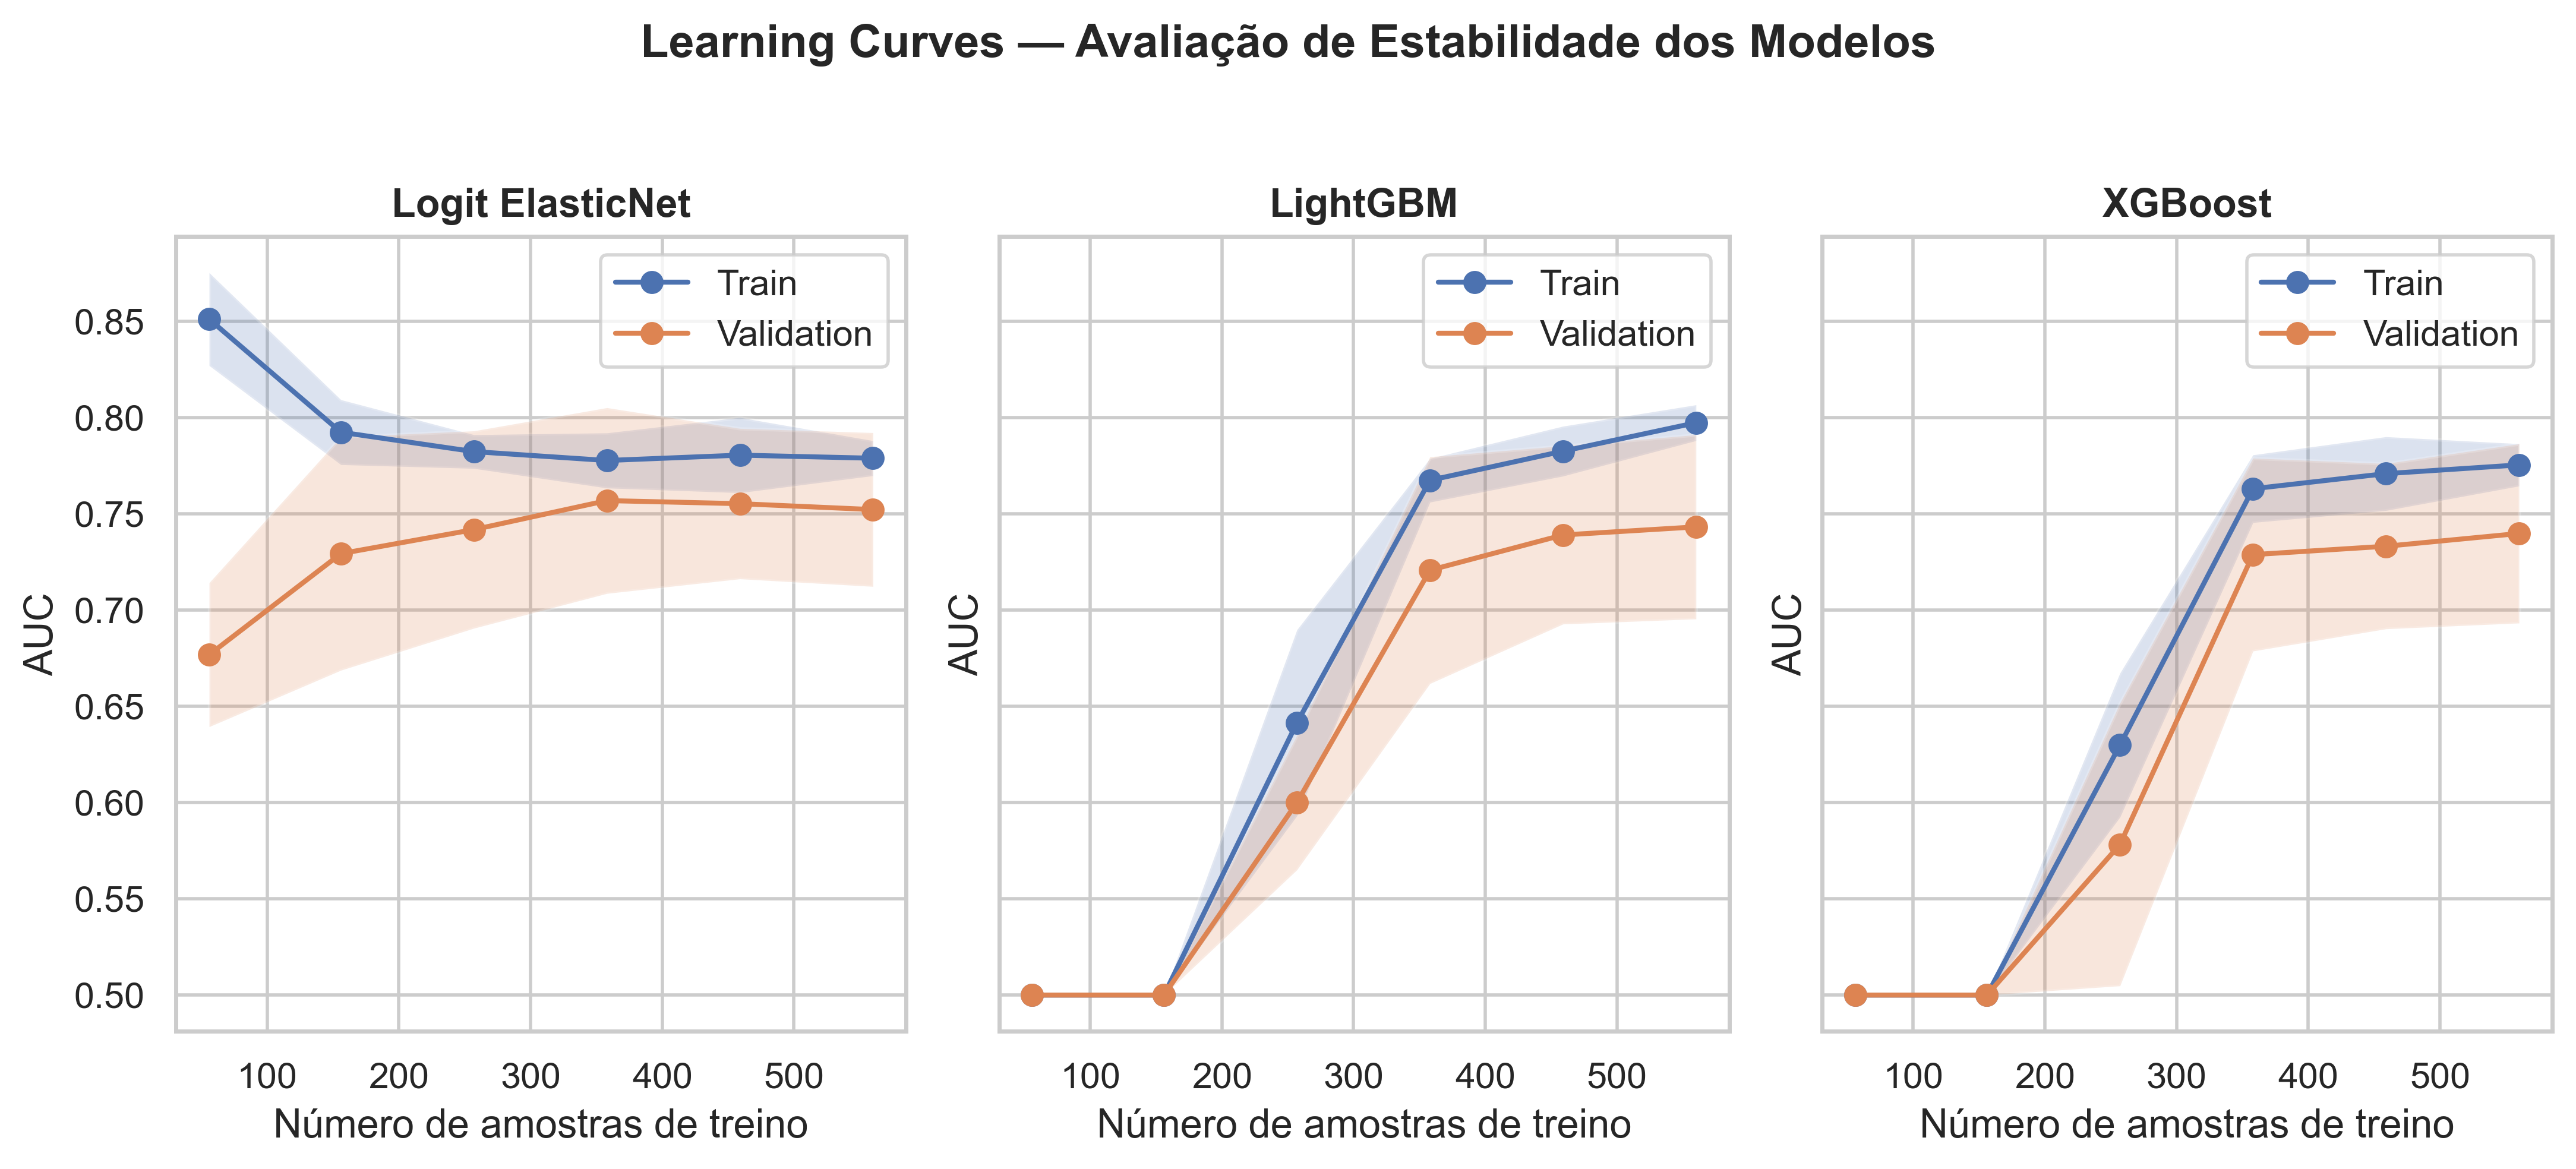

In [217]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(11, 5),
    sharey=True
)

models_data = [
    ("Logit ElasticNet", lc_logit),
    ("LightGBM", lc_lgb),
    ("XGBoost", lc_xgb)
]

for ax, (title, df) in zip(axes, models_data):

    # ---- Train curve ----
    ax.plot(
        df["Train Size"],
        df["Train Mean"],
        marker="o",
        label="Train",
    )

    ax.fill_between(
        df["Train Size"],
        df["Train Mean"] - df["Train Std"],
        df["Train Mean"] + df["Train Std"],
        alpha=0.2
    )

    # ---- Validation curve ----
    ax.plot(
        df["Train Size"],
        df["Validation Mean"],
        marker="o",
        label="Validation",
    )

    ax.fill_between(
        df["Train Size"],
        df["Validation Mean"] - df["Validation Std"],
        df["Validation Mean"] + df["Validation Std"],
        alpha=0.2
    )

    ax.set_title(title, fontsize=12, weight="bold")
    ax.set_xlabel("Número de amostras de treino")
    ax.set_ylabel("AUC")
    ax.legend()

plt.suptitle(
    "Learning Curves — Avaliação de Estabilidade dos Modelos",
    fontsize=14,
    weight="bold"
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Conclusão

O overfitting antes observado nos GBMs conseguiu ser controlado com estratégias simples, não havendo a necessidade de um controle mais agressivo como o tunning agressivo de hiperparâmetros. Dessa forma, os GBMs seguem para as etapas seguintes.

# Calibração

A calibração será avaliada inicialmente a partir das probabilidades out-of-fold (OOF), de modo a evitar viés de avaliação e reduzir a variância associada a um único conjunto de validação. Métricas quantitativas (Brier Score e ECE) serão combinadas com inspeção visual das curvas de calibração para decidir sobre a necessidade de calibração adicional.

## Gráfico pré-calibração

In [218]:
# Dicionario com probabilidades OOF por modelo pré calibração
oof_probs = {
    "LogisticRegression": oof_preds_logit,
    "LightGBM": oof_preds_lgb_v2,
    "XGBoost": oof_preds_xgb_v2
}

y_true_oof = y_train.values

In [219]:
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = bin_ids == i
        if np.any(mask):
            avg_prob = y_prob[mask].mean()
            avg_true = y_true[mask].mean()
            ece += np.abs(avg_prob - avg_true) * mask.mean()

    return ece

In [220]:
calibration_table = []

for model_name, y_prob in oof_probs.items():
    calibration_table.append({
        "model": model_name,
        "brier_score": brier_score_loss(y_true_oof, y_prob),
        "ece": expected_calibration_error(y_true_oof, y_prob)
    })

calibration_df = pd.DataFrame(calibration_table).sort_values("brier_score")
calibration_df

model  brier_score   ece
0  LogisticRegression        0.203 0.158
1            LightGBM        0.206 0.161
2             XGBoost        0.209 0.170

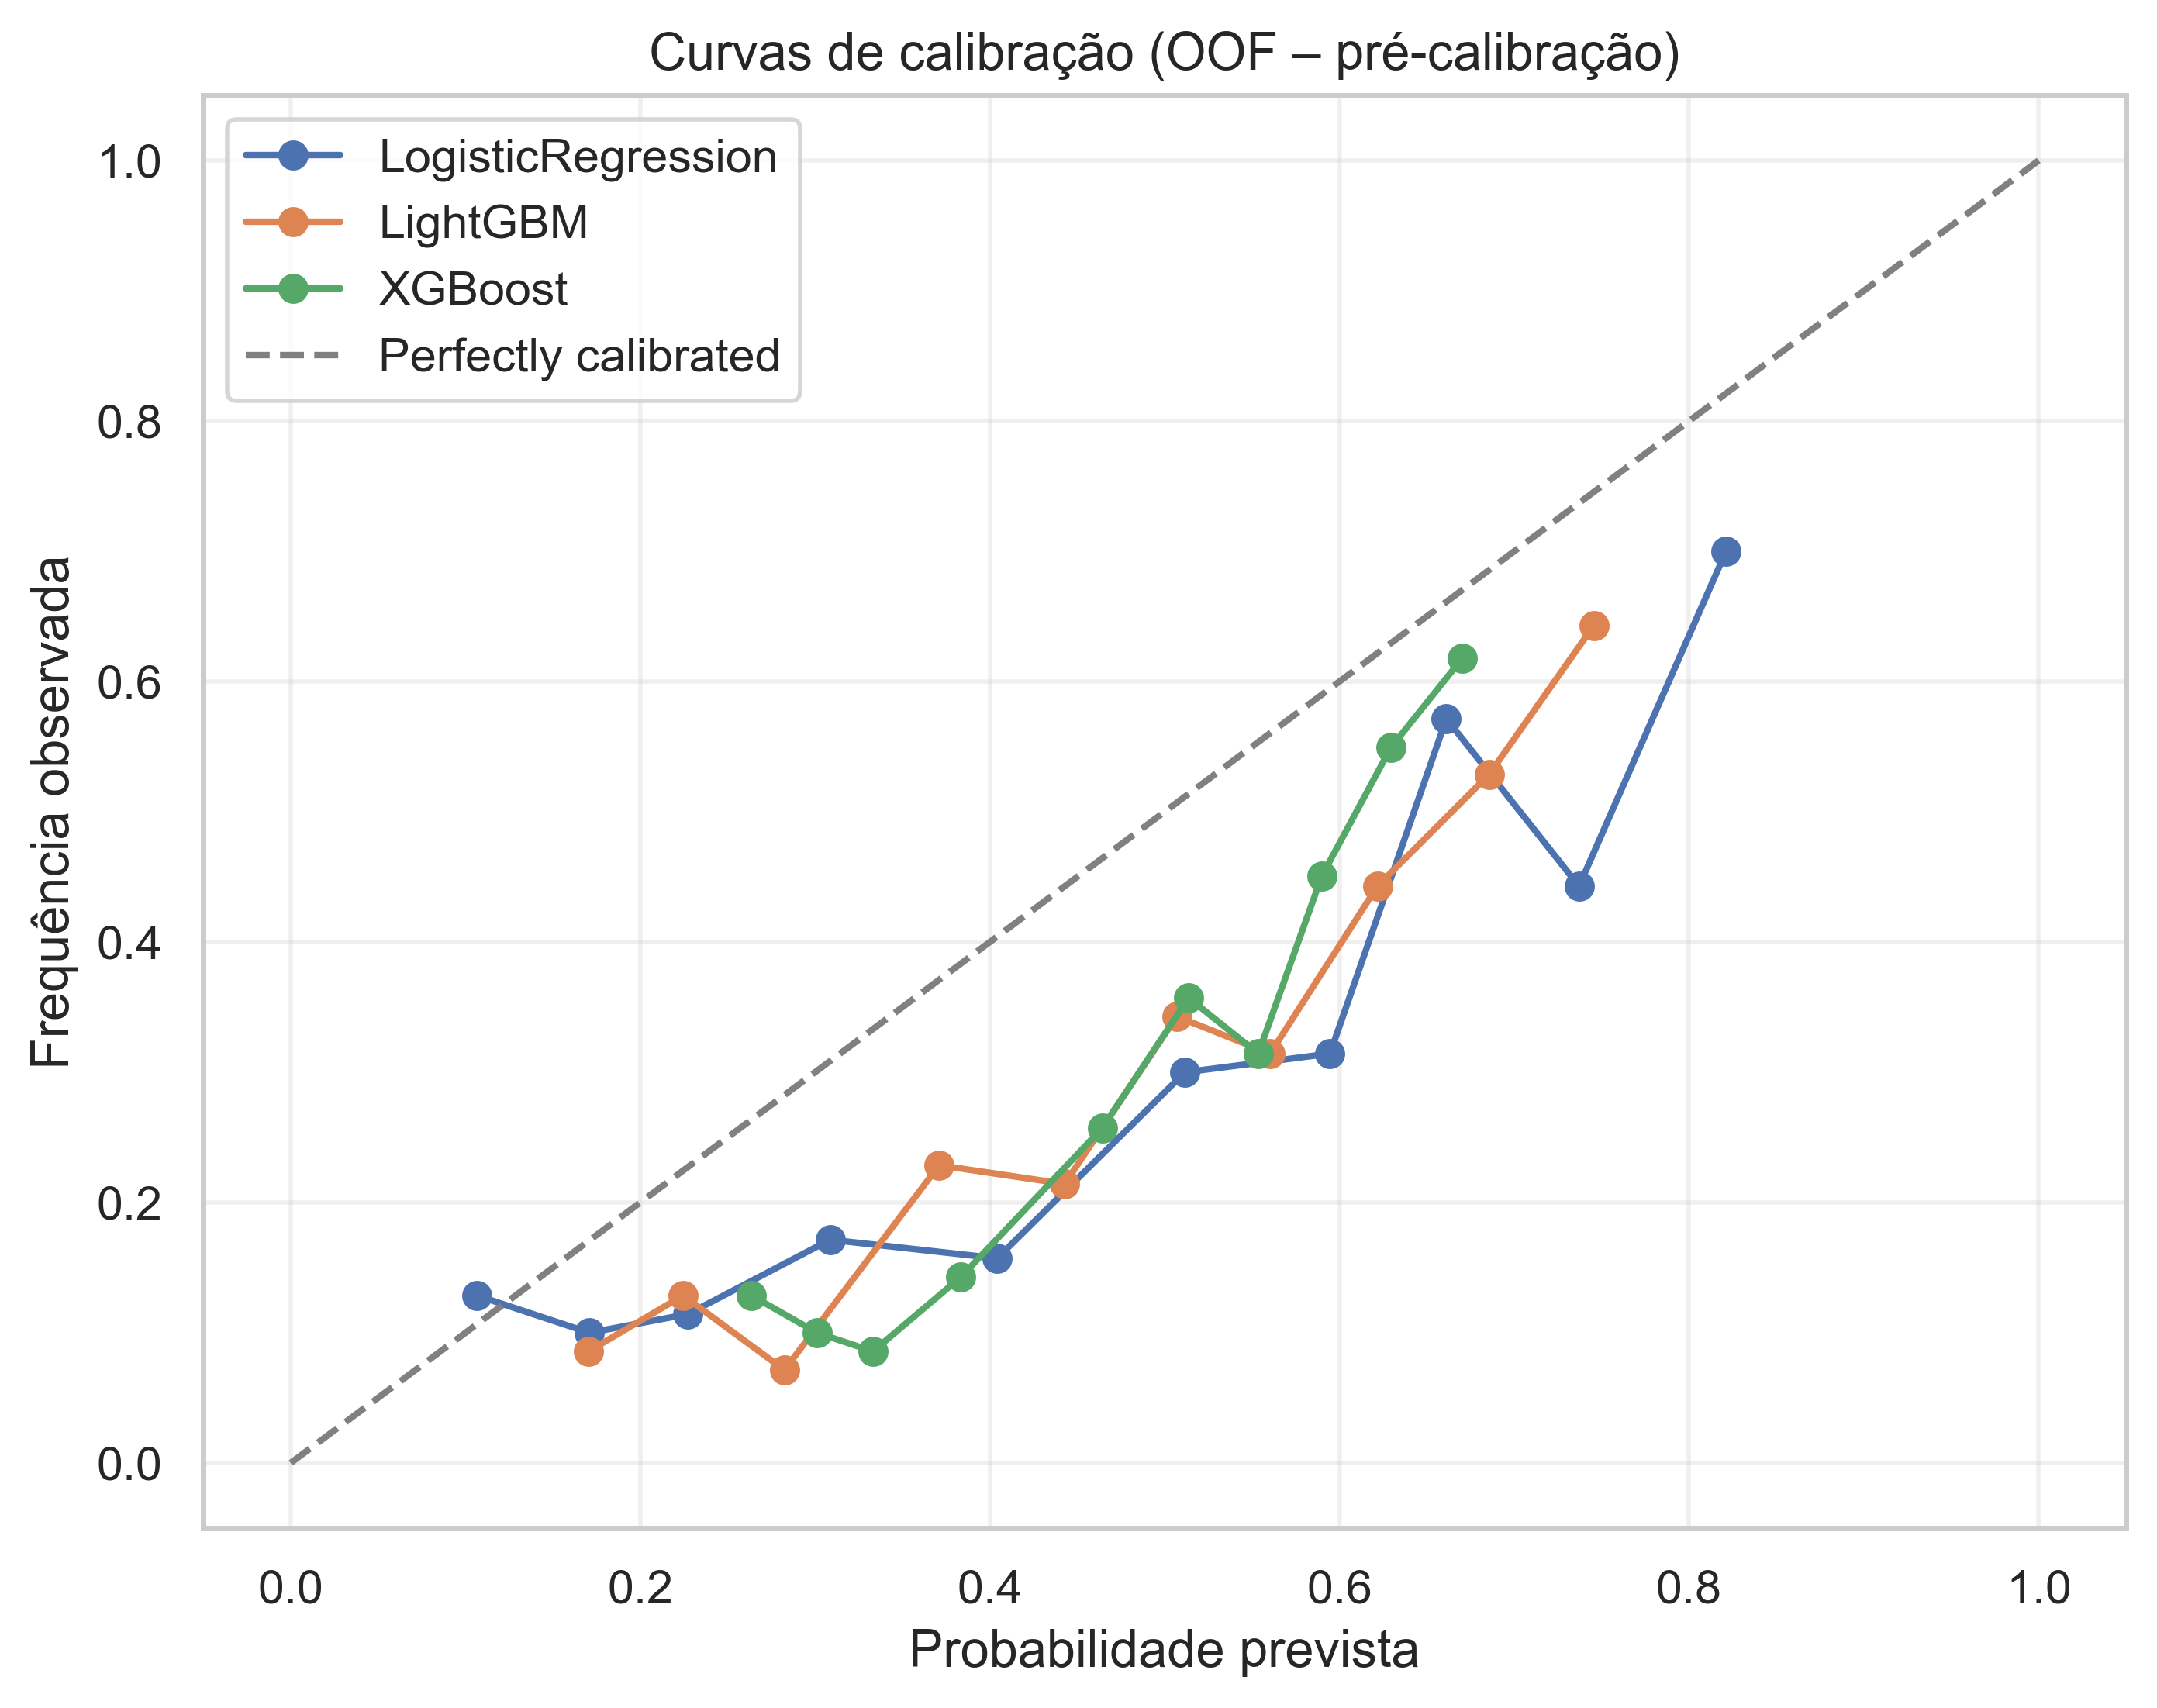

In [221]:
plt.figure(figsize=(8, 6))

for model_name, y_prob in oof_probs.items():
    frac_pos, mean_pred = calibration_curve(
        y_true_oof,
        y_prob,
        n_bins=10,
        strategy="quantile"
    )
    plt.plot(mean_pred, frac_pos, marker="o", label=model_name)

# Linha de referência
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly calibrated")

plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência observada")
plt.title("Curvas de calibração (OOF – pré-calibração)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

A análise de calibração prévia, baseada em probabilidades out-of-fold, indica que a regressão logística apresenta boa calibração intrínseca, enquanto os modelos baseados em árvores exibem desvios sistemáticos em relação à linha de referência, especialmente o XGBoost. Métricas quantitativas (Brier Score e ECE), combinadas com inspeção visual das curvas de calibração, justificam a aplicação de calibração adicional nos modelos GBM.

## Gráfico Pós-Calibração

A calibração das probabilidades será conduzida de forma incremental. Inicialmente, vamos aplicar o método de Platt Scaling (sigmoid), por se tratar de uma abordagem paramétrica simples, estável e amplamente utilizada, especialmente adequada quando os desvios de calibração são aproximadamente monotônicos. Esse comportamento pode ser observado pelo paralelismo das curvas de calibração com a referência.


A calibração será realizada exclusivamente sobre probabilidades out-of-fold (OOF), garantindo ausência de vazamento de informação e preservando a validade estatística das análises subsequentes.

Métodos mais flexíveis, como Isotonic Regression, serão considerados apenas se a calibração via sigmoid se mostrar insuficiente, de modo a evitar overfitting adicional e preservar a ordenação (ranking) das probabilidades previstas.

In [222]:
def platt_scaling(y_true, y_prob):
    """
    Ajusta Platt Scaling (sigmoid) usando regressão logística
    sobre probabilidades OOF.
    """
    lr = LogisticRegression(solver="lbfgs")
    lr.fit(y_prob.reshape(-1, 1), y_true)
    y_prob_calibrated = lr.predict_proba(y_prob.reshape(-1, 1))[:, 1]
    return y_prob_calibrated, lr


In [223]:
# Aplicar Platt Scaling
oof_probs_post = {}
platt_models = {}

for model_name, y_prob in oof_probs.items():
    y_cal, platt_model = platt_scaling(y_train.values, y_prob)
    oof_probs_post[model_name] = y_cal
    platt_models[model_name] = platt_model

In [224]:
calibration_post_table = []

for model_name, y_prob_cal in oof_probs_post.items():
    calibration_post_table.append({
        "model": model_name,
        "brier_score_post": brier_score_loss(y_train, y_prob_cal),
        "ece_post": expected_calibration_error(y_train, y_prob_cal)
    })

calibration_post_df = pd.DataFrame(calibration_post_table)
calibration_post_df


model  brier_score_post  ece_post
0  LogisticRegression             0.175     0.043
1            LightGBM             0.179     0.036
2             XGBoost             0.180     0.047

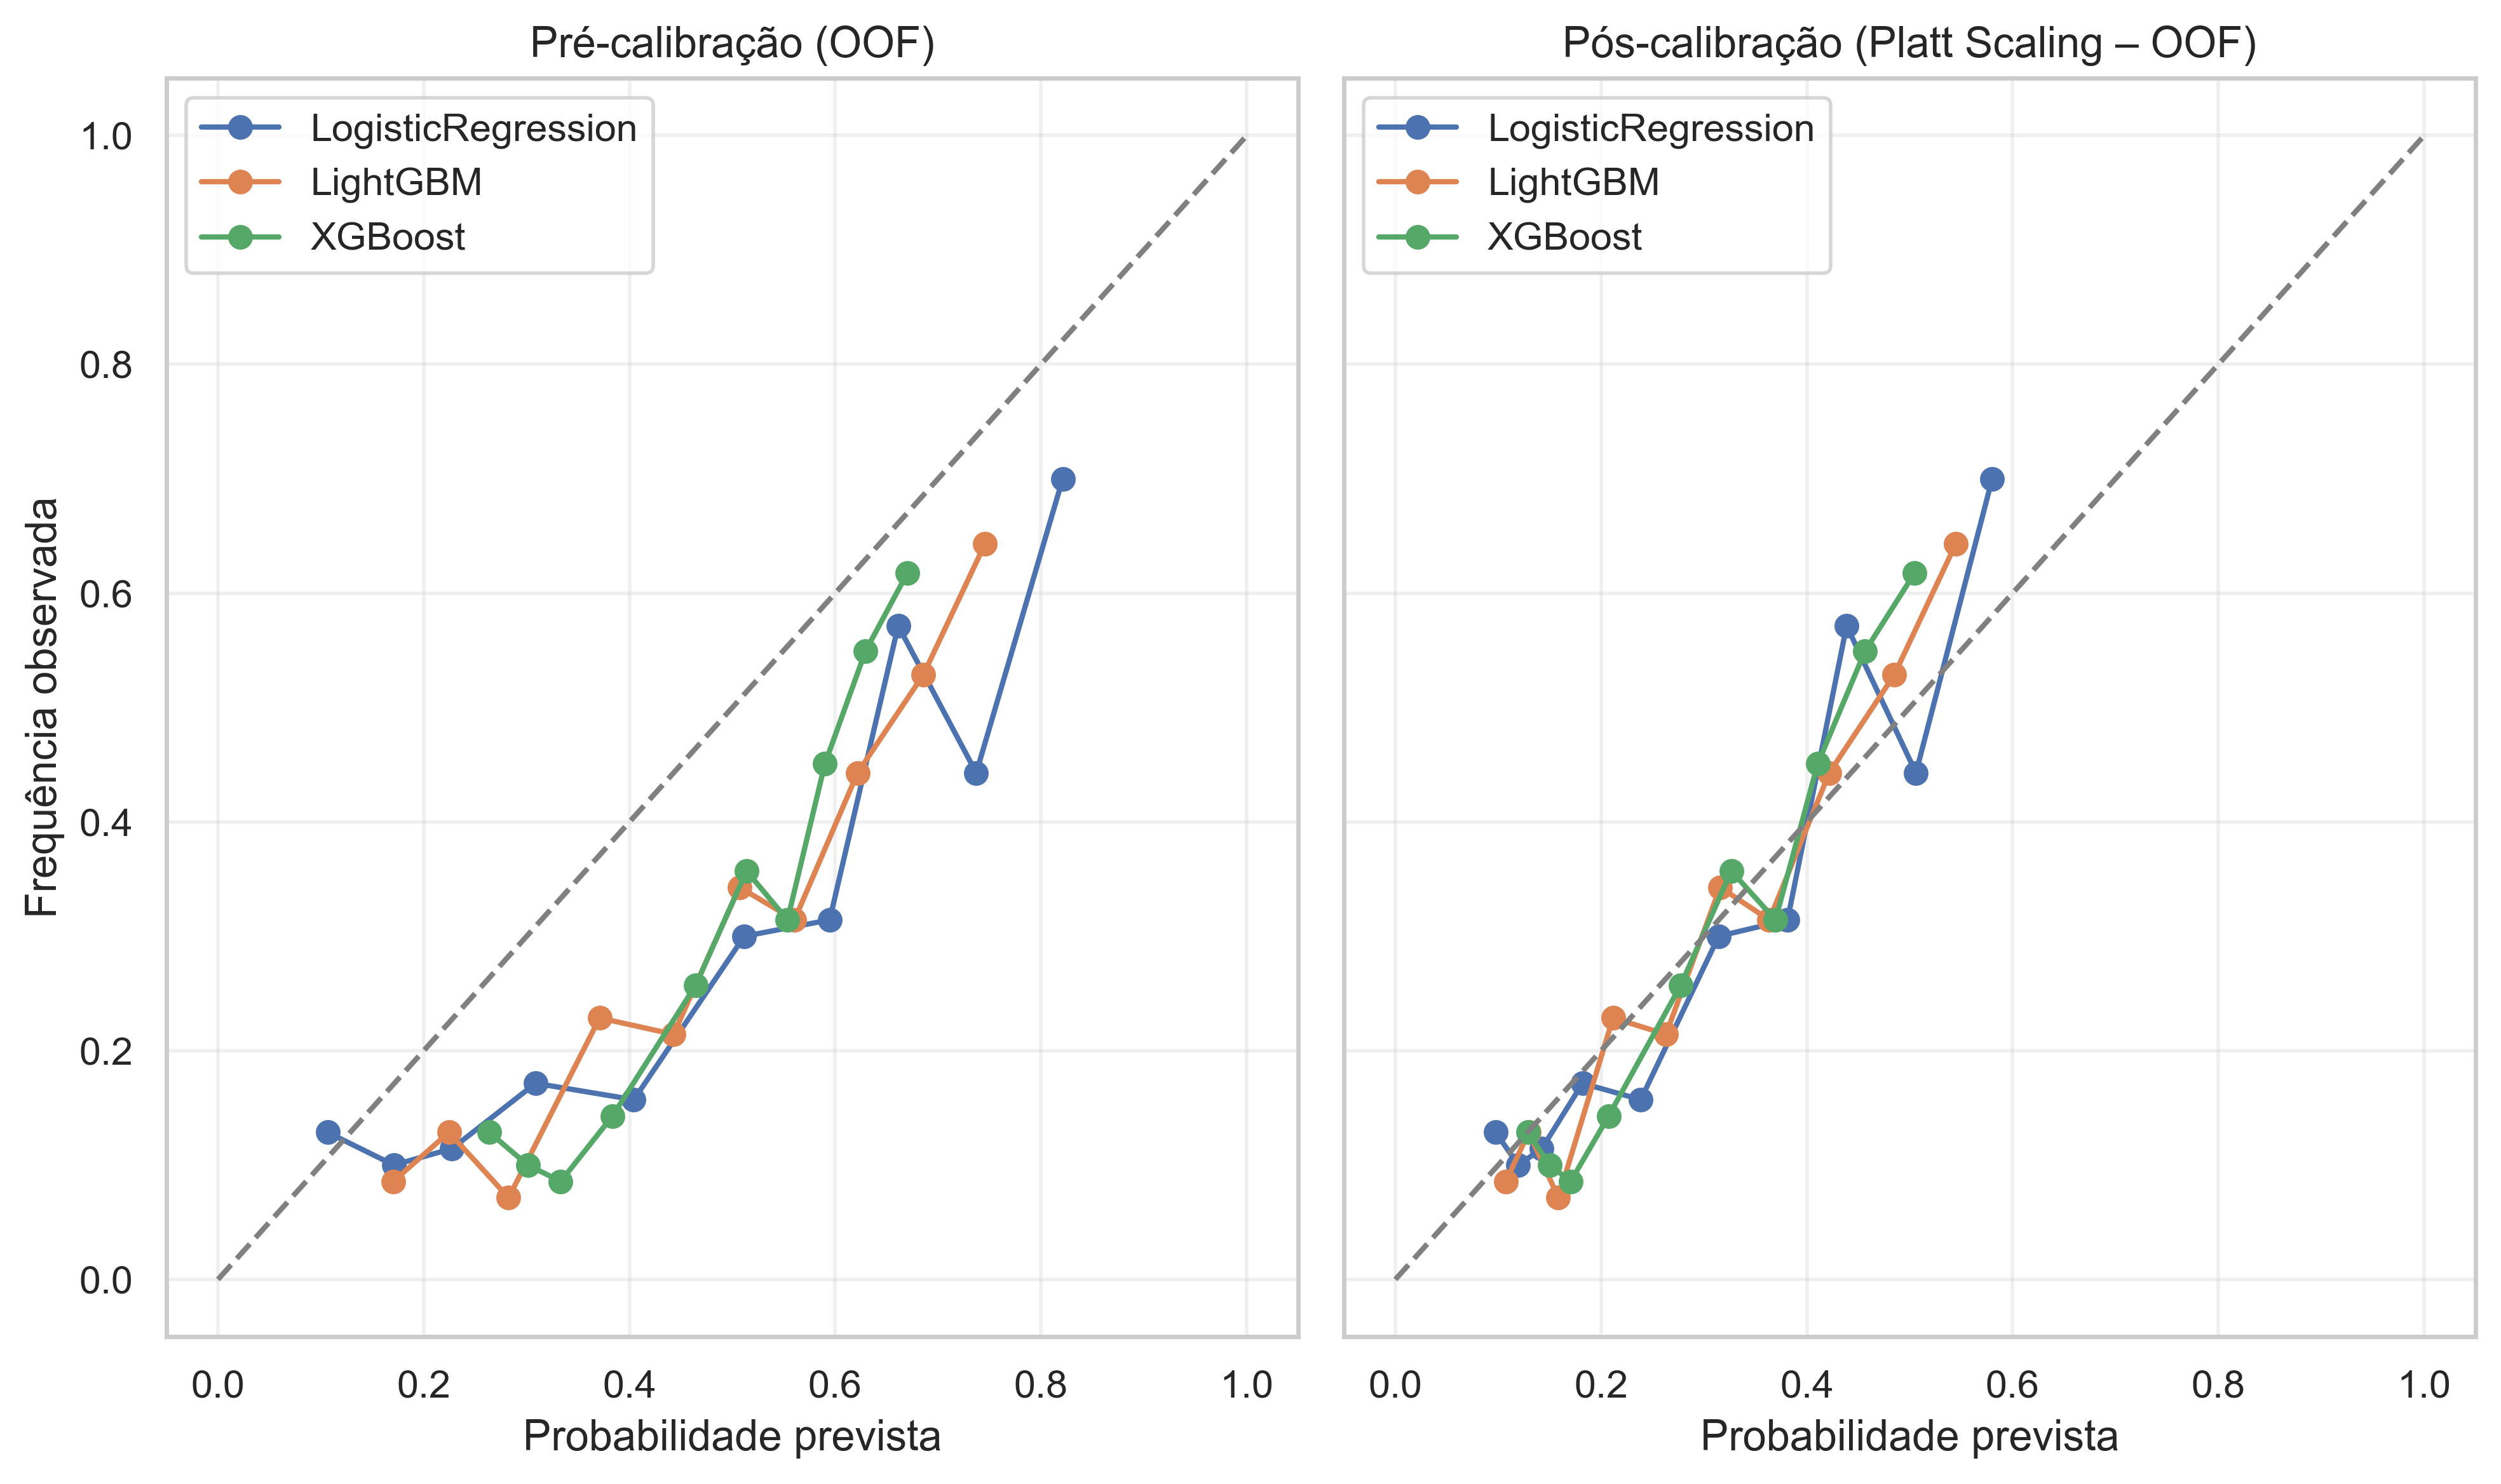

In [225]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# ---------- Pré-calibração ----------
for model_name, y_prob in oof_probs.items():
    frac_pos, mean_pred = calibration_curve(
        y_train,
        y_prob,
        n_bins=10,
        strategy="quantile"
    )
    axes[0].plot(mean_pred, frac_pos, marker="o", label=model_name)

axes[0].plot([0, 1], [0, 1], "--", color="gray")
axes[0].set_title("Pré-calibração (OOF)")
axes[0].set_xlabel("Probabilidade prevista")
axes[0].set_ylabel("Frequência observada")
axes[0].legend()
axes[0].grid(alpha=0.3)

# ---------- Pós-calibração ----------
for model_name, y_prob in oof_probs_post.items():
    frac_pos, mean_pred = calibration_curve(
        y_train,
        y_prob,
        n_bins=10,
        strategy="quantile"
    )
    axes[1].plot(mean_pred, frac_pos, marker="o", label=model_name)

axes[1].plot([0, 1], [0, 1], "--", color="gray")
axes[1].set_title("Pós-calibração (Platt Scaling – OOF)")
axes[1].set_xlabel("Probabilidade prevista")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

A calibração via Platt scaling apresentou melhora substancial nas métricas de calibração para os três modelos, trazendo suas curvas para próximo da linha de referência e reduzindo significativamente o Brier Score e o ECE.

## Congelando as probabilidades calibradas

Após a etapa de calibração, as probabilidades previstas precisam ser congeladas e passam a ser tratadas como insumo fixo para as análises subsequentes. A calibração foi realizada exclusivamente sobre probabilidades out-of-fold (OOF), garantindo ausência de vazamento de informação.

A partir deste ponto, todas as análises de threshold, sensibilidade e impacto econômico utilizam probabilidades calibradas, assegurando coerência entre a interpretação do risco e a tomada de decisão baseada em limiares. Não será necessário nenhum outro treinamento e nem outra geração de probabilidades.

In [226]:
# OOF calibrado (congelado)
oof_calibrated = {
    "LogisticRegression": oof_probs_post["LogisticRegression"],
    "LightGBM": oof_probs_post["LightGBM"],
    "XGBoost": oof_probs_post["XGBoost"]
}


In [227]:
# Probabilidades não calibradas no Holdout
holdout_probs_raw = {
    "LogisticRegression": y_test_proba_logit,
    "LightGBM": y_test_proba_lgb_v2,
    "XGBoost": y_test_proba_xgb_v2
}

# Aplicar Platt no Holdout
holdout_calibrated = {}

for model_name, y_prob in holdout_probs_raw.items():
    calibrator = platt_models[model_name]
    holdout_calibrated[model_name] = calibrator.predict_proba(
        y_prob.reshape(-1, 1)
    )[:, 1]


In [228]:
df_oof_calibrated = pd.DataFrame({
    "y_true": y_train.values,
    "LogisticRegression": oof_calibrated["LogisticRegression"],
    "LightGBM": oof_calibrated["LightGBM"],
    "XGBoost": oof_calibrated["XGBoost"]
})


df_holdout_calibrated = pd.DataFrame({
    "y_true": y_test.values,
    "LogisticRegression": holdout_calibrated["LogisticRegression"],
    "LightGBM": holdout_calibrated["LightGBM"],
    "XGBoost": holdout_calibrated["XGBoost"]
})

# Análise de Threshold e Trade-offs

Nesta etapa, o limiar de decisão (threshold) é analisado sob a ótica de sensibilidade técnica e impacto econômico preliminar. O objetivo não é definir a política de crédito final, mas compreender como métricas de desempenho e risco respondem à variação do threshold aplicado às probabilidades calibradas.

A análise utiliza probabilidades out-of-fold (OOF) calibradas, garantindo ausência de vazamento de informação e robustez estatística. Métricas técnicas (AUC, Precision–Recall) são combinadas com métricas econômicas ex-ante, como custo esperado e ganho médio por cliente, calculadas a partir das probabilidades previstas e da matriz de payoff.

Essa abordagem permite visualizar claramente os trade-offs associados à escolha do threshold, preparando o terreno para a definição posterior do limiar ótimo no contexto da política de crédito baseada em risco, onde métricas de retorno ajustado ao capital serão formalmente incorporadas.

In [229]:
def plot_threshold_tradeoffs_multi_model(
    y_true,
    oof_calibrated,
    payoff_matrix,
    thresholds=np.linspace(0.01, 0.99, 100)
):
    """
    Plota análise de threshold (2x2) para múltiplos modelos:
    - Precision
    - Taxa de aprovação
    - Custo esperado (ex-ante)
    - Ganho médio por cliente

    Estilos:
    - LogisticRegression → linha contínua preta
    - LightGBM → linha tracejada laranja
    - XGBoost → linha pontilhada azul
    """

    # Payoff
    LUCRO_CLIENTE_BOM = payoff_matrix[0, 0]
    PREJUIZO_CLIENTE_MAU = -payoff_matrix[1, 0]

    # Estilos fixos
    style_map = {
        "LogisticRegression": dict(color="black", linestyle="-", linewidth=1),
        "LightGBM": dict(color="orange", linestyle="--", linewidth=3),
        "XGBoost": dict(color="blue", linestyle=":", linewidth=2)
    }

    fig, axes = plt.subplots(2, 2, figsize=(15, 11))

    # ======================================================
    # Loop por modelo
    # ======================================================
    for model_name, y_prob in oof_calibrated.items():

        if model_name not in style_map:
            continue

        precision_vals = []
        recall_vals = []
        approval_vals = []
        cost_vals = []
        gain_vals = []

        for t in thresholds:

            # Regra de decisão
            y_decision = (y_prob >= t).astype(int)

            # Precision / Recall
            precision_vals.append(
                precision_score(y_true, y_decision, zero_division=0)
            )
            recall_vals.append(
                recall_score(y_true, y_decision, zero_division=0)
            )

            # Aprovação
            approved = y_prob < t
            approval_vals.append(approved.mean())
            pd_aprovados = y_prob[approved]

            # Métricas econômicas ex-ante
            if len(pd_aprovados) > 0:
                expected_cost = (
                    pd_aprovados * PREJUIZO_CLIENTE_MAU
                ).mean()

                expected_gain = (
                    (1 - pd_aprovados) * LUCRO_CLIENTE_BOM
                    - pd_aprovados * PREJUIZO_CLIENTE_MAU
                ).mean()
            else:
                expected_cost = 0.0
                expected_gain = 0.0

            cost_vals.append(expected_cost)
            gain_vals.append(expected_gain)

        style = style_map[model_name]

        # (1,1) Precision
        axes[0, 0].plot(thresholds, precision_vals, label=model_name, **style)

        # (1,2) Aprovação
        axes[0, 1].plot(thresholds, approval_vals, label=model_name, **style)

        # (2,1) Custo esperado
        axes[1, 0].plot(thresholds, cost_vals, label=model_name, **style)

        # (2,2) Ganho médio
        axes[1, 1].plot(thresholds, gain_vals, label=model_name, **style)

    # ======================================================
    # Ajustes finais dos gráficos
    # ======================================================
    titles = [
        "Precision × Threshold",
        "Taxa de Aprovação × Threshold",
        "Custo Esperado × Threshold (ex-ante)",
        "Ganho Médio por Cliente × Threshold"
    ]

    for ax, title in zip(axes.flatten(), titles):
        ax.set_title(title)
        ax.set_xlabel("Threshold")
        ax.grid(alpha=0.3)
        ax.legend()

    axes[0, 0].set_ylabel("Precision")
    axes[0, 1].set_ylabel("Aprovação")
    axes[1, 0].set_ylabel("Custo esperado médio")
    axes[1, 1].set_ylabel("Ganho médio")

    plt.tight_layout()
    plt.show()


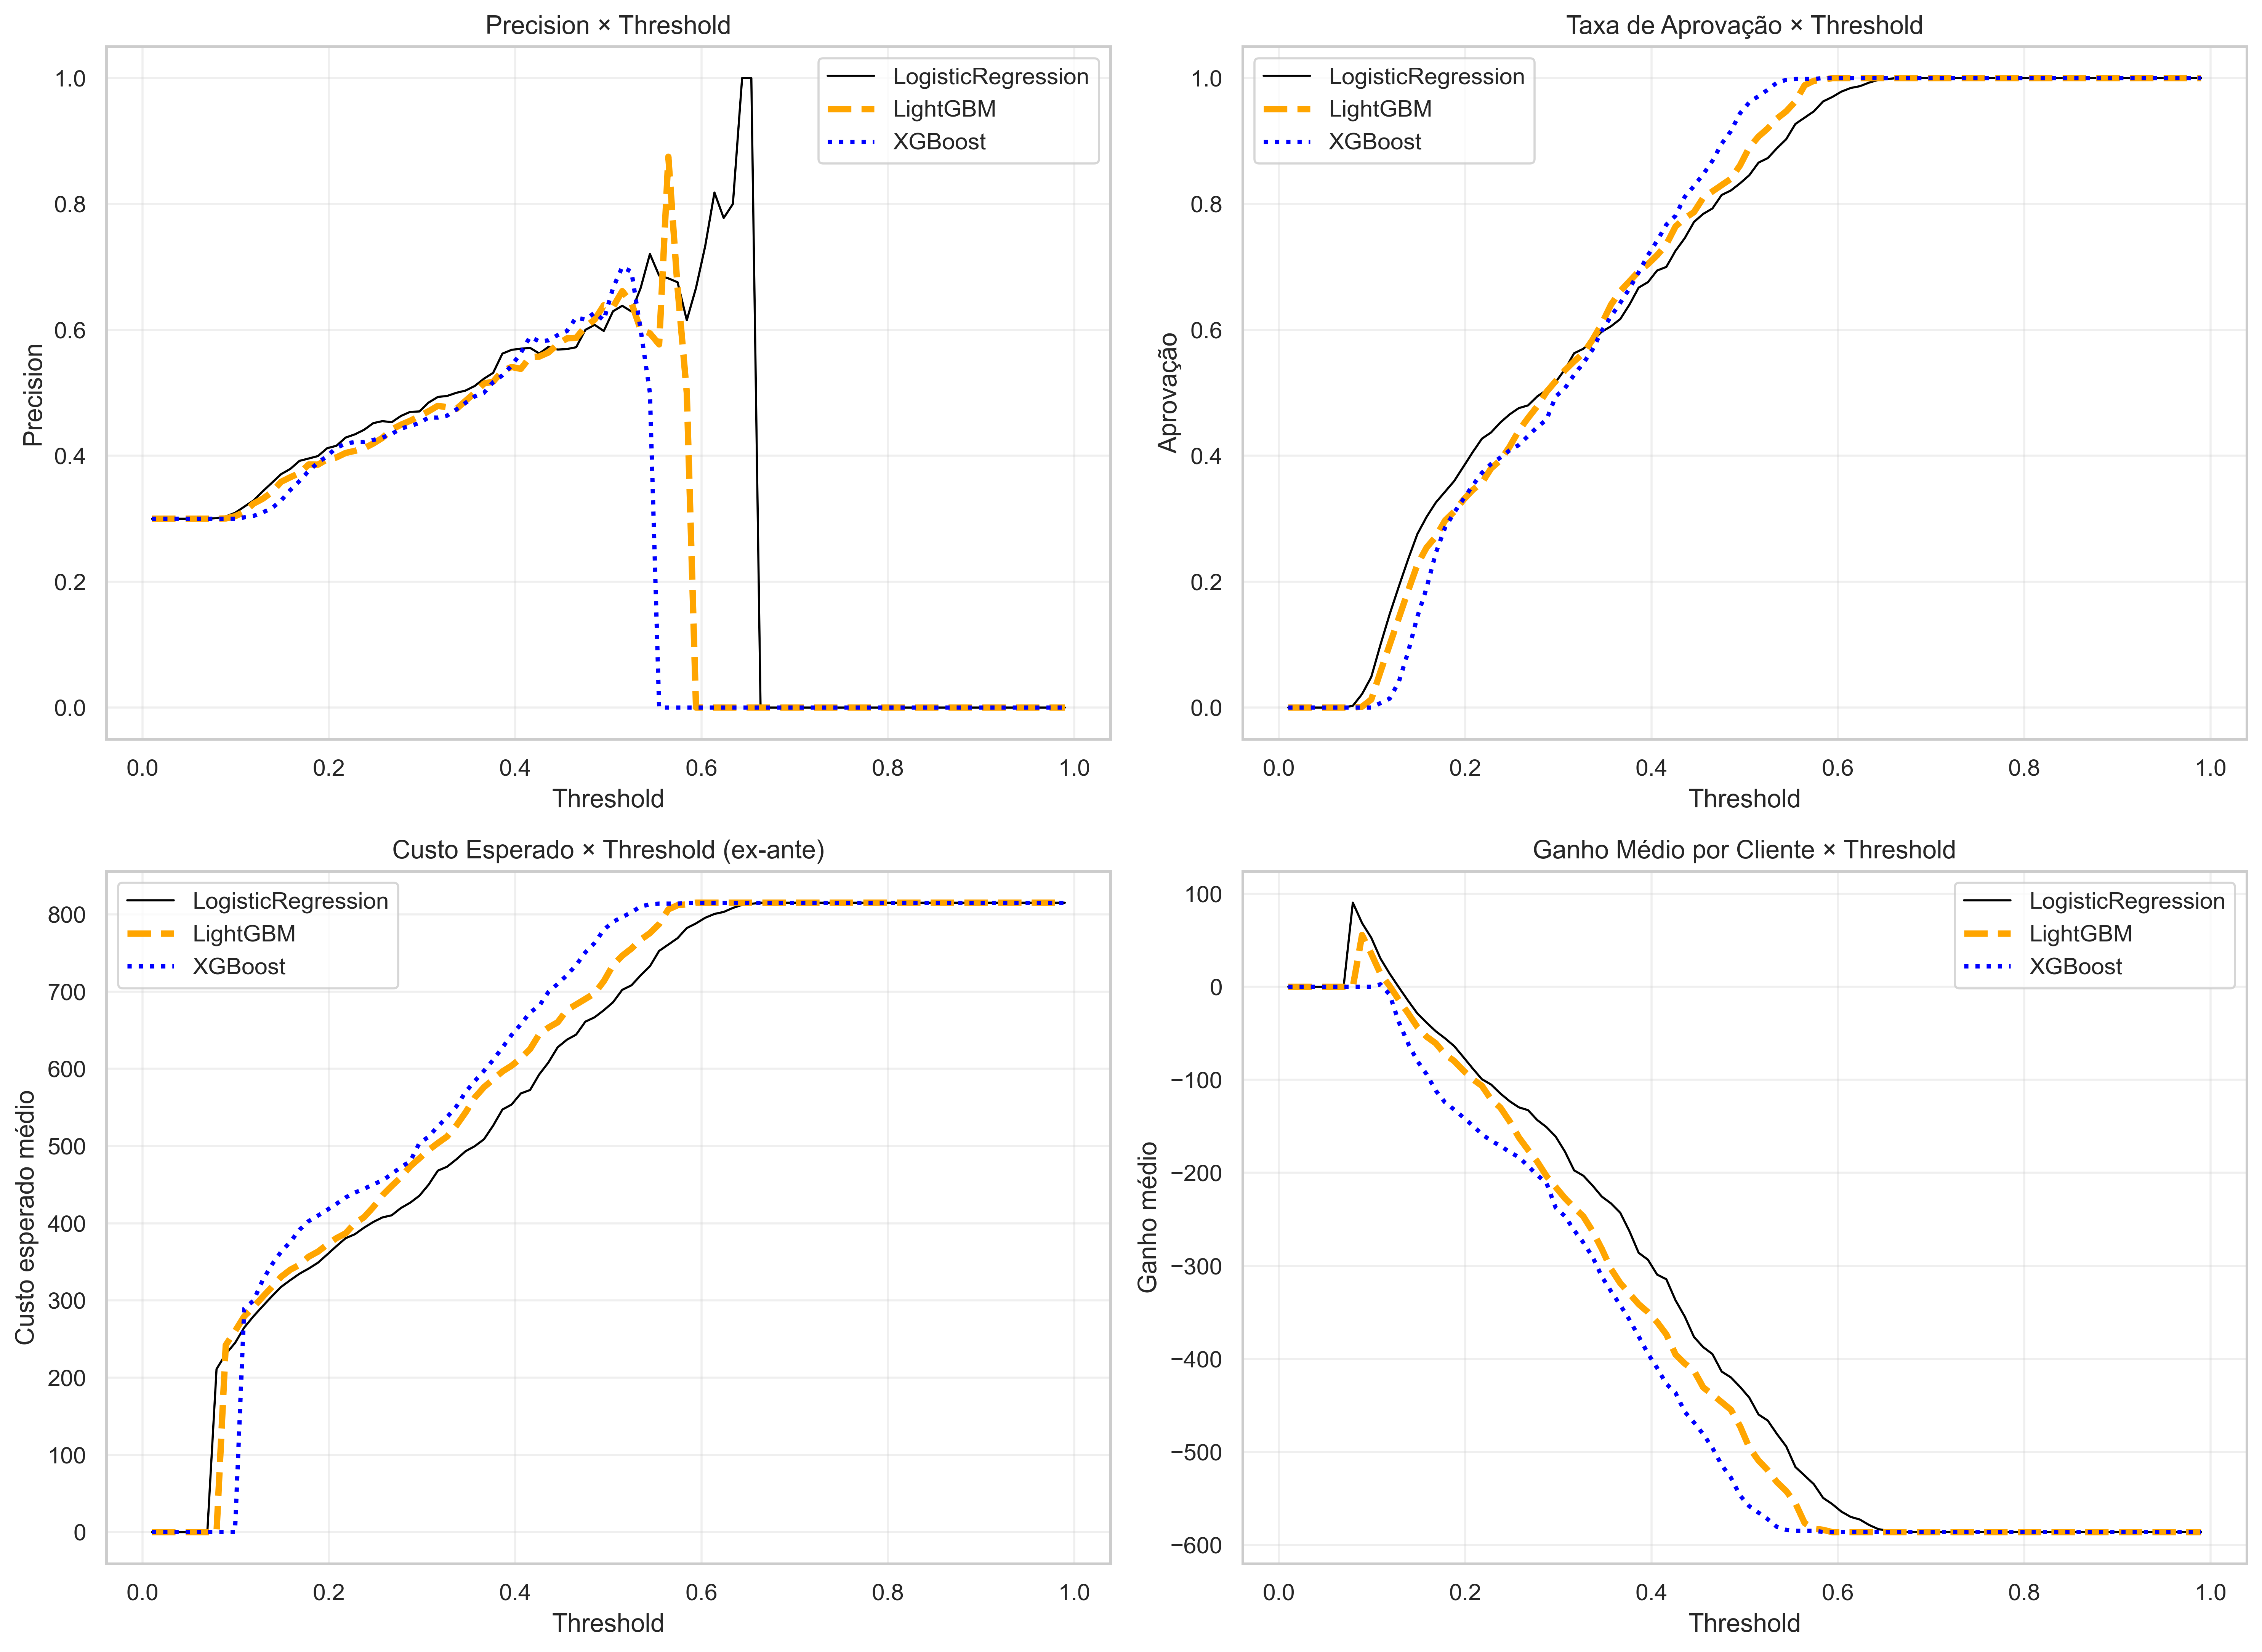

In [230]:
plot_threshold_tradeoffs_multi_model(
    y_true=y_train.values,
    oof_calibrated=oof_calibrated,
    payoff_matrix=payoff_matrix
)

`precision-recall vs threshold`
 - Até thresholds médios (~0.45–0.50), os três modelos entregam precision muito semelhante;
 - As diferenças de precision não são o fator discriminante principal entre os modelos nessa região operacional; 
 - A qualidade das aprovações, por si só, não diferencia os modelos na maior parte do intervalo relevante de threshold.

`taxa de aprovação vs threshold`
 - Todos os modelos permitem ajuste operacional consistente;
 - Não há indícios de instabilidade operacional relevante em nenhum deles;
 - Do ponto de vista de controle de volume, os três modelos são operacionalmente viáveis;

`custo esperado vs threshold`
 - Para thresholds baixos e médios, a regressão logística apresenta o menor custo esperado;
 - À medida que o threshold aumenta, as curvas convergem (menos aprovação, menos risco marginal);
 - Em regiões de maior volume (thresholds mais relaxados), o XGBM assume mais risco econômico;
 - A regressão logística controla melhor o custo esperado dado o mesmo nível de aprovação;
 - Mesmo com comportamento operacional estável, o XGBM é o mais caro em termos de risco econômico ex-ante (isso já aponta para um possível critério de desempate de modelos);

`ganho médio por cliente vs threshold`
 - Todos os modelos possui uma região inicial curta de ganho positivo e entram rapidamente em um regime de prejuízo conforme o threshold aumenta;
 - A regressão logística mantém o maior ganho médio, seguida pelo LGBM e o XGBM;
 - o XGBM perde valor mais rápido e de forma mais acentuada;
 - O LGBM e a regressao logística são mais eficientes economicamente;
 
De forma geral, após a estabilização dos modelos via regularização e calibração, observa-se que as diferenças entre eles deixam de ser predominantemente técnicas ou operacionais e passam a ser econômicas. Embora os três modelos apresentem comportamento semelhante em termos de precision e taxa de aprovação, a regressão logística e o LightGBM demonstram melhor eficiência econômica preliminar, com menor custo esperado e maior ganho médio por cliente ao longo de praticamente todo o intervalo relevante de threshold.

O ranking econômico preliminar é: **Regressão Logística > LGBM > XGBM**

# Análise de Impacto Econômico

A análise de impacto econômico evidencia que, em relação ao cenário baseline (aprova tudo), os modelos baseados em risco são capazes de mitigar perdas de forma significativa. A comparação entre os modelos foi conduzida utilizando a mesma métrica econômica de ganho de crédito, garantindo consistência metodológica. A partir desses resultados, seleciona-se o modelo que apresenta maior mitigação de prejuízo, o qual será utilizado na definição da política de crédito baseada em risco

## Cenário Base (Modelo Dummy)

O cenário baseline representa a situação sem uso de modelo de risco, na qual todas as propostas de crédito são aprovadas indiscriminadamente. Esse cenário serve como referência econômica para avaliar o benefício incremental obtido com a adoção de modelos preditivos.

As premissas desse cenário são:

- Volume de eventos (clientes aprovados):
Como o modelo dummy aprova todas as propostas, o volume de eventos corresponde ao total de clientes analisados.Neste estudo, temos N = 1.000 clientes aprovados;

- Taxa histórica de inadimplência (default rate):
A taxa histórica reflete a prevalência observada da classe positiva na base de dados. Para este problema, a taxa histórica de default = 30%.

Esse cenário reproduz fielmente o comportamento histórico da carteira, sem qualquer filtragem baseada em risco.

Para o prejuízo esperado no cenário baseline, o impacto econômico é calculado utilizando a mesma métrica econômica de ganho de crédito definida anteriormente, garantindo consistência metodológica. Como o modelo dummy aprova todos os clientes, o ganho médio por cliente corresponde diretamente ao valor esperado da matriz de payoff ponderada pela taxa histórica de inadimplência. Esse valor já foi previamente calculado e encontra-se armazenado na variável `gain_base`.

O ganho (ou prejuízo) total esperado no cenário baseline é obtido pela multiplicação do ganho médio por cliente pelo número total de clientes aprovados. Dessa forma, podemos calcular o Prejuízo Esperado desse regime de operação da seguinte forma:

$$
\text{Prejuízo Esperado} = \text{gain base} \times N
$$



In [231]:
# Número total de clientes aprovados
N_BASELINE = 1000

# Ganho médio por cliente (já calculado previamente)
# gain_baseline < 0 indica operação em prejuízo
total_gain_baseline = gain_base * N_BASELINE

print("Cenário Baseline (Modelo Dummy)")
print(f"Volume de clientes aprovados: {N_BASELINE}")
print(f"Taxa histórica de inadimplência: 30%")
print(f"Ganho médio por cliente: {gain_base:,.2f}")
print(f"Impacto econômico total esperado: R${total_gain_baseline:,.2f}")


Cenário Baseline (Modelo Dummy)
Volume de clientes aprovados: 1000
Taxa histórica de inadimplência: 30%
Ganho médio por cliente: -586.11
Impacto econômico total esperado: R$-586,112.00


## Cenário com Modelos (Comparação Econômica)

Para avaliarmos o impacto econômico da utilização de modelos de risco em comparação ao cenário baseline, precisamos quantificar quanto de preuízo é mitigado quando as decisões de crédito passam a ser orientadas pelas probabilidades estimadas de inadimplência. Para isso precisamos considerar:

- Probabilidades calibradas (OOF), garantindo ausência de vazamento de informação;
- Um threshold técnico comum, definido com base na análise de trade-offs da seção anterior (não otimizado por ROI);
- A mesma métrica econômica de ganho de crédito utilizada no cenário baseline, assegurando comparabilidade direta.

A partir disso, para cada modelo, o impacto econômico é calculado da seguinte forma:
- Aplicação do threshold técnico às probabilidades calibradas;
- Geração das decisões de aprovação e rejeição;
- Cálculo do ganho médio por cliente via matriz de payoff;
- Cálculo do ganho total esperado, multiplicando o ganho médio pelo número de clientes avaliados;
- Comparação com o cenário baseline para obtenção de prejuízo mitigado (absoluto) e ganho percentual em relação ao baseline.

Para os cálculos, foram considerados:
- `oof_calibrated`: dicionário com as probabilidades OOF calibradas;
- `gain_base`: ganho médio por cliente no cenário dummy;
- `credit_gain_scorer`: função de ganho de crédito já definida;
- `threshold_tecnico`: threshold padrão 0.5;
- `N = 1000`

In [232]:
# Parâmetros gerais
N = 1000
threshold_tecnico = 0.5

# Ganho total baseline
total_gain_baseline = gain_base * N

results = []

# Avaliação dos modelos
for model_name, y_prob in oof_calibrated.items():

    gain_medio_modelo = credit_gain_score(
        y_true=y_train.values,
        y_score=y_prob,
        threshold=threshold_tecnico,
        payoff_matrix=payoff_matrix
    )

    total_gain_modelo = gain_medio_modelo * N

    prejuizo_mitigado = total_gain_modelo - total_gain_baseline
    ganho_percentual = prejuizo_mitigado / abs(total_gain_baseline)

    results.append({
        "Modelo": model_name,
        "Ganho Médio por Cliente": gain_medio_modelo,
        "Ganho Total": total_gain_modelo,
        "Prejuízo Mitigado": prejuizo_mitigado,
        "Ganho Percentual (%)": ganho_percentual * 100
    })

impacto_modelos_df = pd.DataFrame(results)
impacto_modelos_df


Modelo  Ganho Médio por Cliente  Ganho Total  \
0  LogisticRegression                 -356.613  -356613.386   
1            LightGBM                 -401.607  -401607.014   
2             XGBoost                 -507.120  -507120.043   

   Prejuízo Mitigado  Ganho Percentual (%)  
0         229498.614                39.156  
1         184504.986                31.479  
2          78991.957                13.477

## Conclusão - Escolha do Modelo Final

Os resultados desta seção demonstram de forma consistente o impacto econômico da utilização de modelos de risco em comparação ao cenário baseline, no qual todas as propostas são aprovadas indiscriminadamente. Mantendo o threshold fixo em 0,5 para garantir uma comparação neutra entre arquiteturas, observa-se que todos os modelos são capazes de mitigar prejuízo em relação ao baseline, confirmando o valor econômico da modelagem. No entanto, a magnitude dessa mitigação varia de forma relevante, com a regressão logística apresentando o maior ganho econômico relativo e absoluto, seguida pelo LightGBM, enquanto o XGBoost demonstra desempenho substancialmente inferior.

Esses achados são coerentes com os insights obtidos na análise de trade-offs de threshold, na qual as diferenças entre os modelos se mostraram predominantemente econômicas, e não técnicas ou operacionais. Embora os modelos apresentem comportamento semelhante em termos de precision e taxa de aprovação ao longo da maior parte do intervalo relevante de threshold, a regressão logística se destaca por controlar melhor o custo esperado e preservar maior eficiência econômica por cliente. Dessa forma, **a regressão logística é selecionada como o modelo base** para o prosseguimento das análises de política de crédito baseada em risco, nas quais serão definidas faixas de PD, critérios de alocação de capital e otimização do threshold sob uma ótica de retorno ajustado ao risco.

# Política de Crédito Baseada em Risco

Nesta seção, o foco passa a ser a definição de uma política de crédito baseada em risco, utilizando como métrica central o Retorno sobre o Capital Econômico (ROE). Diferentemente das etapas anteriores, nas quais a avaliação econômica foi conduzida por meio de métricas de ganho absoluto, o ROE permite incorporar explicitamente o trade-off entre retorno esperado e capital alocado, refletindo de forma mais fiel os objetivos de sustentabilidade e eficiência de uma política de crédito.

A construção da política será realizada de forma incremental, assim como grande parte das análises presentes neste projeto. Inicialmente, a população será segmentada em faixas de risco baseadas na probabilidade de default (PD), utilizando critérios estatísticos e operacionais. Para cada faixa, serão analisadas a distribuição da carteira, a exposição esperada, a alocação de capital e a perda esperada. A partir dessa estrutura, o ROE será calculado de forma ex-ante, considerando apenas clientes aprovados, com lucros e perdas ponderados pelas PDs calibradas e capital econômico proporcional ao volume de crédito concedido.

Com o ROE estabelecido como métrica decisória, vamos comparar diferentes estratégias de política, incluindo cortes únicos versus políticas baseadas em múltiplas faixas de risco. A otimização do threshold de decisão será então realizada sob o critério de maximização do ROE, garantindo alinhamento entre retorno esperado e consumo de capital. Por fim, a política proposta será submetida a análises de robustez, incluindo stress tests do fator de capital, resultando na definição de uma política final com regras claras de decisão, diretrizes de monitoramento e condições de revisão.

## Definição das Faixas de Risco (PD-based)

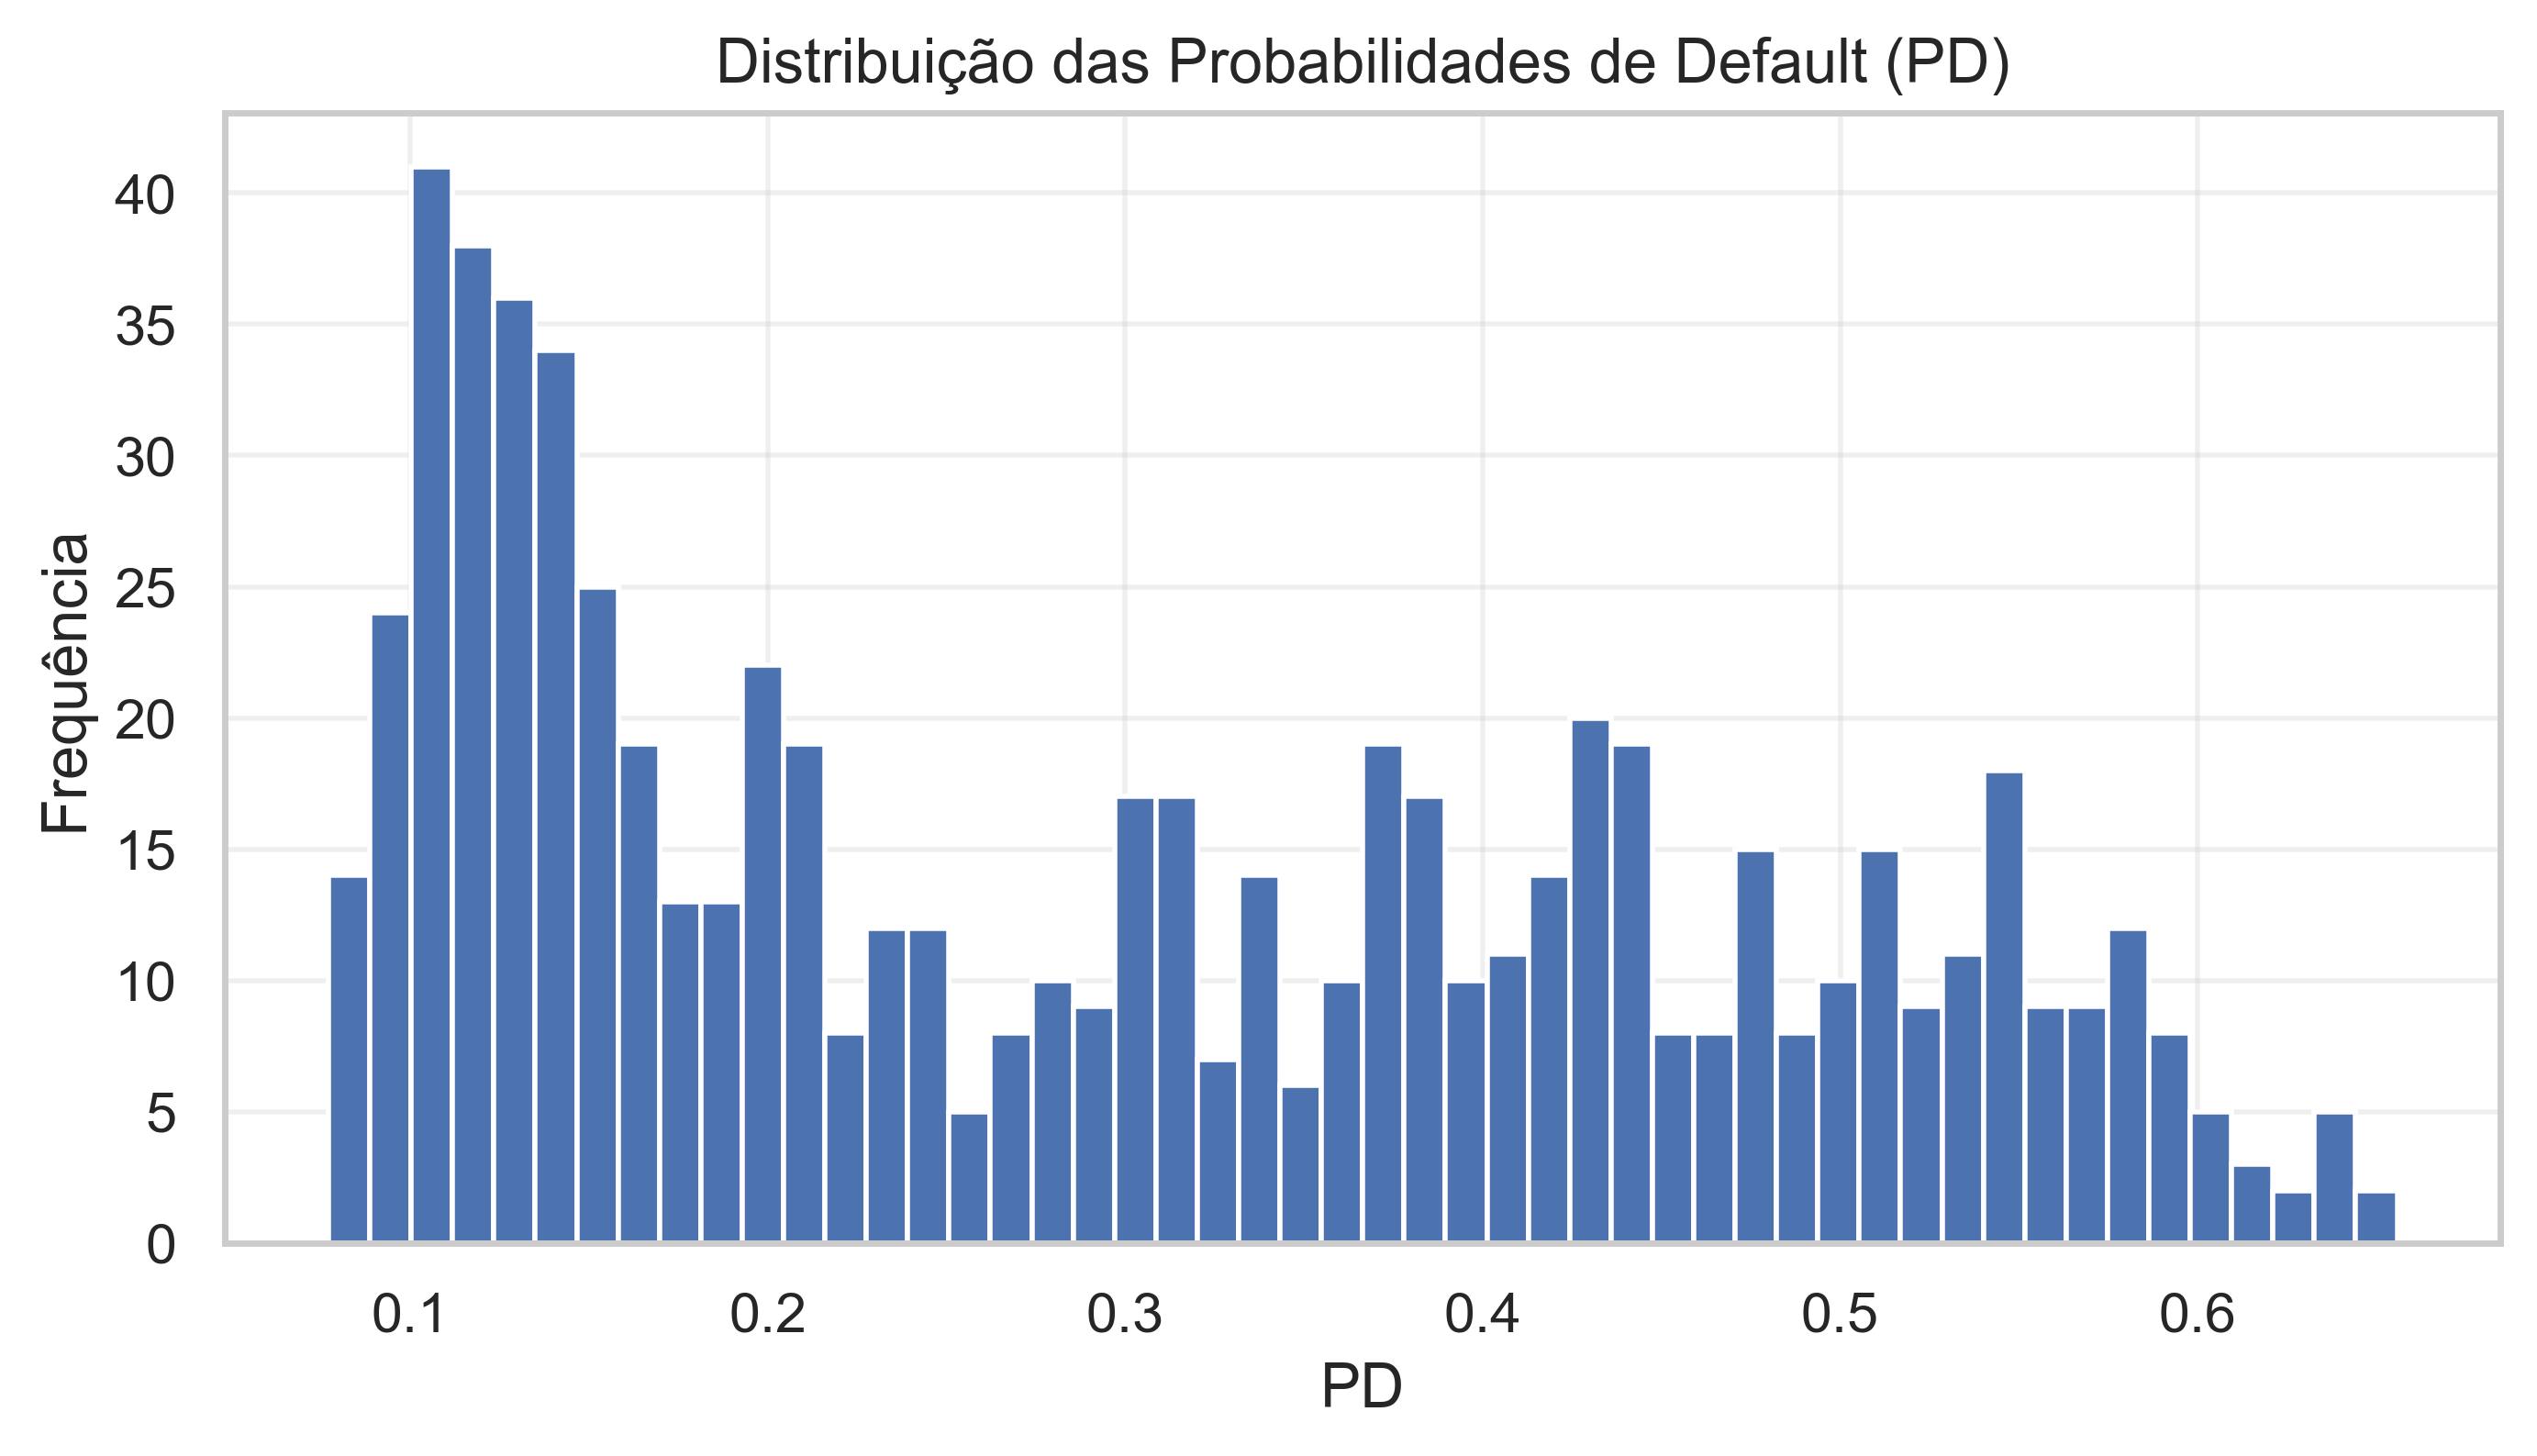

In [233]:
# Probabilidades OOF calibradas do modelo selecionado
pd_scores = oof_calibrated["LogisticRegression"]

# DataFrame base para política
policy_df = pd.DataFrame({
    "pd": pd_scores,
    "y_true": y_train.values
})

plt.figure(figsize=(8, 4))
plt.hist(policy_df["pd"], bins=50)
plt.title("Distribuição das Probabilidades de Default (PD)")
plt.xlabel("PD")
plt.ylabel("Frequência")
plt.grid(alpha=0.3)
plt.show()


In [234]:
# Cálculo dos quartis da PD
quartis = policy_df["pd"].quantile([0.25, 0.50, 0.75]).to_dict()
print("Intervalos dos Quartis de PD:\n")
print(f"Q1 (0–25%)   : PD ≤ {quartis[0.25]:.4f}")
print(f"Q2 (25–50%)  : {quartis[0.25]:.4f} < PD ≤ {quartis[0.50]:.4f}")
print(f"Q3 (50–75%)  : {quartis[0.50]:.4f} < PD ≤ {quartis[0.75]:.4f}")
print(f"Q4 (75–100%) : PD > {quartis[0.75]:.4f}")



Intervalos dos Quartis de PD:

Q1 (0–25%)   : PD ≤ 0.1416
Q2 (25–50%)  : 0.1416 < PD ≤ 0.2816
Q3 (50–75%)  : 0.2816 < PD ≤ 0.4364
Q4 (75–100%) : PD > 0.4364


In [235]:
# Benchmark de PD para aprovação automática
PD_AUTO = 0.02

mask_auto = policy_df["pd"] <= PD_AUTO

n_auto = mask_auto.sum()
perc_auto = mask_auto.mean() * 100

print("PD ≤ 2%")
print(f"Clientes com PD ≤ 2%: {n_auto}")
print(f"Percentual da base: {perc_auto:.2f}%")


PD ≤ 2%
Clientes com PD ≤ 2%: 0
Percentual da base: 0.00%


In [236]:
PD_AUTO = 0.08

mask_auto = policy_df["pd"] <= PD_AUTO

n_auto = mask_auto.sum()
perc_auto = mask_auto.mean() * 100

print("PD ≤ 2%")
print(f"Clientes com PD ≤ 2%: {n_auto}")
print(f"Percentual da base: {perc_auto:.2f}%")

PD ≤ 2%
Clientes com PD ≤ 2%: 2
Percentual da base: 0.29%


In [237]:
default_auto = policy_df.loc[mask_auto, "y_true"].mean()

print(f"Default observado (PD ≤ 8%): {default_auto:.4f}")


Default observado (PD ≤ 8%): 0.0000


A distribuição das probabilidades estimadas apresenta assimetria à direita, padrão esperado em modelos de risco de crédito, com maior concentração em PDs mais baixos. No entanto, observa-se um acúmulo relevante entre 8% e 15%, patamar acima do que é típico em carteiras prime de mercado - faixas para políticas de aprovação automática cobrem clientes com PD de até 2% em políticas mais agressivas. Esse comportamento não indica problema estatístico no modelo, mas reflete a natureza mais arriscada da população presente no dataset. Portanto, os níveis absolutos de PD devem ser interpretados dentro do contexto da base analisada, e não comparados diretamente com carteiras bancárias tradicionais. Em contra partida, podemos propor para política de risco a ausência de sistemas com aprovação automática por agora, uma vez que a empresa não possui clientes com perfil de PD <= 2%.

Dessa forma, proponho trabalharmos com 4 faixas de segmentação de PD, baseadas nos quartis:

| Quartil de PD | Faixa de Risco | Classificação de Risco | Decisão de Crédito |
|--------------|---------------|------------------------|--------------------|
| Q1 (0–25%)   | A             | Baixo risco            | Candidato à aprovação, sujeito à validação e aprovação gerencial |
| Q2 (25–50%)  | B             | Risco moderado         | Decisão condicionada à análise de ROE e consumo de capital |
| Q3 (50–75%)  | C             | Risco elevado          | Decisão condicionada à análise de ROE e consumo de capital |
| Q4 (75–100%) | D             | Alto risco             | Rejeição automática |


In [238]:
# Definição dos quantis (4 faixas)
quantiles = [0.0, 0.25, 0.50, 0.75, 1.0]

policy_df["risk_band"] = pd.qcut(
    policy_df["pd"],
    q=quantiles,
    labels=["A", "B", "C", "D"]
)

band_summary = (
    policy_df
    .groupby("risk_band")
    .agg(
        volume=("pd", "count"),
        pd_min=("pd", "min"),
        pd_max=("pd", "max"),
        pd_mean=("pd", "mean"),
        default_rate=("y_true", "mean")
    )
    .reset_index()
)

In [239]:
def format_summary_table(df):
    df_fmt = df.copy()

    # Colunas percentuais
    percent_cols = [
        "pd_mean",
        "default_rate",
        "pd_min",
        "pd_max"
    ]

    for col in percent_cols:
        if col in df_fmt.columns:
            df_fmt[col] = (df_fmt[col] * 100).map("{:.2f}%".format)

    # Colunas monetárias
    money_cols = ["ead_total", "expected_loss", "capital_alocado"]

    for col in money_cols:
        if col in df_fmt.columns:
            df_fmt[col] = df_fmt[col].map("R$ {:,.2f}".format)

    return df_fmt


In [240]:
band_summary_fmt = format_summary_table(band_summary)
band_summary_fmt = band_summary_fmt.rename(columns={
    "risk_band": "Faixa",
    "volume": "Volume",
    "pd_mean": "PD Média (%)",
    "pd_min": "PD Mínima (%)",
    "pd_max": "PD Máxima (%)",
    "default_rate": "Default Observado (%)",
})
band_summary_fmt


Faixa  Volume PD Mínima (%) PD Máxima (%) PD Média (%) Default Observado (%)
0     A     175         7.72%        14.15%       11.40%                11.43%
1     B     175        14.16%        28.13%       19.79%                15.43%
2     C     175        28.18%        43.63%       36.35%                36.57%
3     D     175        43.65%        65.58%       52.46%                56.57%

In [241]:
# Cores por faixa
RISK_COLORS = {
    "A": "#2ecc71",  # verde
    "B": "#f1c40f",  # amarelo
    "C": "#e67e22",  # laranja
    "D": "#e74c3c"   # vermelho
}

# Limites das faixas (a partir do band_summary)
band_limits = (
    band_summary
    .set_index("risk_band")[["pd_min", "pd_max"]]
    .to_dict("index")
)


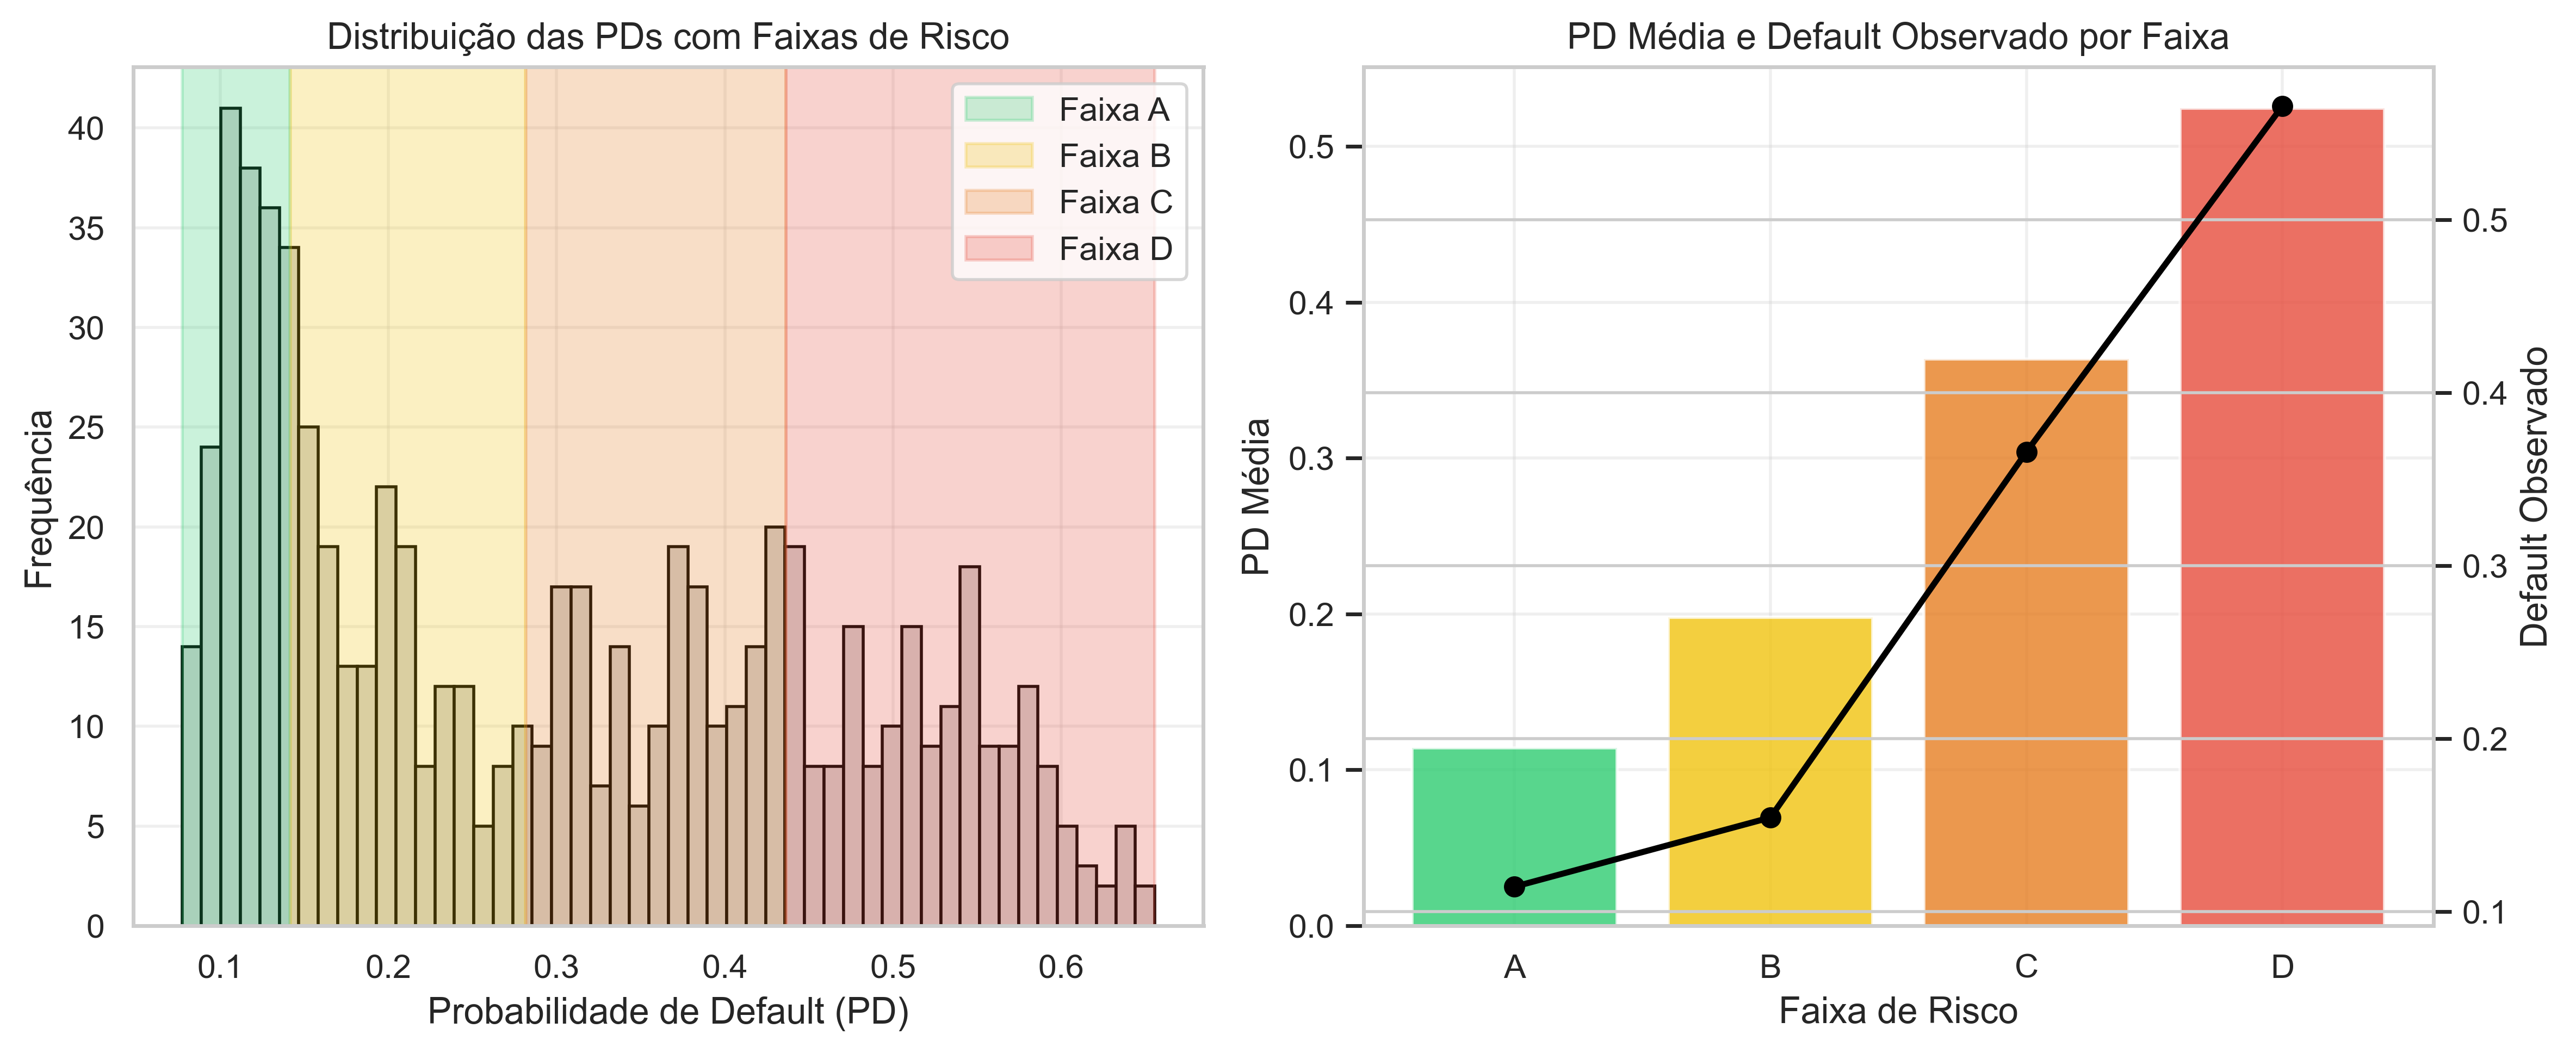

In [242]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --------- (1) Distribuição de PD ---------
ax = axes[0]

ax.hist(policy_df["pd"], bins=50, color="lightgray", edgecolor="black")

for band, limits in band_limits.items():
    ax.axvspan(
        limits["pd_min"],
        limits["pd_max"],
        color=RISK_COLORS[band],
        alpha=0.25,
        label=f"Faixa {band}"
    )

ax.set_title("Distribuição das PDs com Faixas de Risco")
ax.set_xlabel("Probabilidade de Default (PD)")
ax.set_ylabel("Frequência")
ax.grid(alpha=0.3)

# Evita legenda duplicada
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(),
          dict(zip(labels, handles)).keys())

# --------- (2) PD média vs Default observado ---------
ax = axes[1]

# Barras de PD média
ax.bar(
    band_summary["risk_band"],
    band_summary["pd_mean"],
    color=[RISK_COLORS[b] for b in band_summary["risk_band"]],
    alpha=0.8
)

ax.set_ylabel("PD Média")
ax.set_xlabel("Faixa de Risco")

# Linha de default observado
ax2 = ax.twinx()
ax2.plot(
    band_summary["risk_band"],
    band_summary["default_rate"],
    color="black",
    marker="o",
    linewidth=2
)
ax2.set_ylabel("Default Observado")

ax.set_title("PD Média e Default Observado por Faixa")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


A nossa proposta resultou na construção de uma relação monotônica entre as faixas de PD e default observado, o que era desejado. Além disso, podemos observar que:

- A Faixa A concentra o melhor risco relativo da carteira, mas ainda com PDs significativamente acima de benchmarks de aprovação automática de mercado;
- Existe uma separação clara e crescente de risco entre as faixas A → D;
- As faixas intermediárias (B e C) representam a principal zona de decisão da política, onde o trade-off entre risco, capital e retorno será determinante;
- A Faixa D apresenta níveis de risco elevados e default observado substancial, justificando rejeição automática.

## Alocação de Capital por Faixa

Nesta etapa, será realizada a alocação de capital econômico por faixa de risco, com o objetivo de quantificar a exposição financeira, a perda esperada e o consumo de capital associado a cada segmento da política de crédito. A análise será conduzida de forma ex-ante, utilizando as probabilidades de default estimadas pelo modelo e premissas econômicas previamente definidas. O foco desta etapa será compreender como o risco se distribui ao longo das faixas e identificar quais segmentos concentram maior consumo de capital e maior potencial de perda, servindo como base para a avaliação de eficiência e retorno nas etapas subsequentes.

Para as análises subsequentes, as seguintes premissas foram fixadas:
- `taxa de recuperação de 20%`;
- `EAD médio = 3271.26` (obtido via análise exploratória dos dados);
- `LGD de 80%` (1 - taxa de recuperação);
- `fator de capital econômico de 10%`.

In [243]:
# Premissas econômicas
RECOVERY_RATE = 0.20               # taxa de recuperação
VALOR_MEDIO_EMPRESTIMO = 3271.26   # EAD médio
LGD = 1 - RECOVERY_RATE            # perda dado default
CAPITAL_FACTOR = 0.10              # fator de capital econômico

In [244]:
# Exposição ao risco (EAD) por faixa
band_summary["ead_total"] = (
    band_summary["volume"] * VALOR_MEDIO_EMPRESTIMO
)

# Cálculo do Expected Loss (EL) por faixa
band_summary["expected_loss"] = (
    band_summary["pd_mean"]
    * LGD
    * band_summary["ead_total"]
)

# Cálculo do Capital Alocado por faixa
band_summary["capital_alocado"] = (
    band_summary["ead_total"] * CAPITAL_FACTOR
)

# Tabela Consolidada de Capital e Risco
capital_summary = band_summary[[
    "risk_band",
    "volume",
    "pd_mean",
    "default_rate",
    "ead_total",
    "expected_loss",
    "capital_alocado"
]].copy()

capital_summary_fmt = format_summary_table(capital_summary)
capital_summary_fmt = capital_summary_fmt.rename(columns={
    "risk_band": "Faixa",
    "volume": "Volume",
    "pd_mean": "PD Média (%)",
    "default_rate": "Default Observado (%)",
    "ead_total": "EAD Total (R$)",
    "expected_loss": "Perda Esperada – EL (R$)",
    "capital_alocado": "Capital Alocado (R$)"
})

capital_summary_fmt

Faixa  Volume PD Média (%) Default Observado (%) EAD Total (R$)  \
0     A     175       11.40%                11.43%  R$ 572,470.50   
1     B     175       19.79%                15.43%  R$ 572,470.50   
2     C     175       36.35%                36.57%  R$ 572,470.50   
3     D     175       52.46%                56.57%  R$ 572,470.50   

  Perda Esperada – EL (R$) Capital Alocado (R$)  
0             R$ 52,199.64         R$ 57,247.05  
1             R$ 90,629.55         R$ 57,247.05  
2            R$ 166,453.16         R$ 57,247.05  
3            R$ 240,275.16         R$ 57,247.05

Alguns pontos importantes ficam inegáveis a partir dessa tabela:
- O capital alocado é constante por faixa, pois o volume foi balanceado via quartis;
- A perda esperada cresce de forma fortemente não linear de A → D;
- A eficiência do capital se deteriora rapidamente a partir da Faixa B;
- A Faixa D consome capital com perda esperada extremamente elevada, tornando-se economicamente inviável;
- As Faixas B e C concentram o verdadeiro dilema da política: volume vs risco vs retorno.

Em termos práticos, a política deixa de ser uma discussão de classificação e passa a ser uma discussão de alocação eficiente de capital. Só vamos ter uma percepção melhor sobre a alocação de capital depois de calcular o ROE para cada faixa. Apenas com ele podemos responder perguntas como *"Em qual faixa temos a melhor eficiência econômica?"* e, também, podemos simular políticas do tipo **aprovar somente A** ou **aprovar até B** e decidir até onde parar a concessão de forma racional.

## ROE por Faixa e por Modelo

Nesta etapa, será avaliado o retorno esperado sobre o capital econômico (ROE) por faixa de risco, com o objetivo de identificar quais segmentos da carteira geram valor e quais apresentam destruição econômica. A análise será conduzida de forma ex-ante, utilizando probabilidades de default calibradas e premissas econômicas previamente definidas, sem a aplicação de otimização de threshold neste momento. O ROE por faixa servirá como diagnóstico para embasar comparações entre diferentes políticas de corte e orientar, em etapas subsequentes, a definição do threshold ótimo e a avaliação de robustez da política sob cenários de stress.

In [245]:
# Payoffs ao APROVAR
payoff_aprova_bom = payoff_matrix[0, 0]   # y_true=0, aprova
payoff_aprova_mau = payoff_matrix[1, 0]   # y_true=1, aprova (negativo)

In [246]:
roe_rows = []

for _, row in band_summary.iterrows():
    faixa = row["risk_band"]
    volume = row["volume"]
    pd_mean = row["pd_mean"]

    # Lucro esperado por cliente (ex-ante)
    expected_profit_per_client = (
        (1 - pd_mean) * payoff_aprova_bom
        + pd_mean * payoff_aprova_mau
    )

    # Lucro esperado total da faixa
    total_expected_profit = expected_profit_per_client * volume

    # Capital econômico total da faixa
    total_capital = (
        volume * VALOR_MEDIO_EMPRESTIMO * CAPITAL_FACTOR
    )

    # ROE agregado da faixa
    roe = (
        total_expected_profit / total_capital
        if total_capital > 0 else 0.0
    )

    roe_rows.append({
        "Faixa": faixa,
        "ROE": roe
    })

roe_by_band = pd.DataFrame(roe_rows)
roe_by_band_fmt = roe_by_band.copy()
roe_by_band_fmt["ROE"] = roe_by_band_fmt["ROE"].map("{:.2%}".format)

roe_by_band_fmt

Faixa       ROE
0     A    -6.06%
1     B   -84.15%
2     C  -238.22%
3     D  -388.22%

Com a política implícita atual (aprovar toda a faixa), nenhuma faixa remunera adequadamente o capital alocado. Isso significa que o preço do crédito computado pela matriz de payoff atual **não compensa o risco médio da faixa**, nem mesmo a faixa A. Esse cálculo assume implicitamente que estamos aprovando todos os clientes da faixa A (ou B, ou C) indiscriminadamente. Essa abordagem é deliberadamente ingênua, pois ninguém aprova uma faixa inteira sem filtro, principalmente por se tratar de aprovações não automáticas. E isso foi sugerido anteriormente, quando verificamos a distribuição da probabilidade de default e identificamos a **ausência de clientes com perfil de PD inferiores a 2%**, o que possibilitaria a implementação de sistemas de aprovação automática.

Uma forma de solucionar isso é permitir que a política real atue via threshold dentro da faixa. Ou seja, o ROE otimizado introduz seletividade nas faixas, permitindo a comparação de políticas como cut único e múltiplas faixas. Sem essa etapa não faz sentido comparar políticas cegamente, pois nenhuma delas criar valor.

Dessa forma, nosso próximo passo será verificar como o ROE se comporta à variação do threshold e escolher o que maximiza a métrica.

## Escolha do Threshold Ótimo

Nesta etapa, será realizada a otimização do threshold de decisão com base no retorno esperado sobre o capital econômico (ROE). 

O objetivo será identificar o limiar de probabilidade de default que maximiza o ROE ex-ante da carteira. A análise será conduzida por meio da avaliação sistemática do ROE ao longo de um grid de thresholds candidatos, permitindo a identificação objetiva do ponto ótimo de trade-off entre risco, retorno e volume aprovado. O threshold selecionado servirá como referência para as análises subsequentes de política de crédito e avaliação de robustez.

In [247]:
# Probabilidades OOF calibradas do modelo selecionado
y_prob = oof_calibrated["LogisticRegression"]

# Grid de thresholds candidatos
threshold_grid = np.linspace(0.01, 0.99, 99)

roe_results = []

for t in threshold_grid:
    roe = roe_gain(
        y_prob=y_prob,
        payoff_matrix=payoff_matrix,
        valor_medio_emprestimo=VALOR_MEDIO_EMPRESTIMO,
        capital_factor=CAPITAL_FACTOR,
        threshold=t
    )

    roe_results.append({
        "threshold": t,
        "roe": roe
    })

roe_df = pd.DataFrame(roe_results)

best_row = roe_df.loc[roe_df["roe"].idxmax()]

best_threshold = best_row["threshold"]
best_roe = best_row["roe"]

print(f"Threshold ótimo (ROE máximo): {best_threshold:.2f}")
print(f"ROE máximo ex-ante: {best_roe:.2%}")

Threshold ótimo (ROE máximo): 0.08
ROE máximo ex-ante: 27.65%


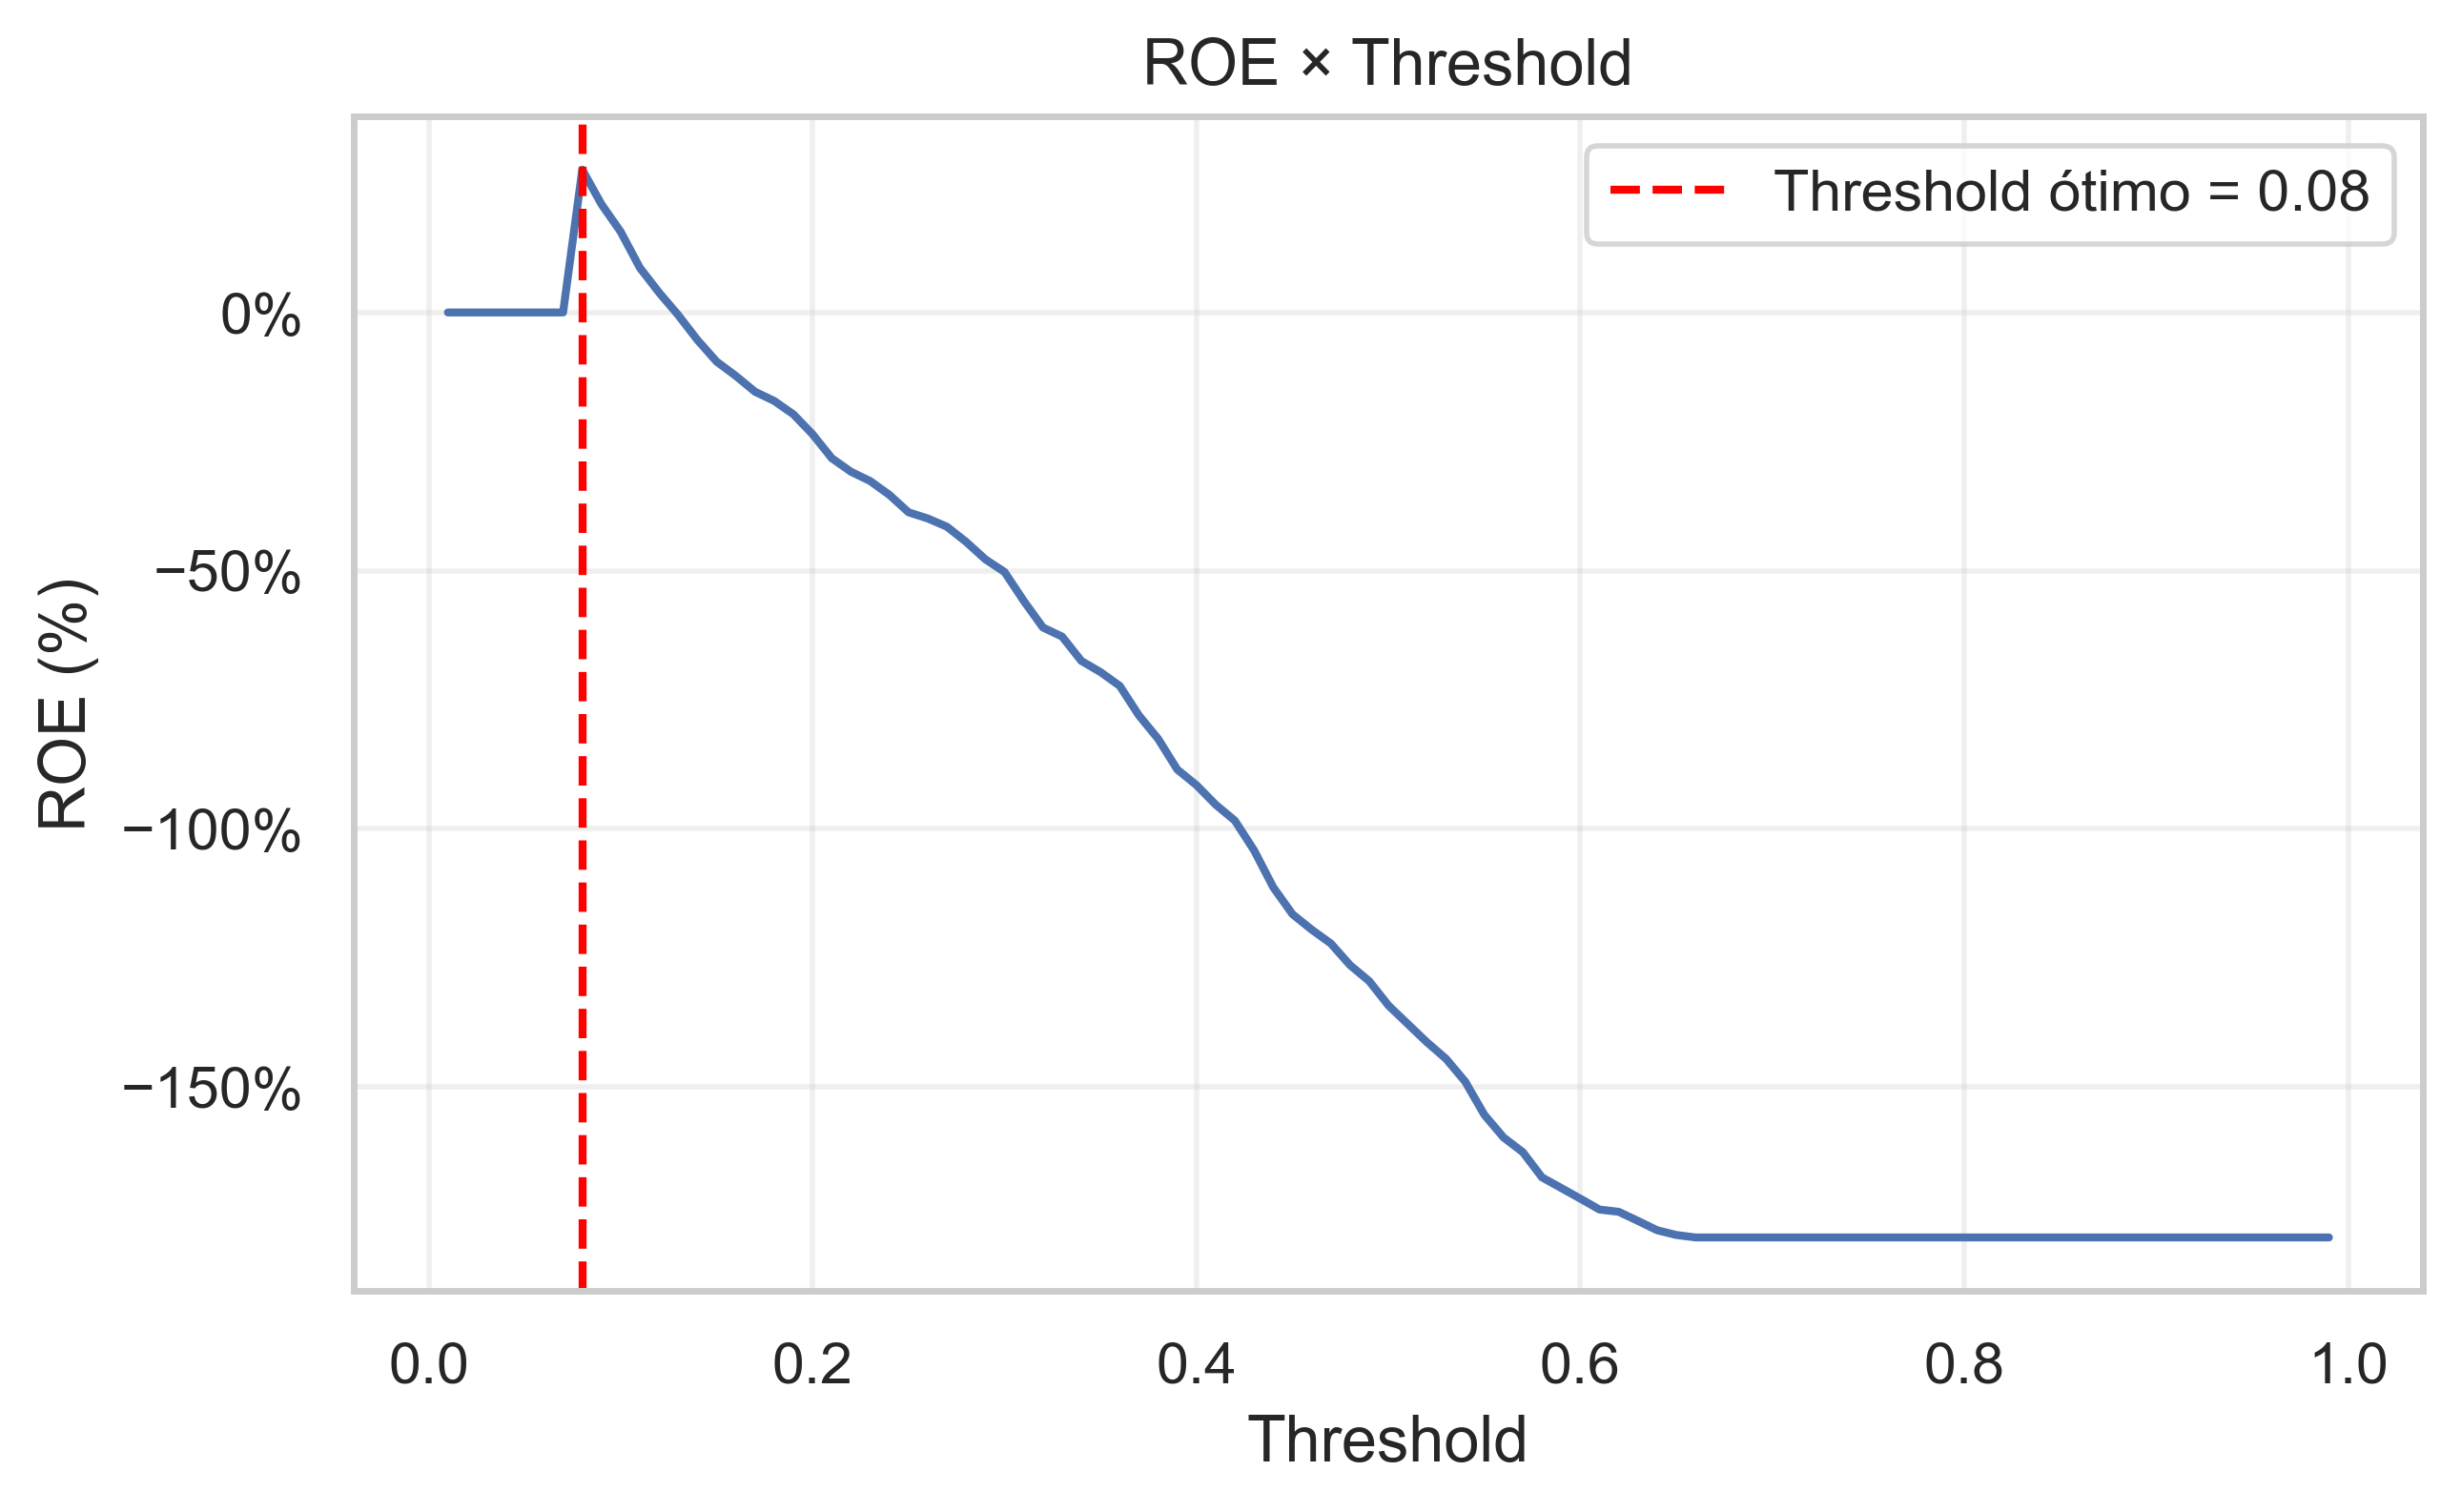

In [248]:
import matplotlib.ticker as mtick

y_min = roe_df["roe"].min()
y_max = roe_df["roe"].max()
padding = 0.05 * (y_max - y_min)

plt.figure(figsize=(7, 4))
plt.plot(roe_df["threshold"], roe_df["roe"])
plt.axvline(best_threshold, linestyle="--", color="red", label=f"Threshold ótimo = {best_threshold:.2f}")

plt.ylim(y_min - padding, y_max + padding)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title("ROE × Threshold")
plt.xlabel("Threshold")
plt.ylabel("ROE (%)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Esse resultado nos mostra que existe, sim, uma região economicamente viável da carteira. Em outras palavras, a carteira só cria valor quando aprovamos clientes com PD estimada inferior a ~8%. O único problema disso é que sabemos que esse valor corresponde cerca de 0.29% da nossa base atual e isso é um problemão. Porém, não é um problema de caráter estatístico ou de má modelagem, as análises estão certas e blindadas metodologicamente. O fato é o que já sabemos: esse é um problema do perfil do nosso dataset. Talvez aqui caberia um questionamento para as areas de negócio a respeito do perfil dos clientes e como eles foram selecionados, porque até então eles são bem problemáticos.

In [249]:
# Threshold ótimo já definido
THRESHOLD_OTIMO = best_threshold

# preparando DataFrame de política
policy_thr_opt_df = policy_df.copy()

# Regra de decisão global
policy_thr_opt_df["aprovado"] = policy_thr_opt_df["pd"] < THRESHOLD_OTIMO

In [250]:
roe_thr_opt_rows = []

for faixa in sorted(policy_thr_opt_df["risk_band"].unique()):
    df_faixa = policy_thr_opt_df[
        (policy_thr_opt_df["risk_band"] == faixa) &
        (policy_thr_opt_df["aprovado"])
    ]

    volume_aprovado = len(df_faixa)

    if volume_aprovado == 0:
        roe_thr_opt_rows.append({
            "Faixa": faixa,
            "Volume Aprovado": 0,
            "ROE": 0.0
        })
        continue

    pd_mean_aprovados = df_faixa["pd"].mean()

    # Lucro esperado por cliente (ex-ante)
    expected_profit_per_client = (
        (1 - pd_mean_aprovados) * payoff_aprova_bom
        + pd_mean_aprovados * payoff_aprova_mau
    )

    # Lucro esperado total
    total_expected_profit = expected_profit_per_client * volume_aprovado

    # Capital econômico total
    total_capital = (
        volume_aprovado * VALOR_MEDIO_EMPRESTIMO * CAPITAL_FACTOR
    )

    roe = (
        total_expected_profit / total_capital
        if total_capital > 0 else 0.0
    )

    roe_thr_opt_rows.append({
        "Faixa": faixa,
        "Volume Aprovado": volume_aprovado,
        "ROE": roe
    })

roe_by_band_thr_opt = pd.DataFrame(roe_thr_opt_rows)
roe_by_band_thr_opt_fmt = roe_by_band_thr_opt.copy()
roe_by_band_thr_opt_fmt["ROE"] = roe_by_band_thr_opt_fmt["ROE"].map("{:.2%}".format)

roe_by_band_thr_opt_fmt

Faixa  Volume Aprovado     ROE
0     A                2  27.65%
1     B                0   0.00%
2     C                0   0.00%
3     D                0   0.00%

O calculo do ROE por faixas de risco confirmou o que acabamos de descrever acima. A otimização do threshold com base na maximização do ROE ex-ante indicou um limiar ótimo em torno de 8%, resultando em um ROE elevado, porém com aprovação de apenas dois clientes na base analisada. Esse resultado evidencia que, sob o critério estritamente econômico, a carteira apresenta viabilidade apenas em um nicho extremamente restrito, inviabilizando a operação em termos de escala.

Em um contexto real de negócio, esse diagnóstico demandaria discussão com stakeholders para reavaliação de premissas como pricing, perfil da carteira e estrutura de capital. No entanto, para fins exploratórios e de demonstração metodológica neste projeto, será adotado um threshold operacional alternativo, com o objetivo de permitir a comparação entre políticas de corte, avaliação de impacto econômico e validação em conjunto holdout, mantendo o resultado ótimo como referência teórica. 

Por decisão vamos fixar o threshold no valor de `0.10` que está dentro do limite superior da faixa A adotada na criação das faixas durante a primeira etapa da política de risco.

In [251]:
# Threshold ótimo já definido
THRESHOLD_EMPIRICO = 0.10

# preparando DataFrame de política
policy_thr_emp_df = policy_df.copy()

# Regra de decisão global
policy_thr_emp_df["aprovado"] = policy_thr_emp_df["pd"] < THRESHOLD_EMPIRICO

roe_thr_emp_rows = []

for faixa in sorted(policy_thr_emp_df["risk_band"].unique()):
    df_faixa = policy_thr_emp_df[
        (policy_thr_emp_df["risk_band"] == faixa) &
        (policy_thr_emp_df["aprovado"])
    ]

    volume_aprovado = len(df_faixa)

    if volume_aprovado == 0:
        roe_thr_emp_rows.append({
            "Faixa": faixa,
            "Volume Aprovado": 0,
            "ROE": 0.0
        })
        continue

    pd_mean_aprovados = df_faixa["pd"].mean()

    # Lucro esperado por cliente (ex-ante)
    expected_profit_per_client = (
        (1 - pd_mean_aprovados) * payoff_aprova_bom
        + pd_mean_aprovados * payoff_aprova_mau
    )

    # Lucro esperado total
    total_expected_profit = expected_profit_per_client * volume_aprovado

    # Capital econômico total
    total_capital = (
        volume_aprovado * VALOR_MEDIO_EMPRESTIMO * CAPITAL_FACTOR
    )

    roe = (
        total_expected_profit / total_capital
        if total_capital > 0 else 0.0
    )

    roe_thr_emp_rows.append({
        "Faixa": faixa,
        "Volume Aprovado": volume_aprovado,
        "ROE": roe
    })

roe_by_band_thr_emp = pd.DataFrame(roe_thr_emp_rows)
roe_by_band_thr_emp_fmt = roe_by_band_thr_emp.copy()
roe_by_band_thr_emp_fmt["ROE"] = roe_by_band_thr_emp_fmt["ROE"].map("{:.2%}".format)

roe_by_band_thr_emp_fmt

Faixa  Volume Aprovado     ROE
0     A               36  15.64%
1     B                0   0.00%
2     C                0   0.00%
3     D                0   0.00%

Com a adoção do threshold empírico de 10%, observa-se que a política de crédito passa a apresentar viabilidade econômica com escala mínima, concentrando aprovações exclusivamente na Faixa A. Nessa configuração, a política aprova 36 clientes, resultando em um ROE positivo de 15,64%, enquanto as demais faixas (B, C e D) permanecem integralmente excluídas da concessão. Esse comportamento indica que, mesmo com uma flexibilização controlada do threshold em relação ao ótimo teórico (8%), a carteira continua exigindo alta seletividade para preservar retorno sobre o capital alocado.

Esse resultado reforça que a política economicamente viável para o perfil da base analisada é necessariamente conservadora e baseada em corte único, não havendo sustentação para estratégias de múltiplas faixas ou concessão escalonada de risco. Assim, a Faixa A concentra toda a geração de valor da política, enquanto as demais faixas representam risco excessivo sem compensação econômica adequada. Essa evidência fundamenta a recomendação de uma política de crédito simples, disciplinada e orientada por ROE, que será validada a seguir no conjunto holdout antes da definição final da política recomendada.

In [252]:
# Configuração
threshold = THRESHOLD_EMPIRICO

y_true = y_train.values
y_prob = oof_calibrated["LogisticRegression"]

def plot_confusion_heatmap(ax, y_true, y_prob, threshold, title):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax,
        xticklabels=["Aprova", "Rejeita"],
        yticklabels=["Adimplente", "Inadimplente"]
    )

    ax.set_title(title)
    ax.set_xlabel("Decisão do Modelo")
    ax.set_ylabel("Classe Real")



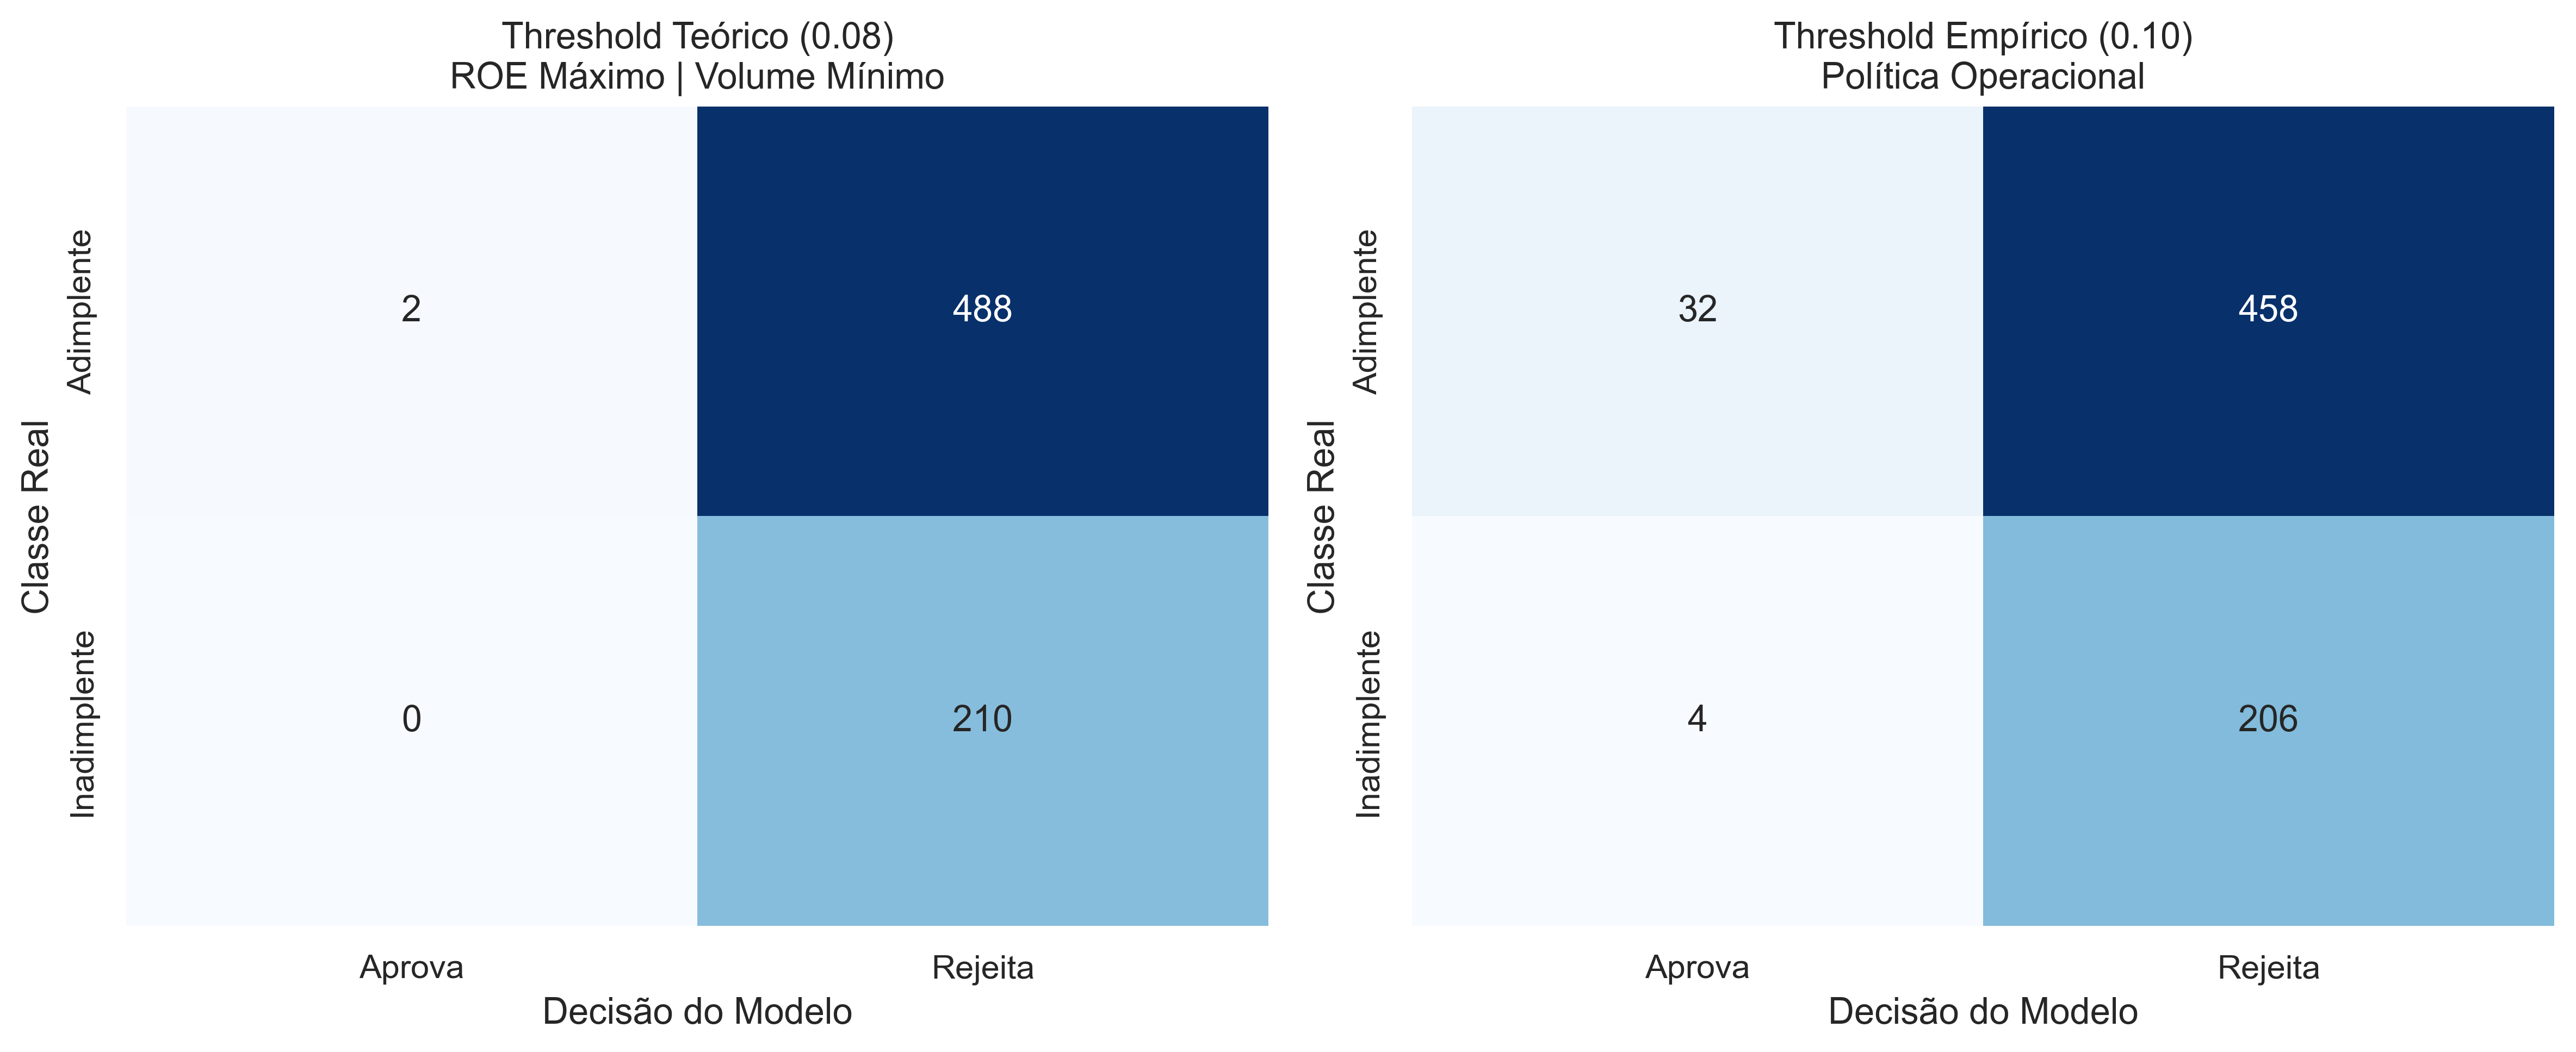

In [253]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Threshold teórico (ROE ótimo)
plot_confusion_heatmap(
    ax=axes[0],
    y_true=y_true,
    y_prob=y_prob,
    threshold=0.08,
    title="Threshold Teórico (0.08)\nROE Máximo | Volume Mínimo"
)

# Threshold empírico (operacional)
plot_confusion_heatmap(
    ax=axes[1],
    y_true=y_true,
    y_prob=y_prob,
    threshold=0.10,
    title="Threshold Empírico (0.10)\nPolítica Operacional"
)

plt.tight_layout()
plt.show()



A comparação entre as matrizes de confusão associadas ao threshold teórico (0,08) e ao threshold empírico (0,10) evidencia de forma clara o trade-off entre retorno econômico, escala operacional e experiência do cliente. No cenário teórico, apesar de maximizar o ROE ex-ante, a política aprova apenas 2 clientes adimplentes e rejeita 488 bons pagadores, caracterizando um volume extremamente elevado de falsos negativos. Esse comportamento implica alto potencial de fricção com clientes, aumento de churn e deterioração da percepção de crédito da instituição, uma vez que a maioria dos solicitantes elegíveis seria sistematicamente recusada, mesmo apresentando bom histórico de pagamento.

Ao adotar o threshold empírico de 10%, observa-se uma política ainda conservadora, porém mais alinhada à viabilidade operacional. Nesse cenário, 32 clientes adimplentes passam a ser aprovados, reduzindo parcialmente o volume de recusas indevidas, embora ainda persista um número elevado de bons pagadores rejeitados. Em contrapartida, essa flexibilização resulta na aprovação de 4 clientes inadimplentes, evidenciando o custo econômico e operacional associado ao aumento do risco. Esse resultado reforça que, mesmo dentro da Faixa A, o risco não é nulo e que qualquer expansão da política de concessão exige atenção ao impacto em perdas, custos de cobrança e pressão sobre as equipes internas. Em síntese, a comparação confirma que a política de crédito para esta carteira exige seletividade elevada, sendo necessário equilibrar cuidadosamente retorno, risco e experiência do cliente — justificando a adoção de um threshold empírico conservador como compromisso operacional.

## Política Final Recomendada

### Regras objetivas de decisão

A política de crédito adotará uma regra de corte único baseada em probabilidade de default (PD), conforme descrito abaixo:

- Modelo utilizado: Regressão Logística com probabilidades calibradas (Platt Scaling)

- Regra de decisão:

    - Aprovar clientes com PD ≤ 10%

    - Rejeitar clientes com PD > 10%

- Natureza da política: Conservadora, Altamente seletiva e Orientada por ROE ex-ante

- Essa regra reflete um compromisso entre o threshold ótimo teórico (8%), que maximiza o ROE mas é inviável em escala e a necessidade de uma política operacionalmente aplicável, ainda que com menor retorno marginal.

- Não são recomendadas políticas de múltiplas faixas, dado que apenas a Faixa A demonstrou capacidade consistente de geração de valor econômico.

### Diretrizes para Monitoramento

A política deverá ser acompanhada continuamente por meio de indicadores técnicos, econômicos e operacionais, com destaque para:

- Indicadores de Performance:

    - ROE ex-ante e ex-post
    - Ganho econômico agregado
    - Taxa de aprovação
    - Taxa de inadimplência dos aprovados
    - Volume absoluto de inadimplentes aprovados

- Indicadores Operacionais:

    - Proporção de falsos negativos (bons pagadores rejeitados)
    - Pressão sobre canais de atendimento e reclamações
    - Sinais de churn induzido por rejeição excessiva

- Estabilidade do Modelo:

    - Drift de PD (PSI / variação de distribuição)
    - Estabilidade da calibração
    - Consistência do desempenho no conjunto holdout

### Condições para Revisão da Política
A política deverá ser reavaliada caso ocorra qualquer uma das situações abaixo:
- ROE agregado consistentemente próximo de zero ou negativo
- Aumento relevante na inadimplência dos clientes aprovados
- Mudança estrutural no perfil da base (drift de risco)
- Alteração nas premissas econômicas, tais como:
  - aumento do custo de capital;
  - piora macroeconômica;
  - mudanças regulatórias.
- Introdução de novos produtos ou garantias, que alterem LGD ou pricing

Em um contexto real, uma revisão também seria mandatória caso se identifique a necessidade de ajuste de preços, segmentação mais refinada ou redefinição do público-alvo da carteira.

# Stress-Testing

Vamos conduzir agora um stress test simples variando o fato de capital econômico, com o objetivo de avaliar a sensibilidade do ROE da política final a cenários mais conservadores de alocação de capital. Esse fator representa a proporção da exposição que precisa ser imobilizada como capital econômico para sustentar uma operação de crédito. Ou seja, a redução do fator de capital implica menor imobilização de capital econômico por unidade de exposição, aumentando o ROE esperado, ao passo que fatores de capital mais elevados refletem políticas mais conservadoras, com maior exigência de capital e menor retorno sobre o capital alocado.

Porém, o capital não serve para gerar ROE diretamente, ele serve para proteger a capacidade futura de gerar ROE. Operar com faixas de capital muito baixas podem fragilizar as operações durante cenários de crises levando a empresa a falência. Dessa forma, os bancos e fintechs não escolhem o fator de capital para maximizar ROE; eles escolhem o fator de capital para sobreviver a choques, e então maximizam ROE dentro dessa restrição. Usualmente, essas empresas operam na faixa de 8 a 15%. Para os nossos testes vamos estressar esses limites e trabalhar numa faixa entre 5 a 25%.

In [254]:
# Política final
THRESHOLD_FINAL = 0.10

# grid de fatores de capital
capital_factors = np.array([0.05, 0.10, 0.15, 0.20, 0.25])

stress_results = []

for cf in capital_factors:
    roe = roe_gain(
        y_prob=y_prob,
        payoff_matrix=payoff_matrix,
        valor_medio_emprestimo=VALOR_MEDIO_EMPRESTIMO,
        capital_factor=cf,
        threshold=THRESHOLD_FINAL
    )

    stress_results.append({
        "Capital Factor (%)": cf * 100,
        "ROE": roe
    })

stress_df = pd.DataFrame(stress_results)
stress_df_fmt = stress_df.copy()
stress_df_fmt["ROE"] = stress_df_fmt["ROE"].map("{:.2%}".format)
stress_df_fmt

Capital Factor (%)     ROE
0               5.000  31.27%
1              10.000  15.64%
2              15.000  10.42%
3              20.000   7.82%
4              25.000   6.25%

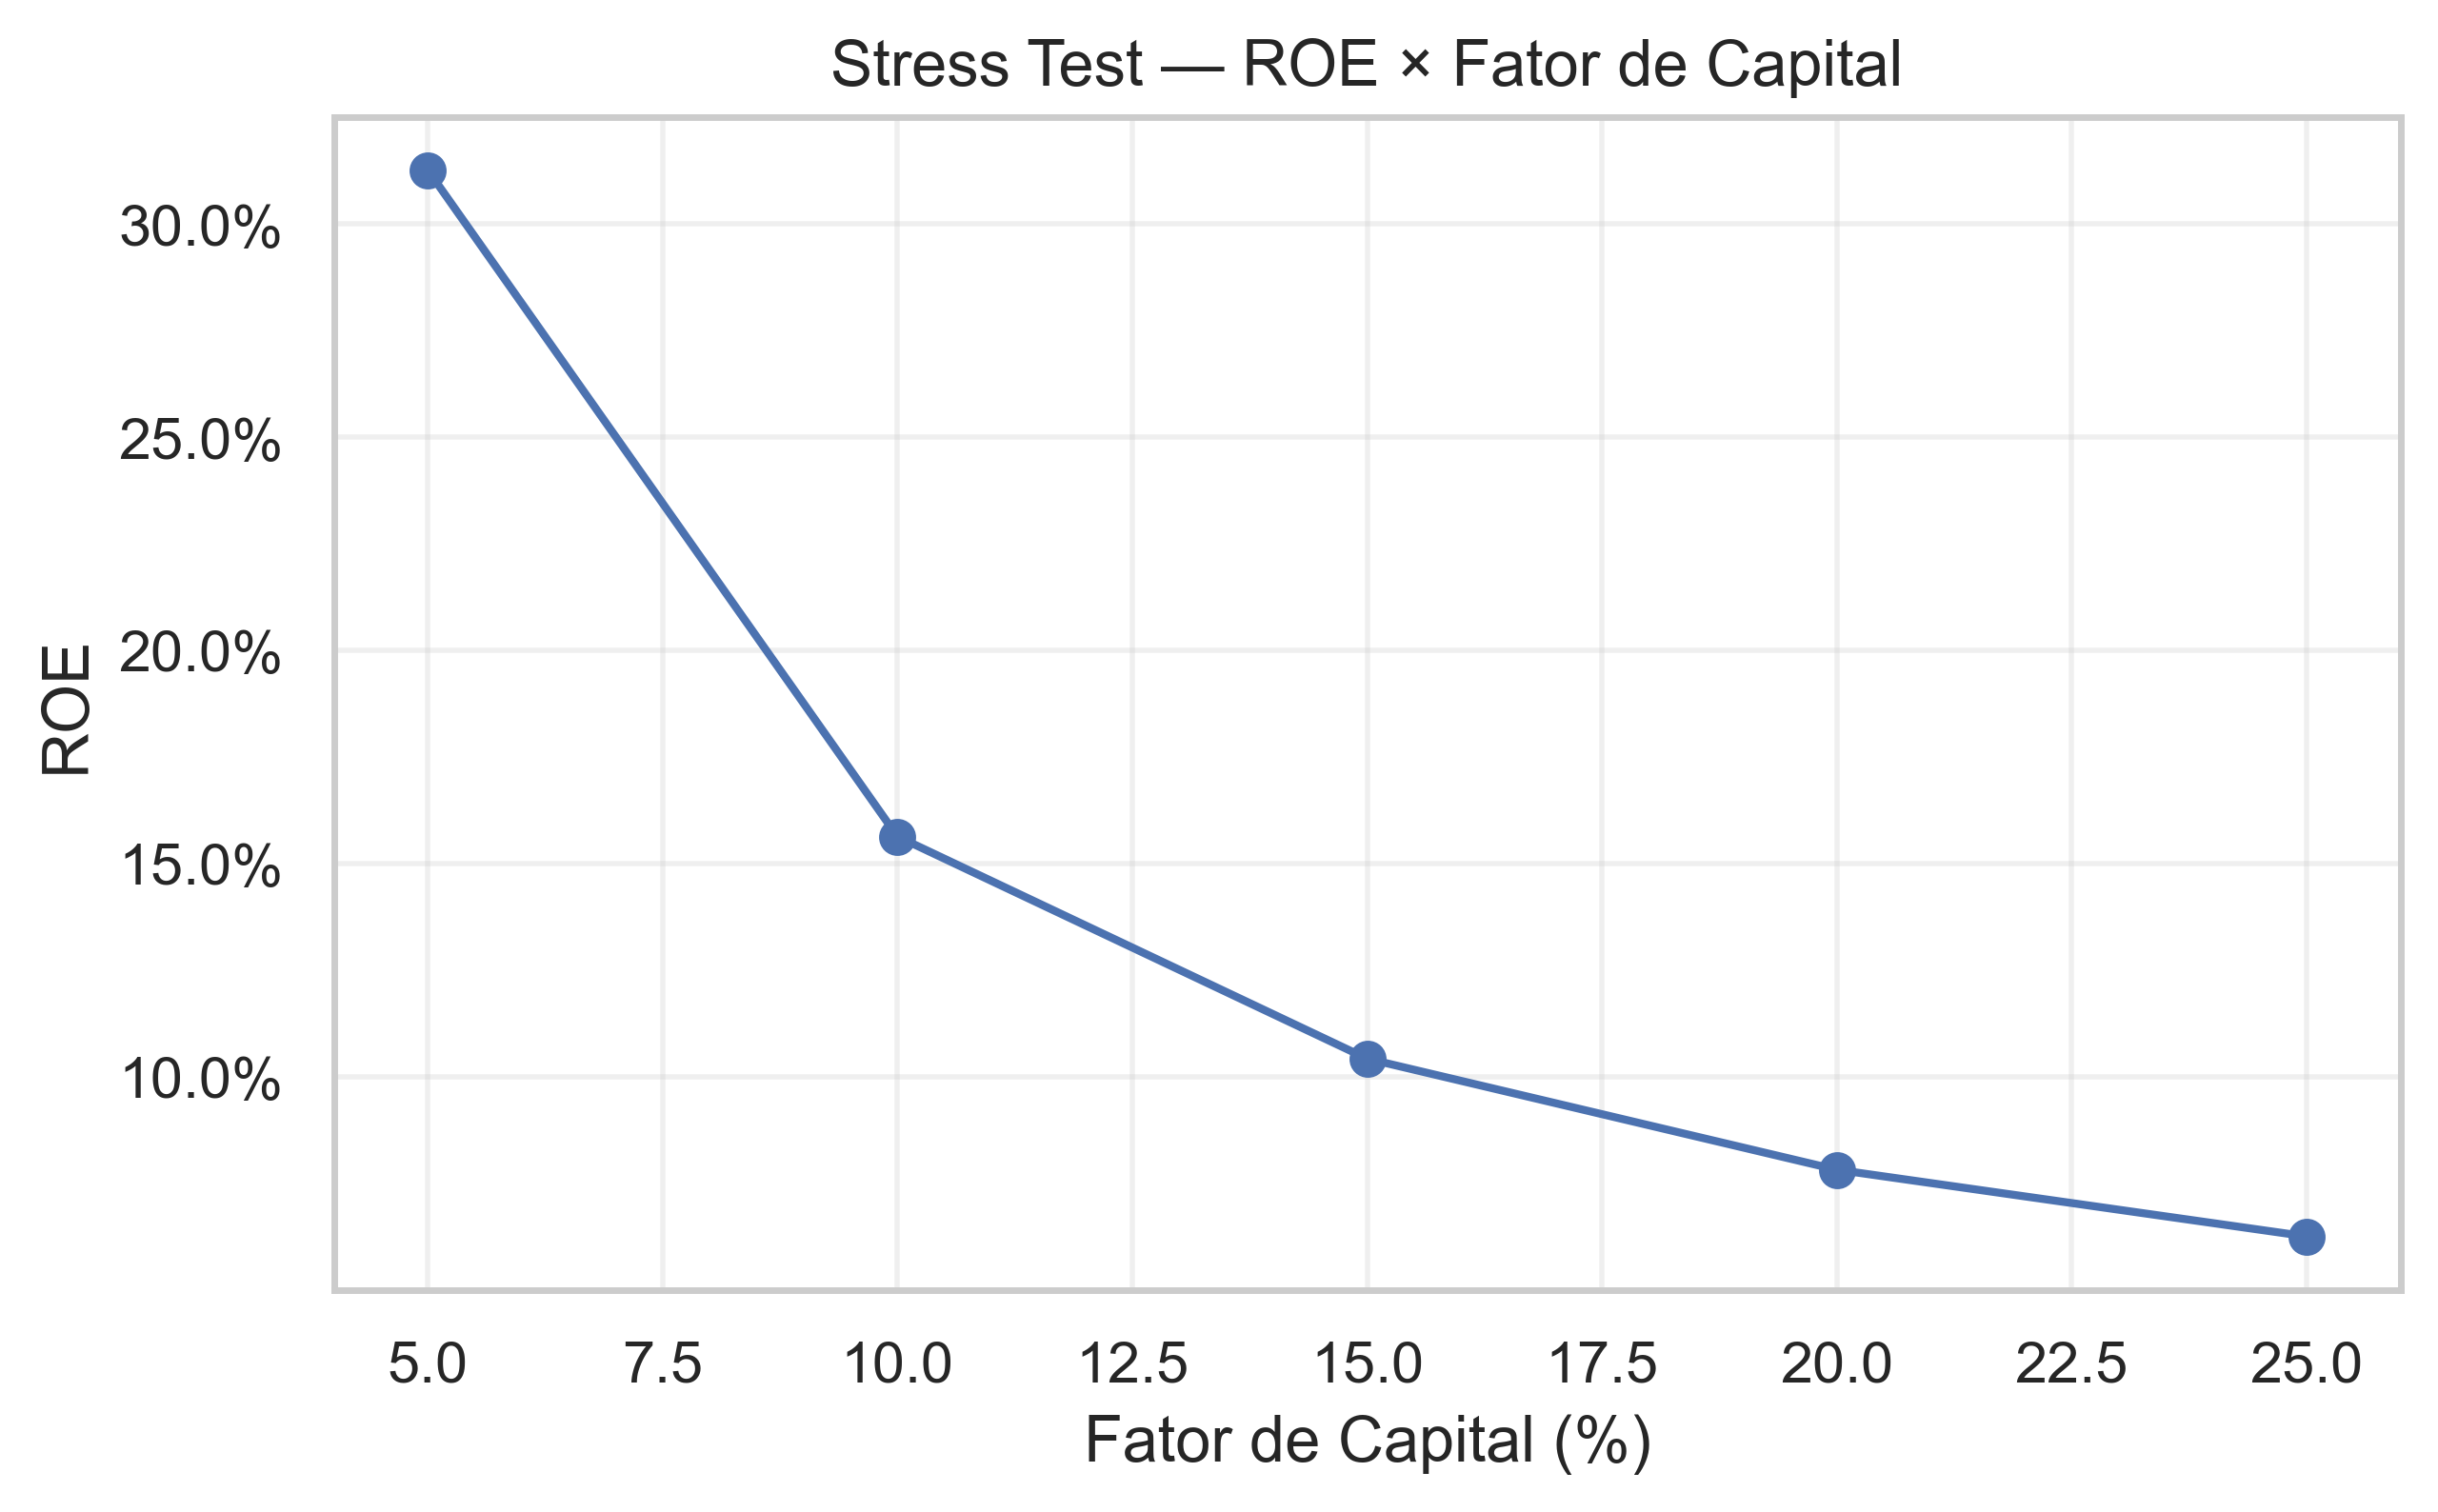

In [255]:
plt.figure(figsize=(7, 4))
plt.plot(stress_df["Capital Factor (%)"], stress_df["ROE"], marker="o")

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title("Stress Test — ROE × Fator de Capital")
plt.xlabel("Fator de Capital (%)")
plt.ylabel("ROE")
plt.grid(alpha=0.3)
plt.show()

A análise do fator de capital evidencia que a maximização do ROE não pode ser tratada como um objetivo isolado. Embora a redução do fator de capital implique menor imobilização de capital por unidade de exposição e, consequentemente, aumento do ROE esperado, esse efeito reflete apenas uma visão de curto prazo. Na prática, o capital econômico cumpre o papel fundamental de absorver perdas inesperadas e sustentar a solvência da instituição em cenários adversos, funcionando como um amortecedor contra choques sistêmicos e eventos de cauda que não estão capturados pelas métricas de perda esperada.

Operar com níveis excessivamente baixos de capital impõe custos econômicos relevantes que não se refletem imediatamente no ROE, mas comprometem o valor de longo prazo da instituição. Entre esses custos estão o aumento da volatilidade do retorno, a elevação do custo de funding, a perda de flexibilidade estratégica e a redução da capacidade de crescimento em momentos de estresse, justamente quando oportunidades atrativas tendem a surgir. Assim, embora o ROE aparente melhorar com maior alavancagem, o risco de ruína e a deterioração do perfil de risco-retorno acabam reduzindo o valor econômico ajustado ao risco.

Nesse contexto, o stress test do fator de capital não busca identificar o nível que maximiza o ROE, mas avaliar a robustez da política de crédito proposta frente a cenários mais conservadores de exigência de capital. Uma política que apenas se sustenta sob fatores de capital artificialmente baixos revela fragilidade estrutural, enquanto aquela que mantém ROE positivo sob níveis mais conservadores demonstra disciplina de risco e governança adequada. Dessa forma, a análise reforça que a definição da política de crédito deve priorizar a sustentabilidade econômica e a resiliência institucional, e não a maximização oportunista de métricas de curto prazo.

# Interpretação do Modelo

Nesta etapa, será realizada a interpretação do modelo final selecionado por meio da análise dos coeficientes da regressão logística. O objetivo é compreender como cada variável contribui para o aumento ou redução do risco estimado, garantindo coerência com o domínio do problema e reforçando a transparência da política de crédito adotada. Os coeficientes serão analisados tanto em formato tabular quanto visual, respeitando o sinal e a magnitude do impacto de cada variável.

## Coeficientes

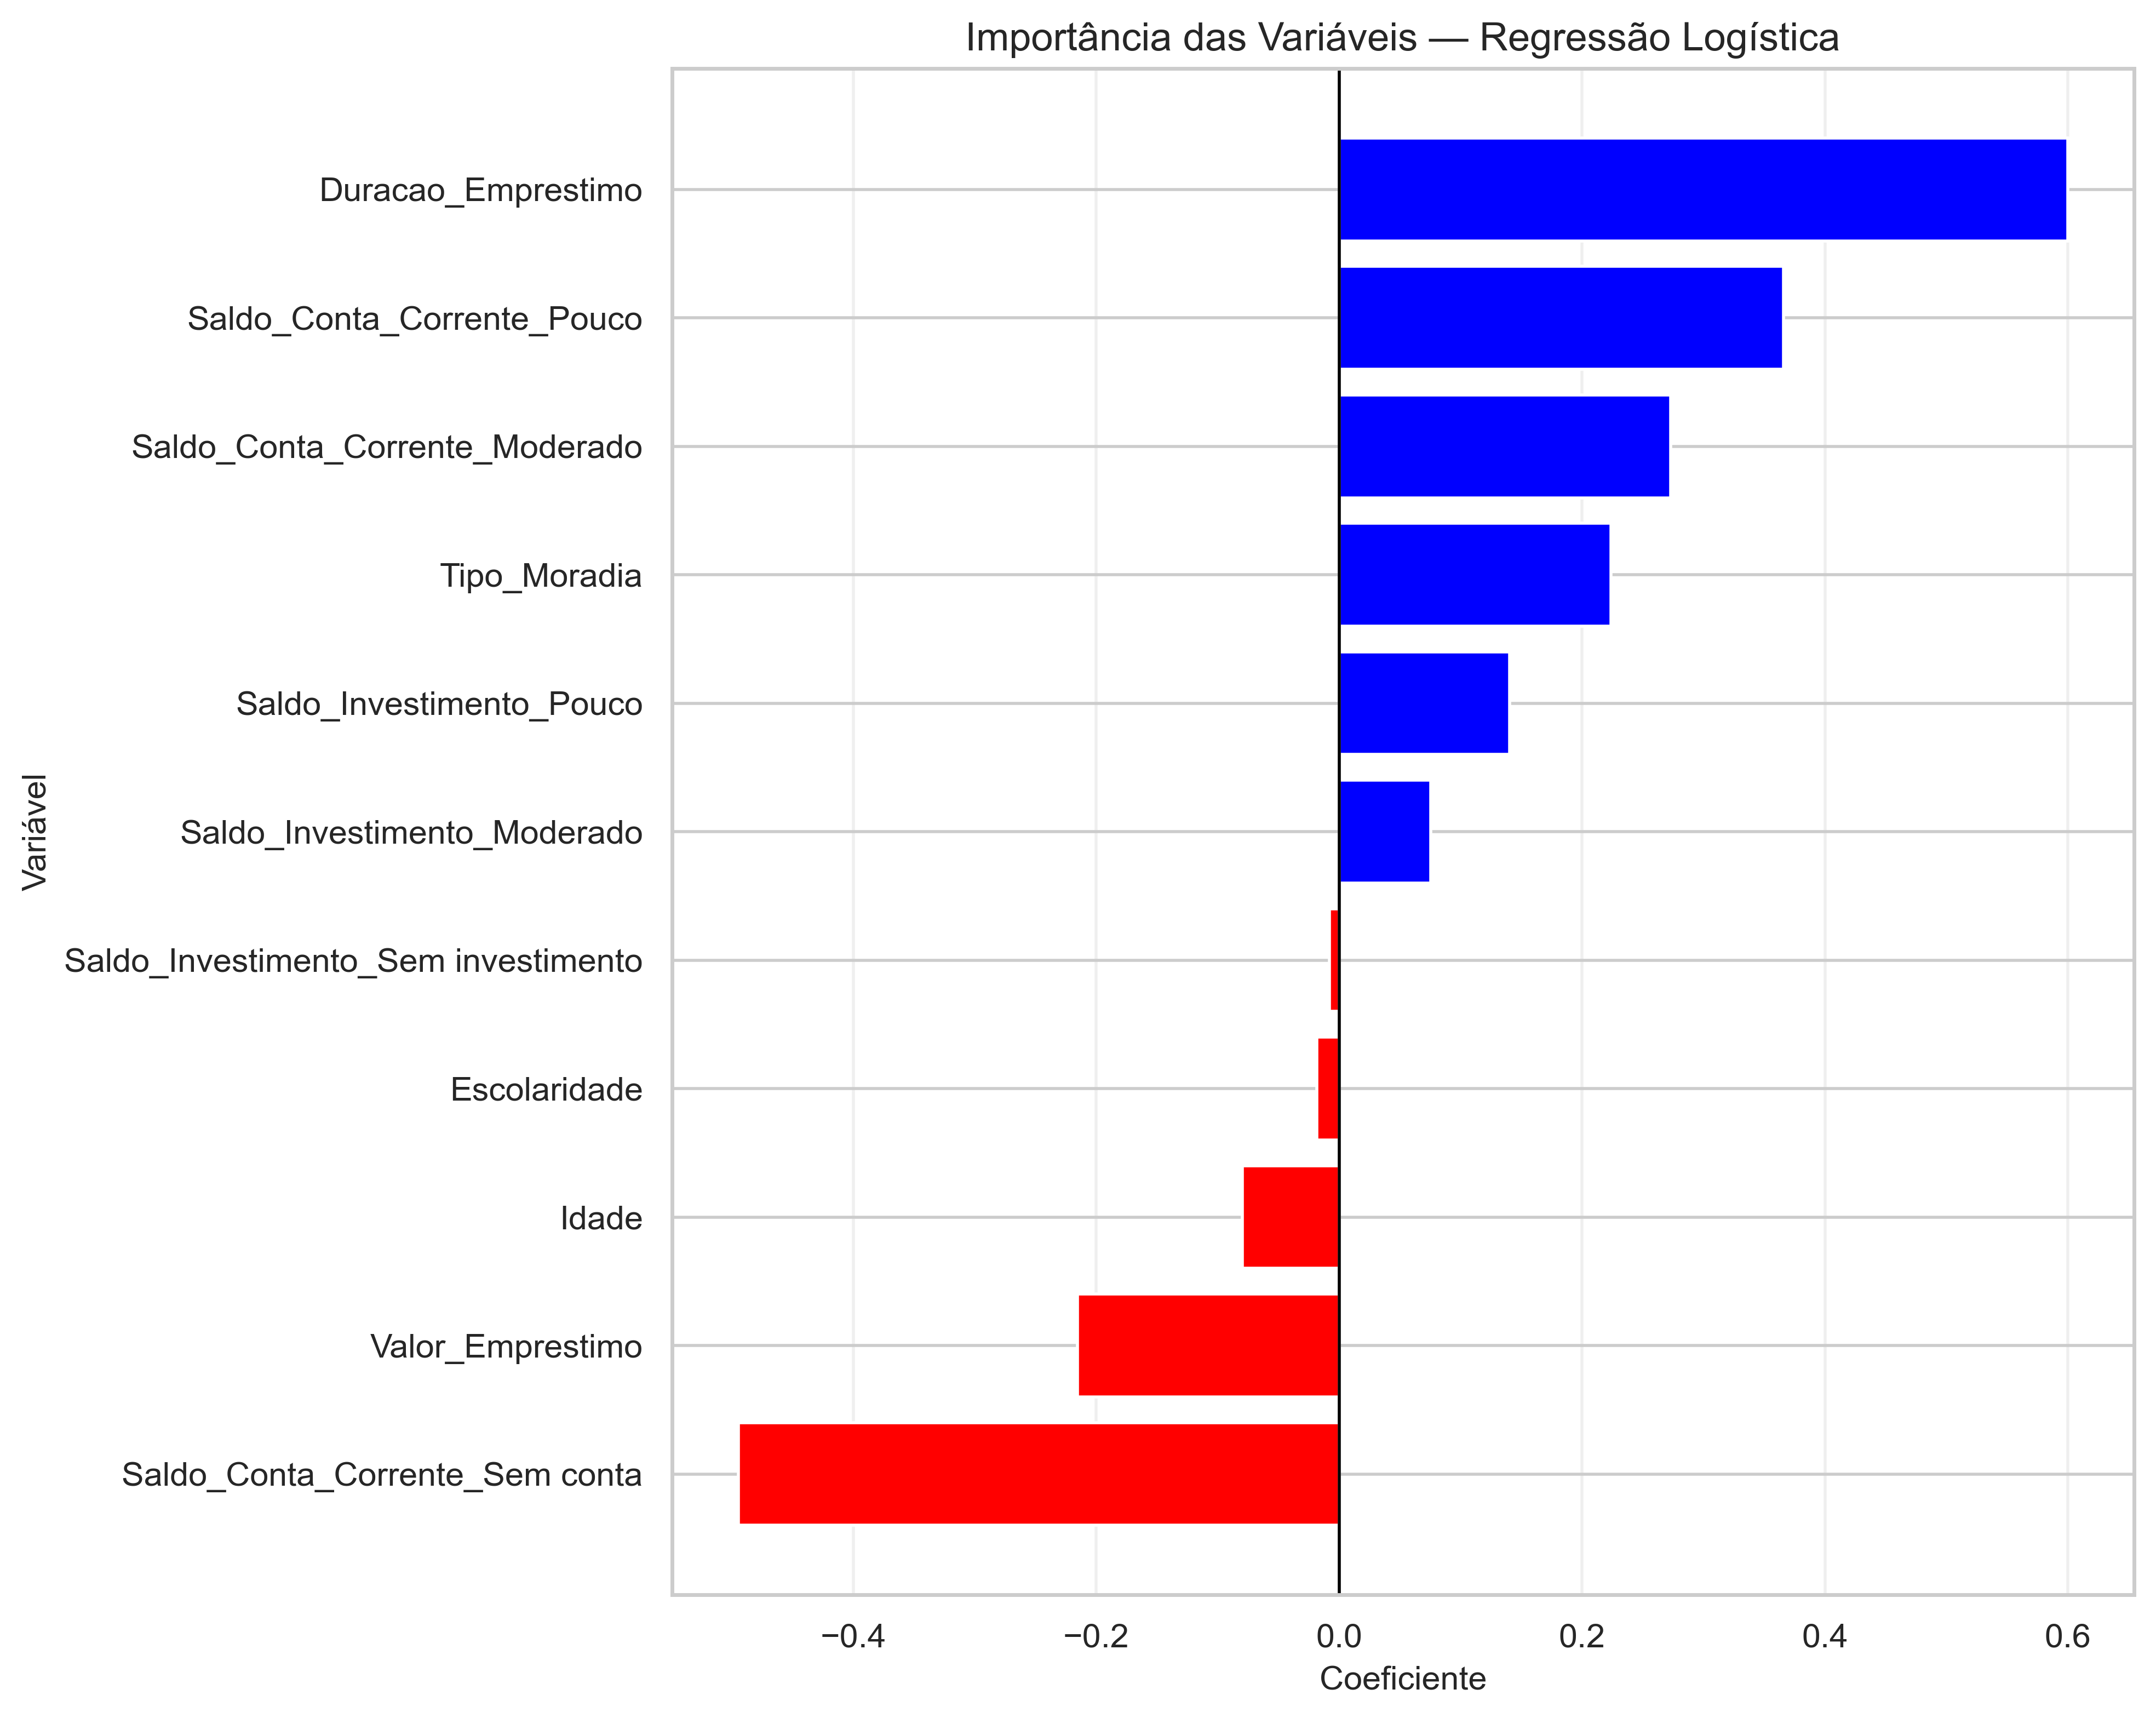

In [256]:
# Extraindo modelo e coeficientes
logit_model = logit_pipe.named_steps["clf"]

# Coeficientes (1D)
coefficients = logit_model.coef_.flatten()

# Nomes das features
# Como não há criação de novas features no pipeline,
# os coeficientes correspondem diretamente às colunas originais
feature_names = X_train.columns

# Criar DataFrame ordenado

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coeficiente": coefficients
})

# Ordenar por magnitude absoluta
coef_df["abs_coef"] = coef_df["coeficiente"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)
coef_df = coef_df.drop(columns="abs_coef")

# Plotar gráfico de barras

TOP_N = len(coef_df)  # usa todas as variáveis; ajuste se quiser
plot_df = coef_df.sort_values("coeficiente")

# Definir cores por sinal
colors = plot_df["coeficiente"].apply(
    lambda x: "blue" if x > 0 else "red"
)

fig, ax = plt.subplots(figsize=(10, 8))

ax.barh(
    plot_df["feature"],
    plot_df["coeficiente"],
    color=colors
)

# Linha vertical no zero
ax.axvline(0, color="black", linewidth=1)

# Labels e título
ax.set_title("Importância das Variáveis — Regressão Logística", fontsize=13)
ax.set_xlabel("Coeficiente", fontsize=11)
ax.set_ylabel("Variável", fontsize=11)

# Ajustes visuais
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()

plt.show()



A regressão logística revela um conjunto de relações claras e coerentes com a lógica econômica do risco de crédito. A variável com maior impacto positivo sobre a probabilidade de inadimplência é a duração do empréstimo, indicando que operações mais longas estão associadas a maior risco, seja por maior exposição ao tempo, seja por maior incerteza econômica ao longo do contrato. Em seguida, destacam-se categorias relacionadas a baixos e moderados saldos em conta corrente e investimentos, que aumentam significativamente o risco estimado, refletindo menor liquidez e menor capacidade de absorção de choques financeiros.

Por outro lado, a variável “Saldo_Conta_Corrente_Sem conta” apresenta o coeficiente mais negativo do modelo, indicando forte redução da probabilidade de inadimplência. Esse resultado sugere um efeito de segmentação importante: clientes fora do sistema bancário tradicional, no contexto desta base específica, apresentam comportamento mais conservador ou operações de menor risco. De forma complementar, valor do empréstimo e idade também contribuem para a redução do risco, ainda que com menor magnitude, sugerindo que clientes mais maduros e operações de maior valor — possivelmente mais avaliadas — tendem a apresentar melhor desempenho.

De forma geral, o modelo apresenta coerência econômica e interpretabilidade elevada: variáveis associadas à fragilidade financeira aumentam o risco, enquanto indicadores de estabilidade ou perfis específicos reduzem a probabilidade de inadimplência. Como todas as variáveis foram transformadas e padronizadas, a comparação direta dos coeficientes é válida, reforçando a robustez da leitura e a adequação do modelo para sustentar decisões de política de crédito baseadas em risco.

## SHAP (extra)

Como complemento à análise dos coeficientes da regressão logística, será utilizada a metodologia SHAP (SHapley Additive exPlanations) para interpretar o impacto das variáveis na predição individual e global do modelo. Para modelos lineares, o SHAP Linear Explainer permite decompor a probabilidade estimada em contribuições aditivas de cada variável, oferecendo uma interpretação consistente, local e global, alinhada à teoria de jogos.

In [257]:
# Dados transformados (sem o classificador)
X_train_transformed = logit_pipe[:-1].transform(X_train)

# Modelo linear
logit_model = logit_pipe.named_steps["clf"]

# Feature names
feature_names = X_train.columns

# Criando os SHAP values
explainer = shap.LinearExplainer(
    logit_model,
    X_train_transformed,
    feature_names=feature_names
)

shap_values = explainer(X_train_transformed)

### SHAP summary plot (global)

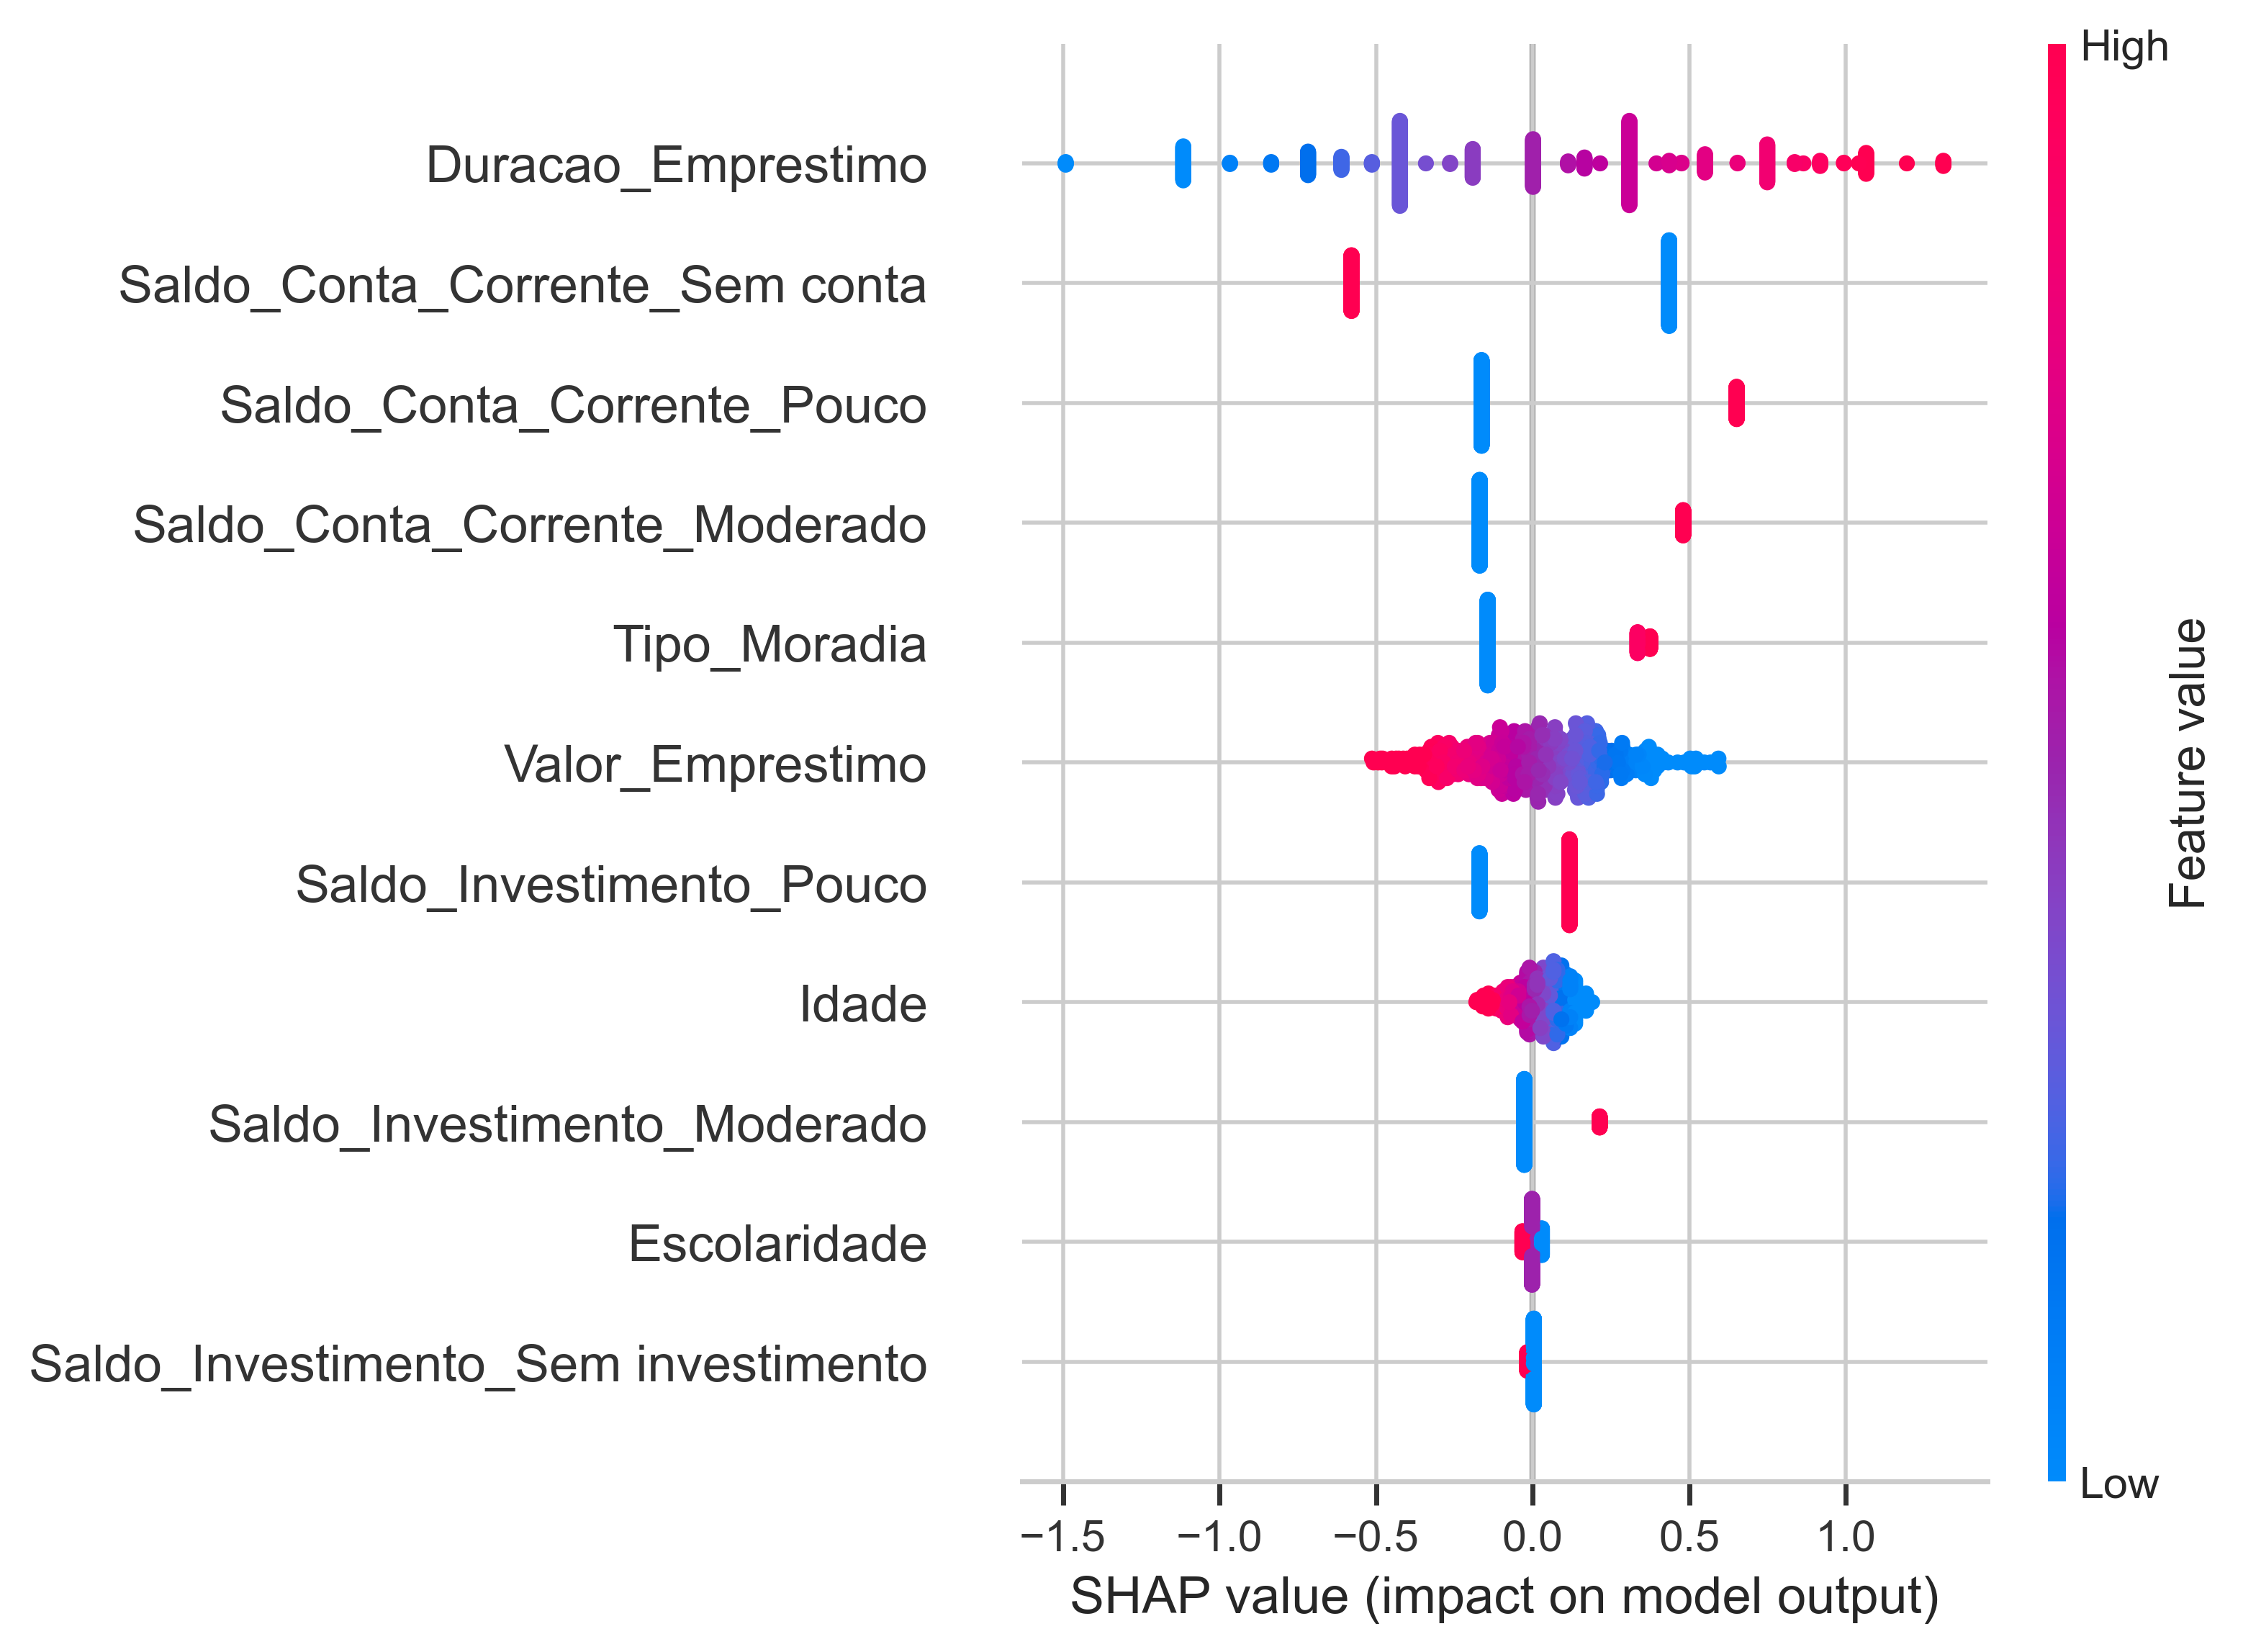

In [258]:

shap.summary_plot(
    shap_values.values,
    X_train_transformed,
    feature_names=feature_names,
    plot_type="dot",
    show=True
)


O summary plot mostra quais variáveis mais influenciam o modelo, em que direção (aumentam ou reduzem o risco) e como essa influência varia ao longo da distribuição dos dados.

As variáveis são ordenadas por importância global, portanto a variável `Duracao_Emprestimo` é a variável mais importante - o que está de acordo com os nossos coeficientes. A importância é definida como média do valor absoluto do SHAP, quanto mais no topo a variável estiver, mais impacto ela causa no modelo. 

Quando olhamos para o eixo X, estamos analisando o impacto da variável na predição. Valores postivos aumentam o log-odds/PD, enquanto valores negativos reduzem. Para o nosso contexto, SHAP positivo aumenta o risco e SHAP negativo, diminui. 

Cada ponto do gráfico é um cliente, portanto cada posição horizontal reflete o impacto daquela variável naquele cliente e a cor define se o valor é alto ou baixo. Por exemplo, continuemos avaliando a variável `Duracao_Emprestimo`, é uma variável com alta dispersão horizontal. Isso significa que ela é uma variável de alto poder discriminatório, indicando uma contribuição relevante, heterogeneidade e sensibilidade ao contexto do negócio. Onde, valores muito altos (vermelhos), aumentam o risco e valores baixos (azuis) reduzem o risco. Já a variável `Valor_Emprestimo` possui uma distribuição horizontal mais moderada, o que significa que ela tem um impacto consistente no modelo e é uma variável estável. Por fim, variáveis como `Escolaridade`, com uma distribuição achatada, resulta em uma variável marginal para o modelo, sendo de baixo impacto.

### SHAP Bar plot (importância média)

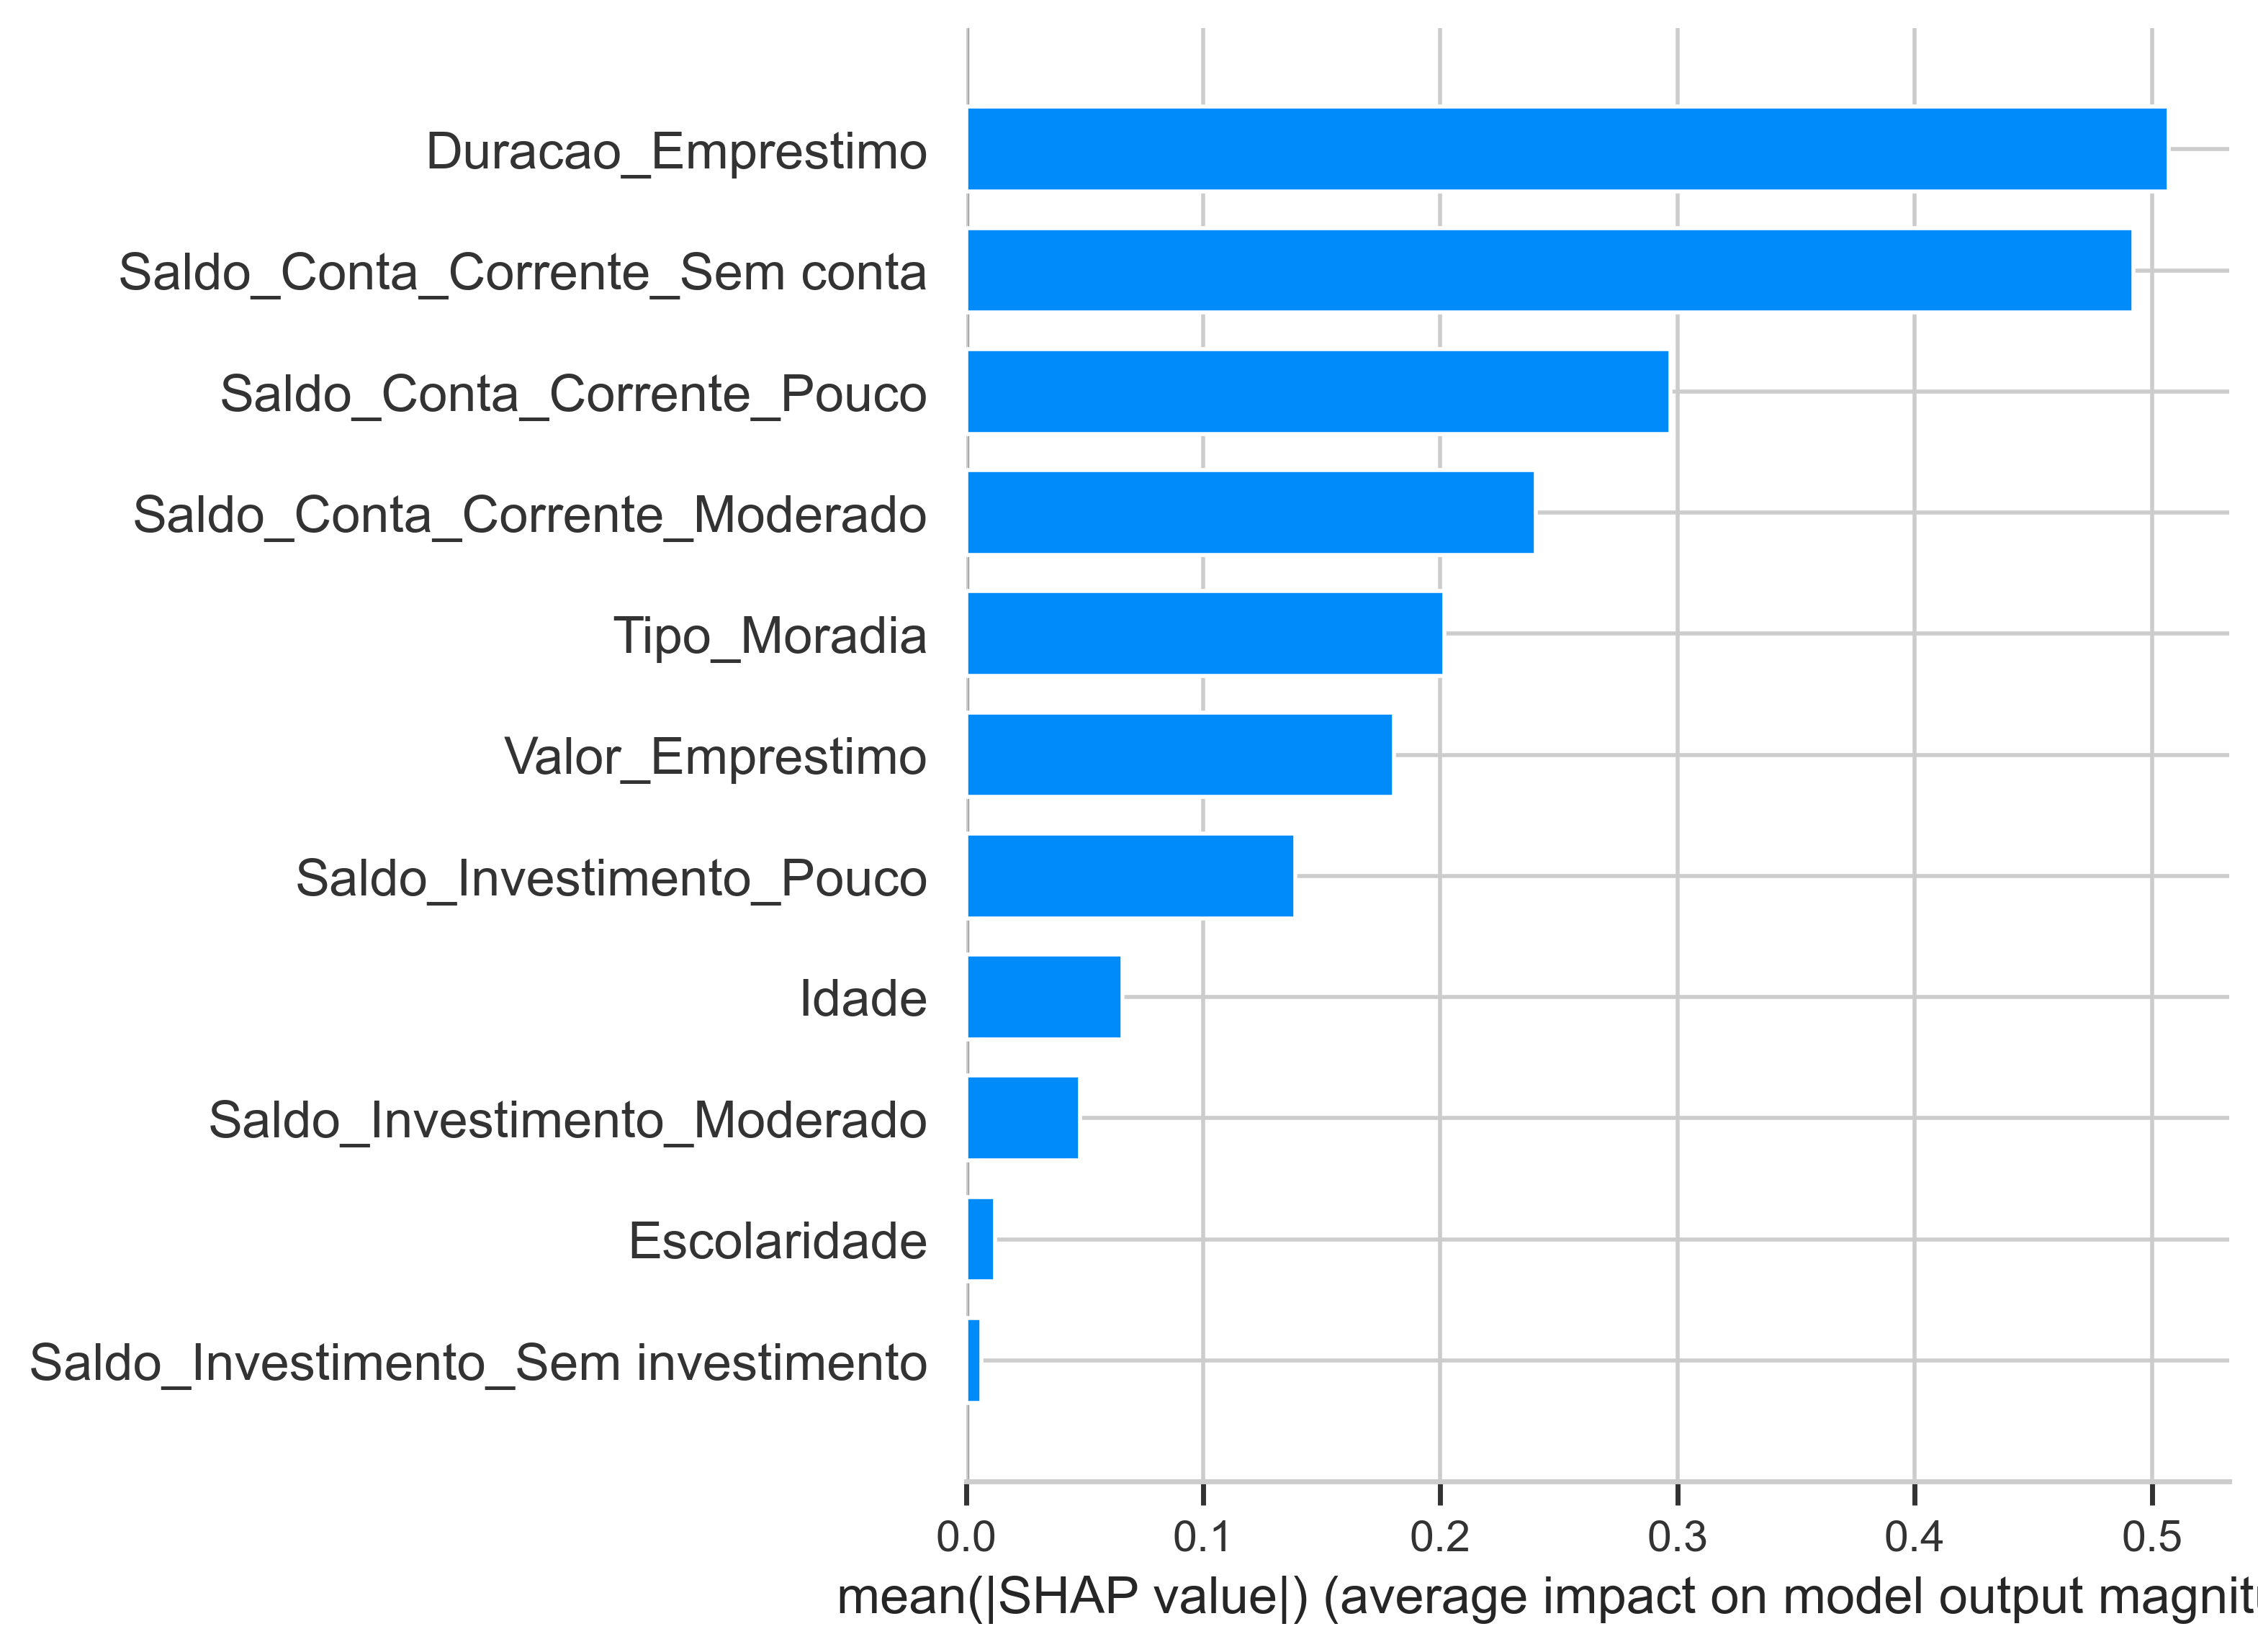

In [259]:
shap.summary_plot(
    shap_values.values,
    X_train_transformed,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)


Esse gráfico SHAP é o equivalente ao gráfico de barras do coeficiente que plotamos acima, mas com algumas ressalvas:
- ele é ponderado pela distribuição dos dados;
- ele é mais robusto para apresentação executiva;

### SHAP Waterfall (explicação individual)

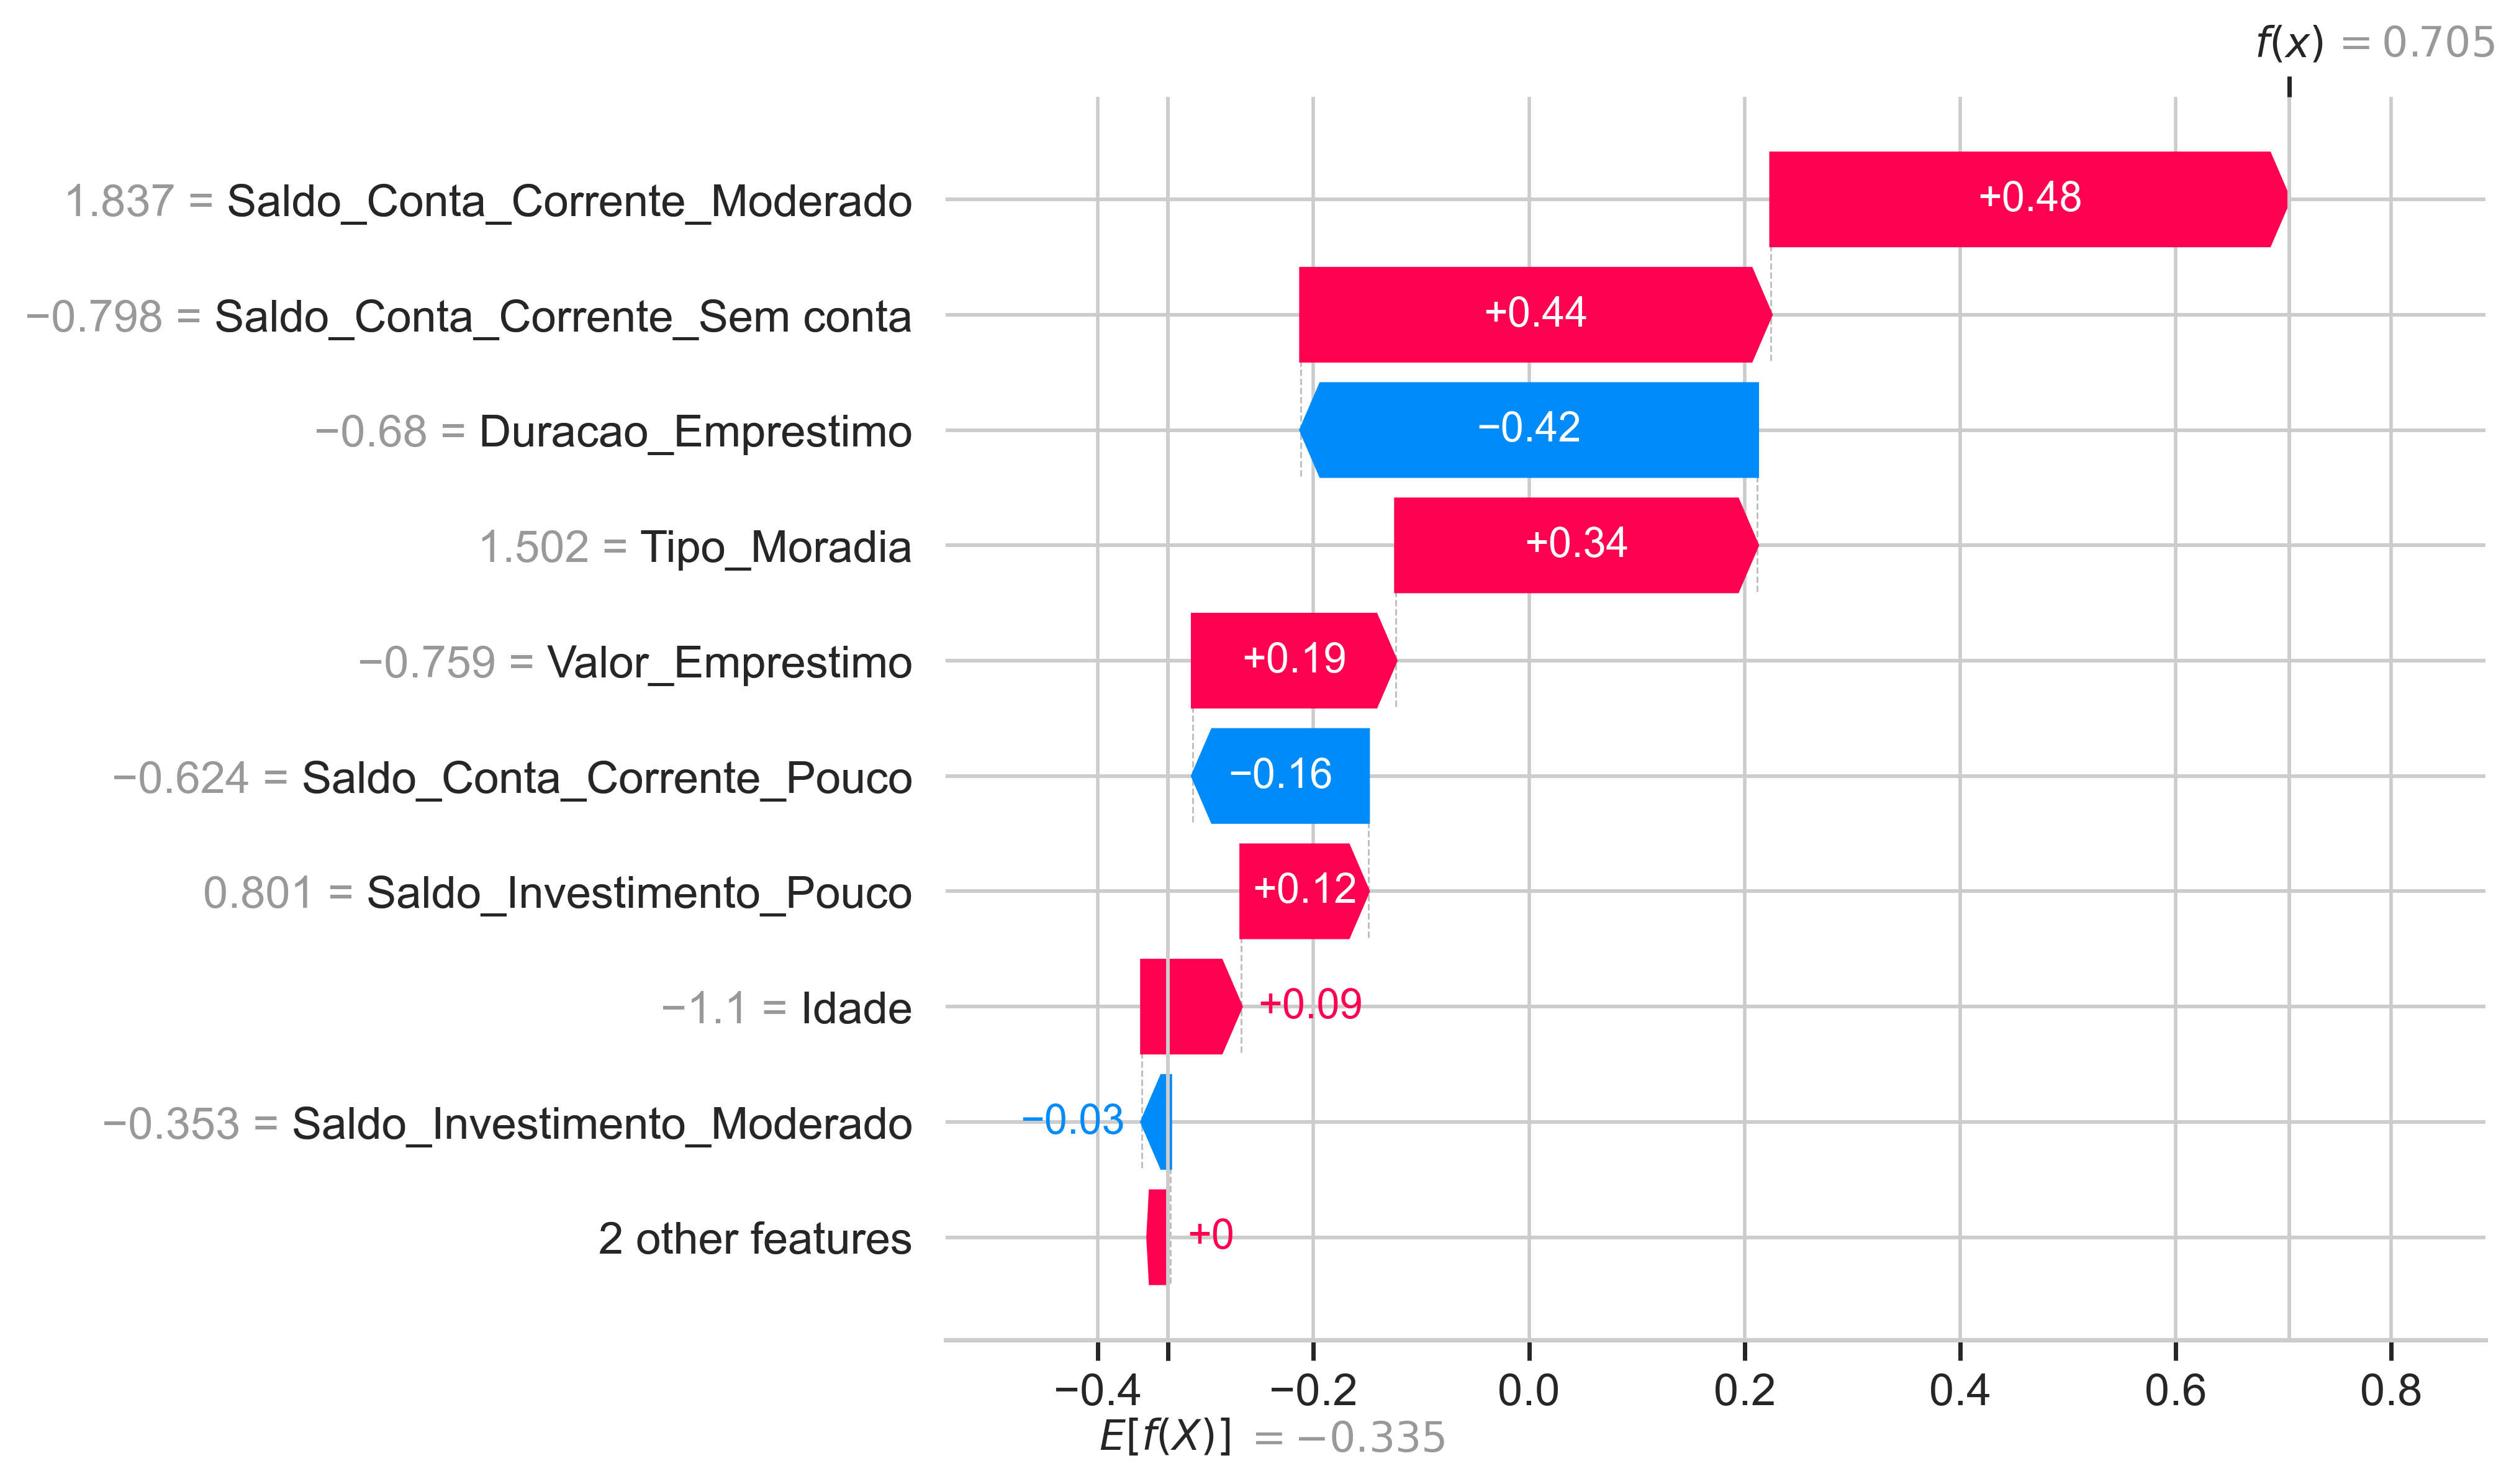

In [260]:
idx = 0  # pode trocar por qualquer índice

shap.plots.waterfall(
    shap_values[idx],
    max_display=10
)


Esse gráfico é bem legal e intuitivo. Ele mostra, para cada cliente (idx), como as variáveis do modelo colaboram para a sua aprovação ou rejeição. O valor base (E[f(x)]), representa o risco médio tido como a referência, a partir desse ponto, as contribuições individuais das variáveis deslocam a predição até o valor final estimado para o cliente, representado por f(x). As barras vermelhas, aumentam o f(x) e, consequentemente, aumentam o risco. E, as azuis, reduzem o f(x), reduzindo o risco da classe positiva.

# Considerações Finais

A análise demonstrou que políticas excessivamente conservadoras, embora maximizem métricas ex-ante como ROE, resultam em volumes operacionais inviáveis e elevado risco de fricção com clientes bons pagadores, comprometendo a sustentabilidade do negócio. Por outro lado, políticas demasiadamente flexíveis ampliam o volume aprovado, mas introduzem perdas econômicas e custos operacionais relevantes, sobretudo associados à inadimplência e aos esforços de cobrança. Esse trade-off estrutural reforça que decisões de crédito não devem ser orientadas exclusivamente por métricas técnicas ou financeiras isoladas, mas por um equilíbrio entre risco, retorno e capacidade operacional.

Diante desse cenário, a política final recomendada adotou uma estratégia de corte único, com threshold empírico ajustado, capaz de equilibrar seletividade, retorno econômico e viabilidade operacional. A tentativa de implementação de políticas multi-faixa mostrou-se impraticável, dada a concentração de risco da base analisada e a baixa representatividade de clientes em faixas de risco extremamente baixo. Assim, a política proposta reflete não apenas uma decisão técnica, mas uma leitura realista das limitações estruturais da carteira e do contexto do negócio.

# Próximos Passos e Trabalhos Futuros

- Validar a política definida em ambiente de produção, com monitoramento contínuo de métricas de performance, estabilidade e calibração das probabilidades.
- Implementar rotinas de acompanhamento do threshold ao longo do tempo, avaliando sua sensibilidade a mudanças no perfil da carteira e no ambiente econômico.
- Realizar stress tests mais abrangentes, incorporando cenários macroeconômicos adversos e diferentes níveis de exigência de capital.
- Explorar enriquecimento da base de dados e novas fontes de informação para ampliar a separação entre faixas de risco e viabilizar políticas mais granulares.
- Avaliar políticas adaptativas de crédito, com thresholds dinâmicos ajustados ao ciclo econômico e à estratégia de crescimento do portfólio.
- Apoiar a política de decisão com o modelo WOE, calculando as faixas e ROE e comparando com o Benchmark teórico que obtivemos.